# Self Driving Car : 

## Problem definition.

- In simplified minimal version, we have total 45406 sequence of images (25 minutes of video) with the corresponding Steering wheel angles as a Dataset.
- Primary Objectives are to learn the Deep Learning techniques and by applying them Predict the Sequence of Steering wheel angles.
- We choosed end to end model in which we predict Steering wheel angle for each single images. And for visualizing the output OpenCV is used.
- Split the dataset : Train vs Test :-
    - 80% : 20%
    - 25min : 5min
- Sequence of images -> Sequence of Steering wheel angle (regression problem)

# Dash-cam images and steering angles.

In [1]:
# Refer "driving_dataset" folder

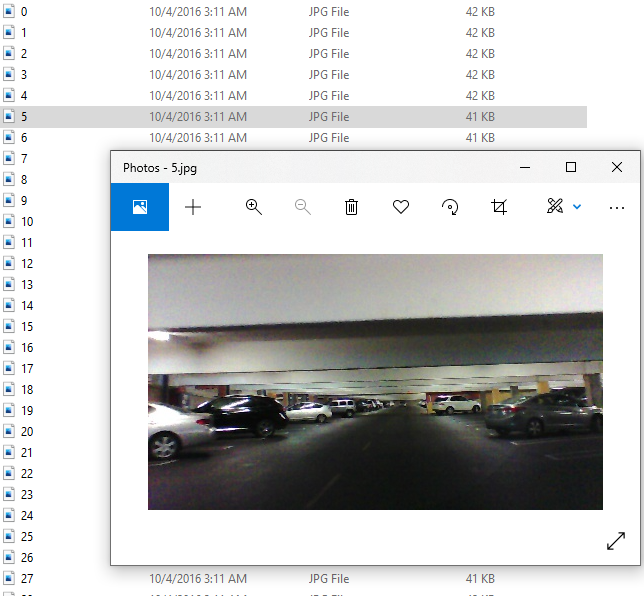

# EDA : Steering angles and images

In [2]:
# Here,temp for temporary using only for some EDA

import numpy as np

x_temp = []
y_temp = []

#read data.txt
with open("driving_dataset/data.txt") as d:
    for line in d:
        x_temp.append("driving_dataset/" + line.split()[0])
        y_temp.append(float(line.split()[1]) * 3.14159265 / 180)
        
y_temp = np.array(y_temp)

split_indx = int(len(y_temp)*0.8)

temp_train_y = y_temp[:split_indx]
temp_test_y = y_temp[split_indx:]

print(len(temp_train_y))
print(len(temp_test_y))

36324
9082


### Visualizing some of the images

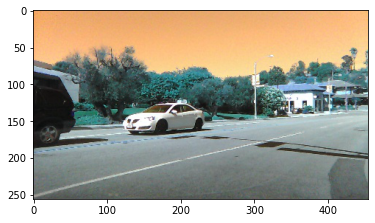

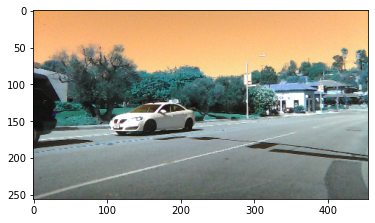

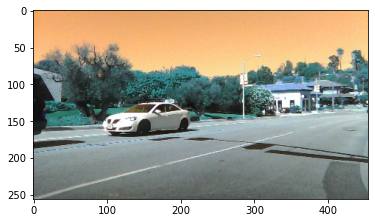

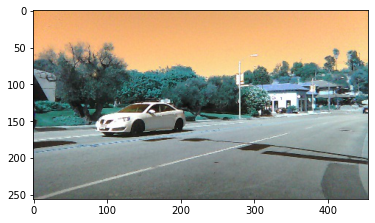

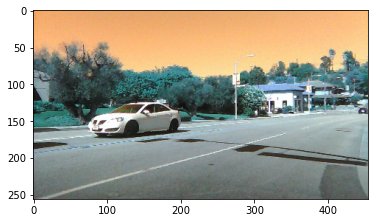

In [3]:
import cv2
import matplotlib.pyplot as plt

for i in range(995,1000):
    k=cv2.imread(x_temp[i])
    plt.imshow(k)
    plt.show()

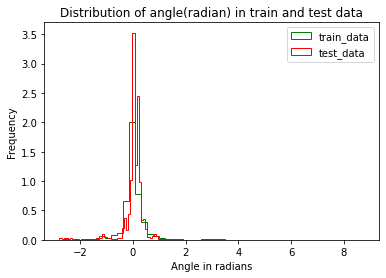

In [4]:
# PDF of train and test 'y' values. 

import matplotlib.pyplot as plt 

plt.hist(temp_train_y, density = True, bins=50, color='green', histtype ='step', label="train_data")
plt.hist(temp_test_y, density = True, bins=50, color='red', histtype ='step', label="test_data")


plt.xlabel('Angle in radians')
plt.ylabel('Frequency')
plt.title('Distribution of angle(radian) in train and test data')
plt.legend()
plt.show()

# plotting : we seen, temp_train_y and temp_test_y are not fully overlap, some difference in train & test

In [5]:
# Most of the case car go straight thats why we see that angle (radian) are around zero

# Mean Baseline model : simple

In [6]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 

temp_train_mean_y = np.mean(temp_train_y)

print('Test_MSE(MEAN):%f' % np.mean(np.square(temp_test_y-temp_train_mean_y)) )

print('Test_MSE(ZERO):%f' % np.mean(np.square(temp_test_y-0.0)) )

Test_MSE(MEAN):0.191127
Test_MSE(ZERO):0.190891


# Deep-learning model 

- Deep-learning model : Deep Learning for regression :
    - Case-1 : not using the sequence information : image -> predict the angle (simple CNN)
    - Case-2 : images + sequence -> angle + sequence (CNN-RNN)

# Preparing the dataset
(Refer :  "driving_data.py")

# NVIDIA’s end to end CNN model
(Refer :    "model.py")

# Training the model

In [7]:
%%time

import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.core.protobuf import saver_pb2
import driving_data      # Refer "driving_data.py"
import model             # Refe "model.py"
from tqdm import tqdm

LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V2)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in tqdm(range(epochs)):
    for i in range(int(driving_data.num_images/batch_size)):
        xs, ys = driving_data.LoadTrainBatch(batch_size)
        train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.8})
        if i % 10 == 0:
            xs, ys = driving_data.LoadValBatch(batch_size)
            loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
            print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))
        # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
        summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)
        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)
            checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
            filename = saver.save(sess, checkpoint_path)
    print("Model saved in file: %s" % filename)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch: 0, Step: 0, Loss: 6.92102
Epoch: 0, Step: 10, Loss: 6.44895
Epoch: 0, Step: 20, Loss: 6.39406
Epoch: 0, Step: 30, Loss: 6.13438
Epoch: 0, Step: 40, Loss: 6.14436
Epoch: 0, Step: 50, Loss: 6.04638
Epoch: 0, Step: 60, Loss: 6.1059
Epoch: 0, Step: 70, Loss: 6.85216
Epoch: 0, Step: 80, Loss: 5.95788
Epoch: 0, Step: 90, Loss: 5.91356
Epoch: 0, Step: 100, Loss: 6.15674
Epoch: 0, Step: 110, Loss: 5.64131
Epoch: 0, Step: 120, Loss: 5.88815
Epoch: 0, Step: 130, Loss: 5.61021
Epoch: 0, Step: 140, Loss: 5.59746
Epoch: 0, Step: 150, Loss: 5.4581
Epoch: 0, Step: 160, Loss: 5.50895
Epoch: 0, Step: 170, Loss: 5.45262
Epoch: 0, Step: 180, Loss: 5.48166
Epoch: 0, Step: 190, Loss: 5.3861
Epoch: 0, Step: 200, Loss: 5.29037
Epoch: 0, Step: 210, Loss: 5.1275
Epoch: 0, Step: 220, Loss: 5.14465
Epoch: 0, Step: 230, Loss: 5.16437
Epoch: 0, Step: 240, Loss: 5.31695
Epoch: 0, Step: 250, Loss: 5.07935
Epoch: 0, Step: 260, Loss: 4.97977
Epoch: 0, Step: 270, Loss: 5.21972
Epoch: 0, Step: 280, Loss: 5.08263


  3%|██▋                                                                             | 1/30 [02:47<1:21:01, 167.64s/it]

Model saved in file: ./save\model.ckpt
Epoch: 1, Step: 100, Loss: 4.30955
Epoch: 1, Step: 110, Loss: 4.16697
Epoch: 1, Step: 120, Loss: 4.3113
Epoch: 1, Step: 130, Loss: 4.12882
Epoch: 1, Step: 140, Loss: 4.07475
Epoch: 1, Step: 150, Loss: 4.01614
Epoch: 1, Step: 160, Loss: 3.99824
Epoch: 1, Step: 170, Loss: 4.05909
Epoch: 1, Step: 180, Loss: 4.11499
Epoch: 1, Step: 190, Loss: 3.92802
Epoch: 1, Step: 200, Loss: 3.82099
Epoch: 1, Step: 210, Loss: 4.04163
Epoch: 1, Step: 220, Loss: 4.00333
Epoch: 1, Step: 230, Loss: 3.78235
Epoch: 1, Step: 240, Loss: 3.85322
Epoch: 1, Step: 250, Loss: 3.8346
Epoch: 1, Step: 260, Loss: 3.6533
Epoch: 1, Step: 270, Loss: 3.75826
Epoch: 1, Step: 280, Loss: 3.80897
Epoch: 1, Step: 290, Loss: 3.58663
Epoch: 1, Step: 300, Loss: 3.65247
Epoch: 1, Step: 310, Loss: 3.48589
Epoch: 1, Step: 320, Loss: 3.4166
Epoch: 1, Step: 330, Loss: 3.45288
Epoch: 1, Step: 340, Loss: 3.53774
Epoch: 1, Step: 350, Loss: 3.34767
Epoch: 1, Step: 360, Loss: 3.33605
Epoch: 1, Step: 370,

  7%|█████▎                                                                          | 2/30 [04:58<1:08:15, 146.28s/it]

Model saved in file: ./save\model.ckpt
Epoch: 2, Step: 200, Loss: 3.03056
Epoch: 2, Step: 210, Loss: 2.99902
Epoch: 2, Step: 220, Loss: 2.92352
Epoch: 2, Step: 230, Loss: 2.83841
Epoch: 2, Step: 240, Loss: 2.82636
Epoch: 2, Step: 250, Loss: 3.04774
Epoch: 2, Step: 260, Loss: 3.58852
Epoch: 2, Step: 270, Loss: 2.89438
Epoch: 2, Step: 280, Loss: 2.89423
Epoch: 2, Step: 290, Loss: 3.0084
Epoch: 2, Step: 300, Loss: 2.68915
Epoch: 2, Step: 310, Loss: 2.9033
Epoch: 2, Step: 320, Loss: 2.74461
Epoch: 2, Step: 330, Loss: 2.7028
Epoch: 2, Step: 340, Loss: 2.62247
Epoch: 2, Step: 350, Loss: 2.74518
Epoch: 2, Step: 360, Loss: 2.70505
Epoch: 2, Step: 370, Loss: 2.65495
Epoch: 2, Step: 380, Loss: 2.65188
Epoch: 2, Step: 390, Loss: 2.6532
Epoch: 2, Step: 400, Loss: 2.55883
Epoch: 2, Step: 410, Loss: 2.51349
Epoch: 2, Step: 420, Loss: 2.58605
Epoch: 2, Step: 430, Loss: 2.75178
Epoch: 2, Step: 440, Loss: 2.56425
Epoch: 2, Step: 450, Loss: 2.45981
Epoch: 2, Step: 460, Loss: 2.70473
Epoch: 2, Step: 470,

 10%|████████                                                                        | 3/30 [07:07<1:02:06, 138.00s/it]

Model saved in file: ./save\model.ckpt
Epoch: 3, Step: 300, Loss: 2.15605
Epoch: 3, Step: 310, Loss: 2.27688
Epoch: 3, Step: 320, Loss: 2.1997
Epoch: 3, Step: 330, Loss: 2.17911
Epoch: 3, Step: 340, Loss: 2.12436
Epoch: 3, Step: 350, Loss: 2.13729
Epoch: 3, Step: 360, Loss: 2.23256
Epoch: 3, Step: 370, Loss: 2.20686
Epoch: 3, Step: 380, Loss: 2.2076
Epoch: 3, Step: 390, Loss: 2.07144
Epoch: 3, Step: 400, Loss: 2.13512
Epoch: 3, Step: 410, Loss: 2.26176
Epoch: 3, Step: 420, Loss: 2.09502
Epoch: 3, Step: 430, Loss: 2.12323
Epoch: 3, Step: 440, Loss: 2.03701
Epoch: 3, Step: 450, Loss: 1.99594
Epoch: 3, Step: 460, Loss: 2.08941
Epoch: 3, Step: 470, Loss: 2.0465
Epoch: 3, Step: 480, Loss: 1.98775
Epoch: 3, Step: 490, Loss: 2.03328
Epoch: 3, Step: 500, Loss: 1.93339
Epoch: 3, Step: 510, Loss: 1.94088
Epoch: 3, Step: 520, Loss: 1.92226
Epoch: 3, Step: 530, Loss: 1.96501
Epoch: 3, Step: 540, Loss: 1.89206
Epoch: 3, Step: 550, Loss: 1.88231
Epoch: 3, Step: 560, Loss: 1.88993
Epoch: 3, Step: 570

 13%|██████████▉                                                                       | 4/30 [09:15<58:07, 134.15s/it]

Model saved in file: ./save\model.ckpt
Epoch: 4, Step: 400, Loss: 1.79768
Epoch: 4, Step: 410, Loss: 1.7503
Epoch: 4, Step: 420, Loss: 1.70494
Epoch: 4, Step: 430, Loss: 1.69719
Epoch: 4, Step: 440, Loss: 2.2866
Epoch: 4, Step: 450, Loss: 1.754
Epoch: 4, Step: 460, Loss: 1.78618
Epoch: 4, Step: 470, Loss: 1.72488
Epoch: 4, Step: 480, Loss: 1.79541
Epoch: 4, Step: 490, Loss: 1.63509
Epoch: 4, Step: 500, Loss: 1.79001
Epoch: 4, Step: 510, Loss: 1.62113
Epoch: 4, Step: 520, Loss: 1.64083
Epoch: 4, Step: 530, Loss: 1.60279
Epoch: 4, Step: 540, Loss: 1.66854
Epoch: 4, Step: 550, Loss: 1.618
Epoch: 4, Step: 560, Loss: 1.67608
Epoch: 4, Step: 570, Loss: 1.67022
Epoch: 4, Step: 580, Loss: 1.54866
Epoch: 4, Step: 590, Loss: 1.55811
Epoch: 4, Step: 600, Loss: 1.56208
Epoch: 4, Step: 610, Loss: 1.53647
Epoch: 4, Step: 620, Loss: 1.74986
Epoch: 4, Step: 630, Loss: 1.59046
Epoch: 4, Step: 640, Loss: 1.59826
Epoch: 4, Step: 650, Loss: 1.54022
Epoch: 4, Step: 660, Loss: 1.56237
Epoch: 4, Step: 670, L

 17%|█████████████▋                                                                    | 5/30 [11:23<54:59, 131.99s/it]

Model saved in file: ./save\model.ckpt
Epoch: 5, Step: 500, Loss: 1.48336
Epoch: 5, Step: 510, Loss: 1.38373
Epoch: 5, Step: 520, Loss: 1.40608
Epoch: 5, Step: 530, Loss: 1.35426
Epoch: 5, Step: 540, Loss: 1.37965
Epoch: 5, Step: 550, Loss: 1.44026
Epoch: 5, Step: 560, Loss: 1.45463
Epoch: 5, Step: 570, Loss: 1.36663
Epoch: 5, Step: 580, Loss: 1.37478
Epoch: 5, Step: 590, Loss: 1.33807
Epoch: 5, Step: 600, Loss: 1.39336
Epoch: 5, Step: 610, Loss: 1.33589
Epoch: 5, Step: 620, Loss: 1.31603
Epoch: 5, Step: 630, Loss: 1.31129
Epoch: 5, Step: 640, Loss: 1.3416
Epoch: 5, Step: 650, Loss: 1.31866
Epoch: 5, Step: 660, Loss: 1.3679
Epoch: 5, Step: 670, Loss: 1.31825
Epoch: 5, Step: 680, Loss: 1.28062
Epoch: 5, Step: 690, Loss: 1.26834
Epoch: 5, Step: 700, Loss: 1.26433
Epoch: 5, Step: 710, Loss: 1.27147
Epoch: 5, Step: 720, Loss: 1.29453
Epoch: 5, Step: 730, Loss: 1.23889
Epoch: 5, Step: 740, Loss: 1.24597
Epoch: 5, Step: 750, Loss: 1.25839
Epoch: 5, Step: 760, Loss: 1.25497
Epoch: 5, Step: 77

 20%|████████████████▍                                                                 | 6/30 [13:31<52:18, 130.78s/it]

Model saved in file: ./save\model.ckpt
Epoch: 6, Step: 600, Loss: 1.15781
Epoch: 6, Step: 610, Loss: 1.14754
Epoch: 6, Step: 620, Loss: 1.14812
Epoch: 6, Step: 630, Loss: 1.5865
Epoch: 6, Step: 640, Loss: 1.18308
Epoch: 6, Step: 650, Loss: 1.19691
Epoch: 6, Step: 660, Loss: 1.2413
Epoch: 6, Step: 670, Loss: 1.17127
Epoch: 6, Step: 680, Loss: 1.14631
Epoch: 6, Step: 690, Loss: 1.20314
Epoch: 6, Step: 700, Loss: 1.10339
Epoch: 6, Step: 710, Loss: 1.11431
Epoch: 6, Step: 720, Loss: 1.08714
Epoch: 6, Step: 730, Loss: 1.1593
Epoch: 6, Step: 740, Loss: 1.10721
Epoch: 6, Step: 750, Loss: 1.1237
Epoch: 6, Step: 760, Loss: 1.1729
Epoch: 6, Step: 770, Loss: 1.06178
Epoch: 6, Step: 780, Loss: 1.07857
Epoch: 6, Step: 790, Loss: 1.0764
Epoch: 6, Step: 800, Loss: 1.20021
Epoch: 6, Step: 810, Loss: 1.09075
Epoch: 6, Step: 820, Loss: 1.07005
Epoch: 6, Step: 830, Loss: 1.08245
Epoch: 6, Step: 840, Loss: 1.0521
Epoch: 6, Step: 850, Loss: 1.06331
Epoch: 6, Step: 860, Loss: 1.07687
Epoch: 6, Step: 870, Lo

 23%|███████████████████▏                                                              | 7/30 [15:39<49:42, 129.67s/it]

Model saved in file: ./save\model.ckpt
Epoch: 7, Step: 700, Loss: 0.967031
Epoch: 7, Step: 710, Loss: 0.967886
Epoch: 7, Step: 720, Loss: 0.939706
Epoch: 7, Step: 730, Loss: 0.958039
Epoch: 7, Step: 740, Loss: 1.00471
Epoch: 7, Step: 750, Loss: 0.988911
Epoch: 7, Step: 760, Loss: 0.939371
Epoch: 7, Step: 770, Loss: 0.970524
Epoch: 7, Step: 780, Loss: 0.945051
Epoch: 7, Step: 790, Loss: 0.958663
Epoch: 7, Step: 800, Loss: 0.929689
Epoch: 7, Step: 810, Loss: 0.913669
Epoch: 7, Step: 820, Loss: 0.916321
Epoch: 7, Step: 830, Loss: 0.920452
Epoch: 7, Step: 840, Loss: 0.917603
Epoch: 7, Step: 850, Loss: 0.986687
Epoch: 7, Step: 860, Loss: 0.915878
Epoch: 7, Step: 870, Loss: 0.881846
Epoch: 7, Step: 880, Loss: 0.892886
Epoch: 7, Step: 890, Loss: 0.880128
Epoch: 7, Step: 900, Loss: 0.892719
Epoch: 7, Step: 910, Loss: 0.892546
Epoch: 7, Step: 920, Loss: 0.87082
Epoch: 7, Step: 930, Loss: 0.871155
Epoch: 7, Step: 940, Loss: 0.890416
Epoch: 7, Step: 950, Loss: 0.882822
Epoch: 7, Step: 960, Loss: 

 27%|█████████████████████▊                                                            | 8/30 [17:46<47:16, 128.95s/it]

Model saved in file: ./save\model.ckpt
Epoch: 8, Step: 800, Loss: 0.816634
Epoch: 8, Step: 810, Loss: 0.811021
Epoch: 8, Step: 820, Loss: 1.20345
Epoch: 8, Step: 830, Loss: 0.824833
Epoch: 8, Step: 840, Loss: 0.812852
Epoch: 8, Step: 850, Loss: 0.842024
Epoch: 8, Step: 860, Loss: 0.838275
Epoch: 8, Step: 870, Loss: 0.833512
Epoch: 8, Step: 880, Loss: 0.789981
Epoch: 8, Step: 890, Loss: 0.773689
Epoch: 8, Step: 900, Loss: 0.807559
Epoch: 8, Step: 910, Loss: 0.775151
Epoch: 8, Step: 920, Loss: 0.81608
Epoch: 8, Step: 930, Loss: 0.779789
Epoch: 8, Step: 940, Loss: 0.778462
Epoch: 8, Step: 950, Loss: 0.854339
Epoch: 8, Step: 960, Loss: 0.747561
Epoch: 8, Step: 970, Loss: 0.764793
Epoch: 8, Step: 980, Loss: 0.757357
Epoch: 8, Step: 990, Loss: 0.902119
Epoch: 8, Step: 1000, Loss: 0.787201
Epoch: 8, Step: 1010, Loss: 0.76984
Epoch: 8, Step: 1020, Loss: 0.787671
Epoch: 8, Step: 1030, Loss: 0.745974
Epoch: 8, Step: 1040, Loss: 0.749481
Epoch: 8, Step: 1050, Loss: 0.853389
Epoch: 8, Step: 1060, 

 30%|████████████████████████▌                                                         | 9/30 [19:54<44:57, 128.47s/it]

Model saved in file: ./save\model.ckpt
Epoch: 9, Step: 900, Loss: 0.67723
Epoch: 9, Step: 910, Loss: 0.692663
Epoch: 9, Step: 920, Loss: 0.69862
Epoch: 9, Step: 930, Loss: 0.688074
Epoch: 9, Step: 940, Loss: 0.69015
Epoch: 9, Step: 950, Loss: 0.674263
Epoch: 9, Step: 960, Loss: 0.672584
Epoch: 9, Step: 970, Loss: 0.682492
Epoch: 9, Step: 980, Loss: 0.668774
Epoch: 9, Step: 990, Loss: 0.663099
Epoch: 9, Step: 1000, Loss: 0.655409
Epoch: 9, Step: 1010, Loss: 0.65891
Epoch: 9, Step: 1020, Loss: 0.690894
Epoch: 9, Step: 1030, Loss: 0.729905
Epoch: 9, Step: 1040, Loss: 0.739718
Epoch: 9, Step: 1050, Loss: 0.665896
Epoch: 9, Step: 1060, Loss: 0.63819
Epoch: 9, Step: 1070, Loss: 0.640317
Epoch: 9, Step: 1080, Loss: 0.630147
Epoch: 9, Step: 1090, Loss: 0.643535
Epoch: 9, Step: 1100, Loss: 0.655524
Epoch: 9, Step: 1110, Loss: 0.63111
Epoch: 9, Step: 1120, Loss: 0.630645
Epoch: 9, Step: 1130, Loss: 0.625332
Epoch: 9, Step: 1140, Loss: 0.630314
Epoch: 9, Step: 1150, Loss: 0.673868
Epoch: 9, Step:

 33%|███████████████████████████                                                      | 10/30 [22:02<42:45, 128.29s/it]

Model saved in file: ./save\model.ckpt
Epoch: 10, Step: 1000, Loss: 0.611619
Epoch: 10, Step: 1010, Loss: 0.97927
Epoch: 10, Step: 1020, Loss: 0.588143
Epoch: 10, Step: 1030, Loss: 0.594289
Epoch: 10, Step: 1040, Loss: 0.608595
Epoch: 10, Step: 1050, Loss: 0.609333
Epoch: 10, Step: 1060, Loss: 0.606672
Epoch: 10, Step: 1070, Loss: 0.5773
Epoch: 10, Step: 1080, Loss: 0.583116
Epoch: 10, Step: 1090, Loss: 0.564784
Epoch: 10, Step: 1100, Loss: 0.593583
Epoch: 10, Step: 1110, Loss: 0.575764
Epoch: 10, Step: 1120, Loss: 0.569678
Epoch: 10, Step: 1130, Loss: 0.572173
Epoch: 10, Step: 1140, Loss: 0.595632
Epoch: 10, Step: 1150, Loss: 0.552548
Epoch: 10, Step: 1160, Loss: 0.578204
Epoch: 10, Step: 1170, Loss: 0.55306
Epoch: 10, Step: 1180, Loss: 0.708175
Epoch: 10, Step: 1190, Loss: 0.565657
Epoch: 10, Step: 1200, Loss: 0.550163
Epoch: 10, Step: 1210, Loss: 0.582881
Epoch: 10, Step: 1220, Loss: 0.546561
Epoch: 10, Step: 1230, Loss: 0.551484
Epoch: 10, Step: 1240, Loss: 0.60636
Epoch: 10, Step:

 37%|█████████████████████████████▋                                                   | 11/30 [24:10<40:36, 128.26s/it]

Model saved in file: ./save\model.ckpt
Epoch: 11, Step: 1100, Loss: 0.511364
Epoch: 11, Step: 1110, Loss: 0.514563
Epoch: 11, Step: 1120, Loss: 0.515455
Epoch: 11, Step: 1130, Loss: 0.534198
Epoch: 11, Step: 1140, Loss: 0.49787
Epoch: 11, Step: 1150, Loss: 0.504256
Epoch: 11, Step: 1160, Loss: 0.517034
Epoch: 11, Step: 1170, Loss: 0.488089
Epoch: 11, Step: 1180, Loss: 0.48932
Epoch: 11, Step: 1190, Loss: 0.494789
Epoch: 11, Step: 1200, Loss: 0.487735
Epoch: 11, Step: 1210, Loss: 0.495073
Epoch: 11, Step: 1220, Loss: 0.493456
Epoch: 11, Step: 1230, Loss: 0.573981
Epoch: 11, Step: 1240, Loss: 0.492021
Epoch: 11, Step: 1250, Loss: 0.476178
Epoch: 11, Step: 1260, Loss: 0.476515
Epoch: 11, Step: 1270, Loss: 0.472169
Epoch: 11, Step: 1280, Loss: 0.485847
Epoch: 11, Step: 1290, Loss: 0.490156
Epoch: 11, Step: 1300, Loss: 0.469258
Epoch: 11, Step: 1310, Loss: 0.471841
Epoch: 11, Step: 1320, Loss: 0.482618
Epoch: 11, Step: 1330, Loss: 0.474333
Epoch: 11, Step: 1340, Loss: 0.523326
Epoch: 11, St

 40%|████████████████████████████████▍                                                | 12/30 [26:16<38:18, 127.70s/it]

Model saved in file: ./save\model.ckpt
Epoch: 12, Step: 1200, Loss: 0.779657
Epoch: 12, Step: 1210, Loss: 0.460802
Epoch: 12, Step: 1220, Loss: 0.458646
Epoch: 12, Step: 1230, Loss: 0.433633
Epoch: 12, Step: 1240, Loss: 0.493411
Epoch: 12, Step: 1250, Loss: 0.47869
Epoch: 12, Step: 1260, Loss: 0.428818
Epoch: 12, Step: 1270, Loss: 0.424326
Epoch: 12, Step: 1280, Loss: 0.424717
Epoch: 12, Step: 1290, Loss: 0.442558
Epoch: 12, Step: 1300, Loss: 0.432776
Epoch: 12, Step: 1310, Loss: 0.427987
Epoch: 12, Step: 1320, Loss: 0.426628
Epoch: 12, Step: 1330, Loss: 0.433072
Epoch: 12, Step: 1340, Loss: 0.419683
Epoch: 12, Step: 1350, Loss: 0.433648
Epoch: 12, Step: 1360, Loss: 0.436036
Epoch: 12, Step: 1370, Loss: 0.485538
Epoch: 12, Step: 1380, Loss: 0.417949
Epoch: 12, Step: 1390, Loss: 0.413033
Epoch: 12, Step: 1400, Loss: 0.485423
Epoch: 12, Step: 1410, Loss: 0.411748
Epoch: 12, Step: 1420, Loss: 0.418284
Epoch: 12, Step: 1430, Loss: 0.46111
Epoch: 12, Step: 1440, Loss: 0.439996
Epoch: 12, St

 43%|███████████████████████████████████                                              | 13/30 [28:25<36:14, 127.92s/it]

Model saved in file: ./save\model.ckpt
Epoch: 13, Step: 1300, Loss: 0.393202
Epoch: 13, Step: 1310, Loss: 0.398052
Epoch: 13, Step: 1320, Loss: 0.383354
Epoch: 13, Step: 1330, Loss: 0.381618
Epoch: 13, Step: 1340, Loss: 0.378265
Epoch: 13, Step: 1350, Loss: 0.399791
Epoch: 13, Step: 1360, Loss: 0.370091
Epoch: 13, Step: 1370, Loss: 0.395431
Epoch: 13, Step: 1380, Loss: 0.380043
Epoch: 13, Step: 1390, Loss: 0.391628
Epoch: 13, Step: 1400, Loss: 0.391561
Epoch: 13, Step: 1410, Loss: 0.475851
Epoch: 13, Step: 1420, Loss: 0.396267
Epoch: 13, Step: 1430, Loss: 0.392984
Epoch: 13, Step: 1440, Loss: 0.364162
Epoch: 13, Step: 1450, Loss: 0.365374
Epoch: 13, Step: 1460, Loss: 0.369089
Epoch: 13, Step: 1470, Loss: 0.377687
Epoch: 13, Step: 1480, Loss: 0.366238
Epoch: 13, Step: 1490, Loss: 0.374408
Epoch: 13, Step: 1500, Loss: 0.361788
Epoch: 13, Step: 1510, Loss: 0.363461
Epoch: 13, Step: 1520, Loss: 0.394302
Epoch: 13, Step: 1530, Loss: 0.388719
Epoch: 13, Step: 1540, Loss: 0.387497
Epoch: 13, 

 47%|█████████████████████████████████████▊                                           | 14/30 [30:32<34:04, 127.76s/it]

Model saved in file: ./save\model.ckpt
Epoch: 14, Step: 1400, Loss: 0.376479
Epoch: 14, Step: 1410, Loss: 0.36587
Epoch: 14, Step: 1420, Loss: 0.353765
Epoch: 14, Step: 1430, Loss: 0.391877
Epoch: 14, Step: 1440, Loss: 0.372688
Epoch: 14, Step: 1450, Loss: 0.343219
Epoch: 14, Step: 1460, Loss: 0.345843
Epoch: 14, Step: 1470, Loss: 0.339103
Epoch: 14, Step: 1480, Loss: 0.363289
Epoch: 14, Step: 1490, Loss: 0.350193
Epoch: 14, Step: 1500, Loss: 0.343552
Epoch: 14, Step: 1510, Loss: 0.345047
Epoch: 14, Step: 1520, Loss: 0.337945
Epoch: 14, Step: 1530, Loss: 0.338059
Epoch: 14, Step: 1540, Loss: 0.340731
Epoch: 14, Step: 1550, Loss: 0.337208
Epoch: 14, Step: 1560, Loss: 0.377176
Epoch: 14, Step: 1570, Loss: 0.333332
Epoch: 14, Step: 1580, Loss: 0.347086
Epoch: 14, Step: 1590, Loss: 0.344165
Epoch: 14, Step: 1600, Loss: 0.332162
Epoch: 14, Step: 1610, Loss: 0.329346
Epoch: 14, Step: 1620, Loss: 0.365261
Epoch: 14, Step: 1630, Loss: 0.35578
Epoch: 14, Step: 1640, Loss: 0.332227
Epoch: 14, St

 50%|████████████████████████████████████████▌                                        | 15/30 [32:40<31:56, 127.73s/it]

Model saved in file: ./save\model.ckpt
Epoch: 15, Step: 1500, Loss: 0.314568
Epoch: 15, Step: 1510, Loss: 0.307929
Epoch: 15, Step: 1520, Loss: 0.312346
Epoch: 15, Step: 1530, Loss: 0.306706
Epoch: 15, Step: 1540, Loss: 0.323433
Epoch: 15, Step: 1550, Loss: 0.303248
Epoch: 15, Step: 1560, Loss: 0.302293
Epoch: 15, Step: 1570, Loss: 0.303225
Epoch: 15, Step: 1580, Loss: 0.306065
Epoch: 15, Step: 1590, Loss: 0.309424
Epoch: 15, Step: 1600, Loss: 0.390825
Epoch: 15, Step: 1610, Loss: 0.348919
Epoch: 15, Step: 1620, Loss: 0.298652
Epoch: 15, Step: 1630, Loss: 0.295774
Epoch: 15, Step: 1640, Loss: 0.302265
Epoch: 15, Step: 1650, Loss: 0.297599
Epoch: 15, Step: 1660, Loss: 0.309017
Epoch: 15, Step: 1670, Loss: 0.298575
Epoch: 15, Step: 1680, Loss: 0.300925
Epoch: 15, Step: 1690, Loss: 0.292639
Epoch: 15, Step: 1700, Loss: 0.300644
Epoch: 15, Step: 1710, Loss: 0.306255
Epoch: 15, Step: 1720, Loss: 0.326326
Epoch: 15, Step: 1730, Loss: 0.339863
Epoch: 15, Step: 1740, Loss: 0.295689
Epoch: 15, 

 53%|███████████████████████████████████████████▏                                     | 16/30 [34:47<29:48, 127.73s/it]

Model saved in file: ./save\model.ckpt
Epoch: 16, Step: 1600, Loss: 0.283777
Epoch: 16, Step: 1610, Loss: 0.307188
Epoch: 16, Step: 1620, Loss: 0.303403
Epoch: 16, Step: 1630, Loss: 0.303857
Epoch: 16, Step: 1640, Loss: 0.276892
Epoch: 16, Step: 1650, Loss: 0.276772
Epoch: 16, Step: 1660, Loss: 0.272367
Epoch: 16, Step: 1670, Loss: 0.284882
Epoch: 16, Step: 1680, Loss: 0.278355
Epoch: 16, Step: 1690, Loss: 0.284362
Epoch: 16, Step: 1700, Loss: 0.281847
Epoch: 16, Step: 1710, Loss: 0.270361
Epoch: 16, Step: 1720, Loss: 0.275433
Epoch: 16, Step: 1730, Loss: 0.305124
Epoch: 16, Step: 1740, Loss: 0.271185
Epoch: 16, Step: 1750, Loss: 0.299764
Epoch: 16, Step: 1760, Loss: 0.283938
Epoch: 16, Step: 1770, Loss: 0.296509
Epoch: 16, Step: 1780, Loss: 0.280224
Epoch: 16, Step: 1790, Loss: 0.275125
Epoch: 16, Step: 1800, Loss: 0.271576
Epoch: 16, Step: 1810, Loss: 0.300361
Epoch: 16, Step: 1820, Loss: 0.294398
Epoch: 16, Step: 1830, Loss: 0.275863
Epoch: 16, Step: 1840, Loss: 0.271369
Epoch: 16, 

 57%|█████████████████████████████████████████████▉                                   | 17/30 [36:56<27:42, 127.89s/it]

Model saved in file: ./save\model.ckpt
Epoch: 17, Step: 1700, Loss: 0.254501
Epoch: 17, Step: 1710, Loss: 0.26106
Epoch: 17, Step: 1720, Loss: 0.255372
Epoch: 17, Step: 1730, Loss: 0.261117
Epoch: 17, Step: 1740, Loss: 0.25155
Epoch: 17, Step: 1750, Loss: 0.253696
Epoch: 17, Step: 1760, Loss: 0.255823
Epoch: 17, Step: 1770, Loss: 0.266187
Epoch: 17, Step: 1780, Loss: 0.256343
Epoch: 17, Step: 1790, Loss: 0.343375
Epoch: 17, Step: 1800, Loss: 0.263452
Epoch: 17, Step: 1810, Loss: 0.251918
Epoch: 17, Step: 1820, Loss: 0.247735
Epoch: 17, Step: 1830, Loss: 0.244503
Epoch: 17, Step: 1840, Loss: 0.246018
Epoch: 17, Step: 1850, Loss: 0.253193
Epoch: 17, Step: 1860, Loss: 0.246074
Epoch: 17, Step: 1870, Loss: 0.246771
Epoch: 17, Step: 1880, Loss: 0.246816
Epoch: 17, Step: 1890, Loss: 0.249195
Epoch: 17, Step: 1900, Loss: 0.260629
Epoch: 17, Step: 1910, Loss: 0.264821
Epoch: 17, Step: 1920, Loss: 0.27764
Epoch: 17, Step: 1930, Loss: 0.242321
Epoch: 17, Step: 1940, Loss: 0.260392
Epoch: 17, Ste

 60%|████████████████████████████████████████████████▌                                | 18/30 [39:03<25:33, 127.77s/it]

Model saved in file: ./save\model.ckpt
Epoch: 18, Step: 1800, Loss: 0.292183
Epoch: 18, Step: 1810, Loss: 0.274636
Epoch: 18, Step: 1820, Loss: 0.239831
Epoch: 18, Step: 1830, Loss: 0.237036
Epoch: 18, Step: 1840, Loss: 0.232619
Epoch: 18, Step: 1850, Loss: 0.238426
Epoch: 18, Step: 1860, Loss: 0.237076
Epoch: 18, Step: 1870, Loss: 0.239645
Epoch: 18, Step: 1880, Loss: 0.24679
Epoch: 18, Step: 1890, Loss: 0.237339
Epoch: 18, Step: 1900, Loss: 0.232667
Epoch: 18, Step: 1910, Loss: 0.239755
Epoch: 18, Step: 1920, Loss: 0.244327
Epoch: 18, Step: 1930, Loss: 0.251981
Epoch: 18, Step: 1940, Loss: 0.243752
Epoch: 18, Step: 1950, Loss: 0.230591
Epoch: 18, Step: 1960, Loss: 0.254357
Epoch: 18, Step: 1970, Loss: 0.223679
Epoch: 18, Step: 1980, Loss: 0.232554
Epoch: 18, Step: 1990, Loss: 0.254348
Epoch: 18, Step: 2000, Loss: 0.234919
Epoch: 18, Step: 2010, Loss: 0.253777
Epoch: 18, Step: 2020, Loss: 0.225554
Epoch: 18, Step: 2030, Loss: 0.229562
Epoch: 18, Step: 2040, Loss: 0.332005
Epoch: 18, S

 63%|███████████████████████████████████████████████████▎                             | 19/30 [41:11<23:27, 127.91s/it]

Model saved in file: ./save\model.ckpt
Epoch: 19, Step: 1900, Loss: 0.225469
Epoch: 19, Step: 1910, Loss: 0.233706
Epoch: 19, Step: 1920, Loss: 0.22442
Epoch: 19, Step: 1930, Loss: 0.214168
Epoch: 19, Step: 1940, Loss: 0.214979
Epoch: 19, Step: 1950, Loss: 0.217435
Epoch: 19, Step: 1960, Loss: 0.220494
Epoch: 19, Step: 1970, Loss: 0.230857
Epoch: 19, Step: 1980, Loss: 0.297794
Epoch: 19, Step: 1990, Loss: 0.244338
Epoch: 19, Step: 2000, Loss: 0.207356
Epoch: 19, Step: 2010, Loss: 0.21122
Epoch: 19, Step: 2020, Loss: 0.210685
Epoch: 19, Step: 2030, Loss: 0.208966
Epoch: 19, Step: 2040, Loss: 0.218351
Epoch: 19, Step: 2050, Loss: 0.21432
Epoch: 19, Step: 2060, Loss: 0.208293
Epoch: 19, Step: 2070, Loss: 0.22002
Epoch: 19, Step: 2080, Loss: 0.216937
Epoch: 19, Step: 2090, Loss: 0.250452
Epoch: 19, Step: 2100, Loss: 0.208142
Epoch: 19, Step: 2110, Loss: 0.242983
Epoch: 19, Step: 2120, Loss: 0.218168
Epoch: 19, Step: 2130, Loss: 0.214445
Epoch: 19, Step: 2140, Loss: 0.24358
Epoch: 19, Step:

 67%|██████████████████████████████████████████████████████                           | 20/30 [43:19<21:18, 127.82s/it]

Model saved in file: ./save\model.ckpt
Epoch: 20, Step: 2000, Loss: 0.217716
Epoch: 20, Step: 2010, Loss: 0.205959
Epoch: 20, Step: 2020, Loss: 0.205161
Epoch: 20, Step: 2030, Loss: 0.200535
Epoch: 20, Step: 2040, Loss: 0.202308
Epoch: 20, Step: 2050, Loss: 0.203386
Epoch: 20, Step: 2060, Loss: 0.202225
Epoch: 20, Step: 2070, Loss: 0.207773
Epoch: 20, Step: 2080, Loss: 0.20064
Epoch: 20, Step: 2090, Loss: 0.197029
Epoch: 20, Step: 2100, Loss: 0.19911
Epoch: 20, Step: 2110, Loss: 0.224351
Epoch: 20, Step: 2120, Loss: 0.267168
Epoch: 20, Step: 2130, Loss: 0.20572
Epoch: 20, Step: 2140, Loss: 0.201945
Epoch: 20, Step: 2150, Loss: 0.214413
Epoch: 20, Step: 2160, Loss: 0.202089
Epoch: 20, Step: 2170, Loss: 0.193438
Epoch: 20, Step: 2180, Loss: 0.223337
Epoch: 20, Step: 2190, Loss: 0.202679
Epoch: 20, Step: 2200, Loss: 0.23161
Epoch: 20, Step: 2210, Loss: 0.196343
Epoch: 20, Step: 2220, Loss: 0.202465
Epoch: 20, Step: 2230, Loss: 0.319457
Epoch: 20, Step: 2240, Loss: 0.256577
Epoch: 20, Step

 70%|████████████████████████████████████████████████████████▋                        | 21/30 [45:27<19:09, 127.75s/it]

Model saved in file: ./save\model.ckpt
Epoch: 21, Step: 2100, Loss: 0.205332
Epoch: 21, Step: 2110, Loss: 0.324125
Epoch: 21, Step: 2120, Loss: 0.197456
Epoch: 21, Step: 2130, Loss: 0.292829
Epoch: 21, Step: 2140, Loss: 0.213846
Epoch: 21, Step: 2150, Loss: 0.234292
Epoch: 21, Step: 2160, Loss: 0.207452
Epoch: 21, Step: 2170, Loss: 0.292062
Epoch: 21, Step: 2180, Loss: 0.235757
Epoch: 21, Step: 2190, Loss: 0.187333
Epoch: 21, Step: 2200, Loss: 0.193667
Epoch: 21, Step: 2210, Loss: 0.190003
Epoch: 21, Step: 2220, Loss: 0.196092
Epoch: 21, Step: 2230, Loss: 0.20781
Epoch: 21, Step: 2240, Loss: 0.188247
Epoch: 21, Step: 2250, Loss: 0.187189
Epoch: 21, Step: 2260, Loss: 0.197642
Epoch: 21, Step: 2270, Loss: 0.196168
Epoch: 21, Step: 2280, Loss: 0.22016
Epoch: 21, Step: 2290, Loss: 0.2114
Epoch: 21, Step: 2300, Loss: 0.1952
Epoch: 21, Step: 2310, Loss: 0.184223
Epoch: 21, Step: 2320, Loss: 0.189257
Epoch: 21, Step: 2330, Loss: 0.221765
Epoch: 21, Step: 2340, Loss: 0.186119
Epoch: 21, Step: 

 73%|███████████████████████████████████████████████████████████▍                     | 22/30 [47:34<17:01, 127.69s/it]

Model saved in file: ./save\model.ckpt
Epoch: 22, Step: 2200, Loss: 0.188606
Epoch: 22, Step: 2210, Loss: 0.197413
Epoch: 22, Step: 2220, Loss: 0.18154
Epoch: 22, Step: 2230, Loss: 0.200041
Epoch: 22, Step: 2240, Loss: 0.185523
Epoch: 22, Step: 2250, Loss: 0.191171
Epoch: 22, Step: 2260, Loss: 0.193291
Epoch: 22, Step: 2270, Loss: 0.181759
Epoch: 22, Step: 2280, Loss: 0.182434
Epoch: 22, Step: 2290, Loss: 0.190624
Epoch: 22, Step: 2300, Loss: 0.179746
Epoch: 22, Step: 2310, Loss: 0.209066
Epoch: 22, Step: 2320, Loss: 0.179971
Epoch: 22, Step: 2330, Loss: 0.182387
Epoch: 22, Step: 2340, Loss: 0.196433
Epoch: 22, Step: 2350, Loss: 0.181554
Epoch: 22, Step: 2360, Loss: 0.176536
Epoch: 22, Step: 2370, Loss: 0.195039
Epoch: 22, Step: 2380, Loss: 0.202564
Epoch: 22, Step: 2390, Loss: 0.185577
Epoch: 22, Step: 2400, Loss: 0.174518
Epoch: 22, Step: 2410, Loss: 0.179747
Epoch: 22, Step: 2420, Loss: 0.297553
Epoch: 22, Step: 2430, Loss: 0.242113
Epoch: 22, Step: 2440, Loss: 0.183335
Epoch: 22, S

 77%|██████████████████████████████████████████████████████████████                   | 23/30 [49:42<14:54, 127.83s/it]

Model saved in file: ./save\model.ckpt
Epoch: 23, Step: 2300, Loss: 0.169432
Epoch: 23, Step: 2310, Loss: 0.169079
Epoch: 23, Step: 2320, Loss: 0.172161
Epoch: 23, Step: 2330, Loss: 0.203974
Epoch: 23, Step: 2340, Loss: 0.179337
Epoch: 23, Step: 2350, Loss: 0.273382
Epoch: 23, Step: 2360, Loss: 0.182711
Epoch: 23, Step: 2370, Loss: 0.194427
Epoch: 23, Step: 2380, Loss: 0.168137
Epoch: 23, Step: 2390, Loss: 0.169286
Epoch: 23, Step: 2400, Loss: 0.17132
Epoch: 23, Step: 2410, Loss: 0.173963
Epoch: 23, Step: 2420, Loss: 0.177585
Epoch: 23, Step: 2430, Loss: 0.16893
Epoch: 23, Step: 2440, Loss: 0.169188
Epoch: 23, Step: 2450, Loss: 0.179408
Epoch: 23, Step: 2460, Loss: 0.188981
Epoch: 23, Step: 2470, Loss: 0.203811
Epoch: 23, Step: 2480, Loss: 0.193583
Epoch: 23, Step: 2490, Loss: 0.171405
Epoch: 23, Step: 2500, Loss: 0.181763
Epoch: 23, Step: 2510, Loss: 0.188876
Epoch: 23, Step: 2520, Loss: 0.165518
Epoch: 23, Step: 2530, Loss: 0.169339
Epoch: 23, Step: 2540, Loss: 0.165859
Epoch: 23, St

 80%|████████████████████████████████████████████████████████████████▊                | 24/30 [51:50<12:46, 127.77s/it]

Model saved in file: ./save\model.ckpt
Epoch: 24, Step: 2400, Loss: 0.166385
Epoch: 24, Step: 2410, Loss: 0.163175
Epoch: 24, Step: 2420, Loss: 0.179239
Epoch: 24, Step: 2430, Loss: 0.166823
Epoch: 24, Step: 2440, Loss: 0.164011
Epoch: 24, Step: 2450, Loss: 0.172653
Epoch: 24, Step: 2460, Loss: 0.16333
Epoch: 24, Step: 2470, Loss: 0.168566
Epoch: 24, Step: 2480, Loss: 0.168711
Epoch: 24, Step: 2490, Loss: 0.16456
Epoch: 24, Step: 2500, Loss: 0.207332
Epoch: 24, Step: 2510, Loss: 0.163459
Epoch: 24, Step: 2520, Loss: 0.167786
Epoch: 24, Step: 2530, Loss: 0.170239
Epoch: 24, Step: 2540, Loss: 0.166105
Epoch: 24, Step: 2550, Loss: 0.16074
Epoch: 24, Step: 2560, Loss: 0.176622
Epoch: 24, Step: 2570, Loss: 0.192782
Epoch: 24, Step: 2580, Loss: 0.165788
Epoch: 24, Step: 2590, Loss: 0.161303
Epoch: 24, Step: 2600, Loss: 0.162497
Epoch: 24, Step: 2610, Loss: 0.287321
Epoch: 24, Step: 2620, Loss: 0.229563
Epoch: 24, Step: 2630, Loss: 0.167557
Epoch: 24, Step: 2640, Loss: 0.17869
Epoch: 24, Step

 83%|███████████████████████████████████████████████████████████████████▌             | 25/30 [53:58<10:39, 127.81s/it]

Model saved in file: ./save\model.ckpt
Epoch: 25, Step: 2500, Loss: 0.161572
Epoch: 25, Step: 2510, Loss: 0.15613
Epoch: 25, Step: 2520, Loss: 0.156426
Epoch: 25, Step: 2530, Loss: 0.160469
Epoch: 25, Step: 2540, Loss: 0.244579
Epoch: 25, Step: 2550, Loss: 0.160705
Epoch: 25, Step: 2560, Loss: 0.169007
Epoch: 25, Step: 2570, Loss: 0.149966
Epoch: 25, Step: 2580, Loss: 0.151566
Epoch: 25, Step: 2590, Loss: 0.153184
Epoch: 25, Step: 2600, Loss: 0.159307
Epoch: 25, Step: 2610, Loss: 0.163555
Epoch: 25, Step: 2620, Loss: 0.152039
Epoch: 25, Step: 2630, Loss: 0.150746
Epoch: 25, Step: 2640, Loss: 0.149542
Epoch: 25, Step: 2650, Loss: 0.158848
Epoch: 25, Step: 2660, Loss: 0.185187
Epoch: 25, Step: 2670, Loss: 0.17628
Epoch: 25, Step: 2680, Loss: 0.154338
Epoch: 25, Step: 2690, Loss: 0.159713
Epoch: 25, Step: 2700, Loss: 0.173445
Epoch: 25, Step: 2710, Loss: 0.147201
Epoch: 25, Step: 2720, Loss: 0.155237
Epoch: 25, Step: 2730, Loss: 0.150888
Epoch: 25, Step: 2740, Loss: 0.149507
Epoch: 25, St

 87%|██████████████████████████████████████████████████████████████████████▏          | 26/30 [56:06<08:31, 127.91s/it]

Model saved in file: ./save\model.ckpt
Epoch: 26, Step: 2600, Loss: 0.157603
Epoch: 26, Step: 2610, Loss: 0.158513
Epoch: 26, Step: 2620, Loss: 0.156315
Epoch: 26, Step: 2630, Loss: 0.153272
Epoch: 26, Step: 2640, Loss: 0.15936
Epoch: 26, Step: 2650, Loss: 0.146472
Epoch: 26, Step: 2660, Loss: 0.154387
Epoch: 26, Step: 2670, Loss: 0.169584
Epoch: 26, Step: 2680, Loss: 0.148999
Epoch: 26, Step: 2690, Loss: 0.185367
Epoch: 26, Step: 2700, Loss: 0.156738
Epoch: 26, Step: 2710, Loss: 0.157612
Epoch: 26, Step: 2720, Loss: 0.154405
Epoch: 26, Step: 2730, Loss: 0.157038
Epoch: 26, Step: 2740, Loss: 0.153877
Epoch: 26, Step: 2750, Loss: 0.161904
Epoch: 26, Step: 2760, Loss: 0.188012
Epoch: 26, Step: 2770, Loss: 0.156278
Epoch: 26, Step: 2780, Loss: 0.148871
Epoch: 26, Step: 2790, Loss: 0.149261
Epoch: 26, Step: 2800, Loss: 0.265346
Epoch: 26, Step: 2810, Loss: 0.221904
Epoch: 26, Step: 2820, Loss: 0.151562
Epoch: 26, Step: 2830, Loss: 0.162527
Epoch: 26, Step: 2840, Loss: 0.148892
Epoch: 26, S

 90%|████████████████████████████████████████████████████████████████████████▉        | 27/30 [58:14<06:24, 128.03s/it]

Model saved in file: ./save\model.ckpt
Epoch: 27, Step: 2700, Loss: 0.142347
Epoch: 27, Step: 2710, Loss: 0.157047
Epoch: 27, Step: 2720, Loss: 0.145538
Epoch: 27, Step: 2730, Loss: 0.229875
Epoch: 27, Step: 2740, Loss: 0.162072
Epoch: 27, Step: 2750, Loss: 0.139996
Epoch: 27, Step: 2760, Loss: 0.141251
Epoch: 27, Step: 2770, Loss: 0.140702
Epoch: 27, Step: 2780, Loss: 0.139118
Epoch: 27, Step: 2790, Loss: 0.149254
Epoch: 27, Step: 2800, Loss: 0.147794
Epoch: 27, Step: 2810, Loss: 0.144399
Epoch: 27, Step: 2820, Loss: 0.145147
Epoch: 27, Step: 2830, Loss: 0.138946
Epoch: 27, Step: 2840, Loss: 0.158777
Epoch: 27, Step: 2850, Loss: 0.158218
Epoch: 27, Step: 2860, Loss: 0.17013
Epoch: 27, Step: 2870, Loss: 0.148072
Epoch: 27, Step: 2880, Loss: 0.145032
Epoch: 27, Step: 2890, Loss: 0.155499
Epoch: 27, Step: 2900, Loss: 0.13665
Epoch: 27, Step: 2910, Loss: 0.142183
Epoch: 27, Step: 2920, Loss: 0.140431
Epoch: 27, Step: 2930, Loss: 0.137658
Epoch: 27, Step: 2940, Loss: 0.512476
Epoch: 27, St

 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [1:00:22<04:15, 127.91s/it]

Model saved in file: ./save\model.ckpt
Epoch: 28, Step: 2800, Loss: 0.144633
Epoch: 28, Step: 2810, Loss: 0.141323
Epoch: 28, Step: 2820, Loss: 0.151816
Epoch: 28, Step: 2830, Loss: 0.142409
Epoch: 28, Step: 2840, Loss: 0.139333
Epoch: 28, Step: 2850, Loss: 0.150643
Epoch: 28, Step: 2860, Loss: 0.148205
Epoch: 28, Step: 2870, Loss: 0.159615
Epoch: 28, Step: 2880, Loss: 0.144247
Epoch: 28, Step: 2890, Loss: 0.153617
Epoch: 28, Step: 2900, Loss: 0.151797
Epoch: 28, Step: 2910, Loss: 0.135349
Epoch: 28, Step: 2920, Loss: 0.145862
Epoch: 28, Step: 2930, Loss: 0.157086
Epoch: 28, Step: 2940, Loss: 0.143941
Epoch: 28, Step: 2950, Loss: 0.154661
Epoch: 28, Step: 2960, Loss: 0.141625
Epoch: 28, Step: 2970, Loss: 0.143905
Epoch: 28, Step: 2980, Loss: 0.245317
Epoch: 28, Step: 2990, Loss: 0.169474
Epoch: 28, Step: 3000, Loss: 0.199423
Epoch: 28, Step: 3010, Loss: 0.156523
Epoch: 28, Step: 3020, Loss: 0.138468
Epoch: 28, Step: 3030, Loss: 0.140156
Epoch: 28, Step: 3040, Loss: 0.151622
Epoch: 28, 

 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [1:02:30<02:07, 127.96s/it]

Model saved in file: ./save\model.ckpt
Epoch: 29, Step: 2900, Loss: 0.131923
Epoch: 29, Step: 2910, Loss: 0.136116
Epoch: 29, Step: 2920, Loss: 0.270923
Epoch: 29, Step: 2930, Loss: 0.151245
Epoch: 29, Step: 2940, Loss: 0.132734
Epoch: 29, Step: 2950, Loss: 0.133056
Epoch: 29, Step: 2960, Loss: 0.131862
Epoch: 29, Step: 2970, Loss: 0.13459
Epoch: 29, Step: 2980, Loss: 0.138025
Epoch: 29, Step: 2990, Loss: 0.141665
Epoch: 29, Step: 3000, Loss: 0.13422
Epoch: 29, Step: 3010, Loss: 0.143617
Epoch: 29, Step: 3020, Loss: 0.135265
Epoch: 29, Step: 3030, Loss: 0.14655
Epoch: 29, Step: 3040, Loss: 0.15457
Epoch: 29, Step: 3050, Loss: 0.1609
Epoch: 29, Step: 3060, Loss: 0.129194
Epoch: 29, Step: 3070, Loss: 0.135694
Epoch: 29, Step: 3080, Loss: 0.153868
Epoch: 29, Step: 3090, Loss: 0.129985
Epoch: 29, Step: 3100, Loss: 0.16521
Epoch: 29, Step: 3110, Loss: 0.13345
Epoch: 29, Step: 3120, Loss: 0.127752
Epoch: 29, Step: 3130, Loss: 0.515696
Epoch: 29, Step: 3140, Loss: 0.138003
Epoch: 29, Step: 31

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [1:04:39<00:00, 129.31s/it]

Model saved in file: ./save\model.ckpt
Wall time: 1h 4min 46s


# Test and Visualize the output.

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import model
import cv2
from subprocess import call
import os

#check if on windows OS
windows = False
if os.name == 'nt':
    windows = True

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0

i = 0
while(cv2.waitKey(10) != ord('q')):
    full_image = cv2.imread("driving_dataset/" + str(i) + ".jpg")
    image = cv2.resize(full_image[-150:], (200, 66)) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / 3.14159265
    if not windows:
        call("clear")
    print("Predicted steering angle: " + str(degrees) + " degrees")
    cv2.imshow("frame", full_image)
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle and then predicted angle
    
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Restoring parameters from save/model.ckpt
Predicted steering angle: -11.64886971352095 degrees
Predicted steering angle: -4.07123116274701 degrees
Predicted steering angle: -2.337944086932648 degrees
Predicted steering angle: -2.237064754097227 degrees
Predicted steering angle: -1.3825650791047936 degrees
Predicted steering angle: -0.7055854892992759 degrees
Predicted steering angle: -0.30561694816357104 degrees
Predicted steering angle: 0.6028440227783995 degrees
Predicted steering angle: 0.5229058365187548 degrees
Predicted steering angle: 0.4727215551432711 degrees
Predicted steering angle: 0.7693469060997897 degrees
Predicted steering angle: 0.24572421988248186 degrees
Predicted steering angle: 0.6996071527779795 degrees
Predicted steering angle: 0.3142314442228138 degr

Predicted steering angle: 0.9657116966717153 degrees
Predicted steering angle: 1.1330325485080022 degrees
Predicted steering angle: 0.4574955693620335 degrees
Predicted steering angle: -9.421422079229501 degrees
Predicted steering angle: -0.05099333529288402 degrees
Predicted steering angle: 0.7872305291622866 degrees
Predicted steering angle: 0.5328836756904869 degrees
Predicted steering angle: 0.32920225840523637 degrees
Predicted steering angle: -0.2976581235849723 degrees
Predicted steering angle: -0.4056184949679366 degrees
Predicted steering angle: -0.7025897042928617 degrees
Predicted steering angle: -0.09351466134411958 degrees
Predicted steering angle: -0.520345849598397 degrees
Predicted steering angle: -0.7080007082255757 degrees
Predicted steering angle: 0.542947746000589 degrees
Predicted steering angle: 1.1811160131027774 degrees
Predicted steering angle: 2.5008496483522995 degrees
Predicted steering angle: 2.3612659813237173 degrees
Predicted steering angle: 1.4048448360

Predicted steering angle: 164.4041698120618 degrees
Predicted steering angle: 161.040042094798 degrees
Predicted steering angle: 154.27193933660698 degrees
Predicted steering angle: 149.55598057726954 degrees
Predicted steering angle: 141.87431269578875 degrees
Predicted steering angle: 138.70901178549119 degrees
Predicted steering angle: 105.38218969241055 degrees
Predicted steering angle: 84.16900180432368 degrees
Predicted steering angle: 60.78082213483101 degrees
Predicted steering angle: 47.69932963277299 degrees
Predicted steering angle: 39.48267693865587 degrees
Predicted steering angle: 34.198412288778144 degrees
Predicted steering angle: 24.298855622760243 degrees
Predicted steering angle: 20.820318821673396 degrees
Predicted steering angle: 12.547408420619536 degrees
Predicted steering angle: 10.898424875723093 degrees
Predicted steering angle: 8.97153886242785 degrees
Predicted steering angle: 8.462321792238502 degrees
Predicted steering angle: 7.357325249314734 degrees
Pred

Predicted steering angle: -86.0199489205663 degrees
Predicted steering angle: -86.5547527331894 degrees
Predicted steering angle: -87.38873249217927 degrees
Predicted steering angle: -89.60374235197791 degrees
Predicted steering angle: -93.40166221411408 degrees
Predicted steering angle: -101.83930909417407 degrees
Predicted steering angle: -104.14947714959807 degrees
Predicted steering angle: -103.99023811910644 degrees
Predicted steering angle: -103.34283180769783 degrees
Predicted steering angle: -101.00162054246066 degrees
Predicted steering angle: -99.74108863912693 degrees
Predicted steering angle: -102.30953346812092 degrees
Predicted steering angle: -104.25084398718606 degrees
Predicted steering angle: -106.23886617003829 degrees
Predicted steering angle: -126.30974589927027 degrees
Predicted steering angle: -125.70669483638241 degrees
Predicted steering angle: -103.43592045600231 degrees
Predicted steering angle: -110.03610301325669 degrees
Predicted steering angle: -115.91415

Predicted steering angle: -6.0192416705087695 degrees
Predicted steering angle: -4.808559049115692 degrees
Predicted steering angle: -4.392442153175052 degrees
Predicted steering angle: -4.2044138752989175 degrees
Predicted steering angle: -7.6847363439689405 degrees
Predicted steering angle: -5.330181023512428 degrees
Predicted steering angle: -5.713823358120311 degrees
Predicted steering angle: -5.269972479023145 degrees
Predicted steering angle: -4.095990171629774 degrees
Predicted steering angle: -4.471131055145392 degrees
Predicted steering angle: -4.9452114977699315 degrees
Predicted steering angle: -4.901697643178528 degrees
Predicted steering angle: -1.6783050134282849 degrees
Predicted steering angle: -2.4280325746407647 degrees
Predicted steering angle: -3.628322849756382 degrees
Predicted steering angle: -4.021918050656815 degrees
Predicted steering angle: -4.837485327170572 degrees
Predicted steering angle: -4.5307709863856225 degrees
Predicted steering angle: -3.4957759851

Predicted steering angle: -15.778211698906006 degrees
Predicted steering angle: -13.97017951504126 degrees
Predicted steering angle: -13.698146740467148 degrees
Predicted steering angle: -10.938198774852818 degrees
Predicted steering angle: -8.873501742064049 degrees
Predicted steering angle: -4.7574461821771425 degrees
Predicted steering angle: -4.642702845971223 degrees
Predicted steering angle: -4.353869513566976 degrees
Predicted steering angle: -5.994014366780501 degrees
Predicted steering angle: -7.905340355355028 degrees
Predicted steering angle: -7.71122552514781 degrees
Predicted steering angle: -4.946863976664139 degrees
Predicted steering angle: -7.681588480531613 degrees
Predicted steering angle: -6.404773833084789 degrees
Predicted steering angle: -2.1105792554775804 degrees
Predicted steering angle: -2.7815264542177616 degrees
Predicted steering angle: -3.3785103881250054 degrees
Predicted steering angle: -3.6423806597448007 degrees
Predicted steering angle: -2.0640007803

Predicted steering angle: 162.3874061931493 degrees
Predicted steering angle: 160.87341279961595 degrees
Predicted steering angle: 160.78023535885217 degrees
Predicted steering angle: 160.92760352055276 degrees
Predicted steering angle: 160.3725550272066 degrees
Predicted steering angle: 162.20393365145478 degrees
Predicted steering angle: 158.42474899823335 degrees
Predicted steering angle: 162.68701927162346 degrees
Predicted steering angle: 160.7247469019716 degrees
Predicted steering angle: 161.27632565921542 degrees
Predicted steering angle: 161.2887975846541 degrees
Predicted steering angle: 163.87649671694035 degrees
Predicted steering angle: 163.0219717489036 degrees
Predicted steering angle: 164.5674796353034 degrees
Predicted steering angle: 164.17695673887255 degrees
Predicted steering angle: 164.00844231147744 degrees
Predicted steering angle: 163.4952628777913 degrees
Predicted steering angle: 162.381901060672 degrees
Predicted steering angle: 162.55082529941777 degrees
Pr

Predicted steering angle: 20.6236879205278 degrees
Predicted steering angle: 20.93834449066608 degrees
Predicted steering angle: 19.840441099203474 degrees
Predicted steering angle: 20.59068273887329 degrees
Predicted steering angle: 17.78213797725879 degrees
Predicted steering angle: 18.743114858726397 degrees
Predicted steering angle: 19.028451134271602 degrees
Predicted steering angle: 19.080235921070518 degrees
Predicted steering angle: 18.133049191552924 degrees
Predicted steering angle: 17.989294199927404 degrees
Predicted steering angle: 19.539251954576557 degrees
Predicted steering angle: 22.19155443120119 degrees
Predicted steering angle: 21.665098817300677 degrees
Predicted steering angle: 22.66257622973454 degrees
Predicted steering angle: 19.66056635965836 degrees
Predicted steering angle: 18.347484688337797 degrees
Predicted steering angle: 18.43357751537689 degrees
Predicted steering angle: 17.603531945353456 degrees
Predicted steering angle: 17.65046217519424 degrees
Pre

Predicted steering angle: 134.3857069416081 degrees
Predicted steering angle: 141.9985674973116 degrees
Predicted steering angle: 146.76356701494575 degrees
Predicted steering angle: 147.90097109797097 degrees
Predicted steering angle: 148.66178587048805 degrees
Predicted steering angle: 152.50492841517055 degrees
Predicted steering angle: 155.46585640488945 degrees
Predicted steering angle: 157.11063426079966 degrees
Predicted steering angle: 158.05378776360774 degrees
Predicted steering angle: 160.02713870010604 degrees
Predicted steering angle: 160.051413192444 degrees
Predicted steering angle: 160.77548154718443 degrees
Predicted steering angle: 161.3334397011203 degrees
Predicted steering angle: 161.71782908766951 degrees
Predicted steering angle: 162.0223599023517 degrees
Predicted steering angle: 159.08395787654123 degrees
Predicted steering angle: 158.2295831726664 degrees
Predicted steering angle: 156.70026283461803 degrees
Predicted steering angle: 156.17491200381704 degrees


Predicted steering angle: 2.3527579134856866 degrees
Predicted steering angle: -0.479738987554096 degrees
Predicted steering angle: 3.702650675936685 degrees
Predicted steering angle: -0.5634933285734344 degrees
Predicted steering angle: -3.0726799165083483 degrees
Predicted steering angle: -2.8819940547118073 degrees
Predicted steering angle: -4.923949118859386 degrees
Predicted steering angle: -1.749187009168379 degrees
Predicted steering angle: 0.8340077200768045 degrees
Predicted steering angle: 2.7808735308210446 degrees
Predicted steering angle: 1.970368278261698 degrees
Predicted steering angle: -1.4981418051121127 degrees
Predicted steering angle: 2.3214250609626847 degrees
Predicted steering angle: 2.3620356582666924 degrees
Predicted steering angle: 0.07321321801374149 degrees
Predicted steering angle: 1.461833053051365 degrees
Predicted steering angle: -1.4948463455555219 degrees
Predicted steering angle: -2.5663836059661627 degrees
Predicted steering angle: -0.1442552229415

Predicted steering angle: 0.5100192438917726 degrees
Predicted steering angle: 0.8105122428310833 degrees
Predicted steering angle: 0.8643543039546999 degrees
Predicted steering angle: 1.0108460136455562 degrees
Predicted steering angle: 0.8928844310372668 degrees
Predicted steering angle: 1.1807194352436403 degrees
Predicted steering angle: 0.9216083113769012 degrees
Predicted steering angle: -0.1907755480501396 degrees
Predicted steering angle: -0.5038162581795494 degrees
Predicted steering angle: -0.5224298577104256 degrees
Predicted steering angle: -0.4838447316627585 degrees
Predicted steering angle: 0.2598583625710483 degrees
Predicted steering angle: 0.5396731505375022 degrees
Predicted steering angle: 0.7608616233459695 degrees
Predicted steering angle: 0.5285470391711025 degrees
Predicted steering angle: 0.10490826399625958 degrees
Predicted steering angle: 0.08053432036860787 degrees
Predicted steering angle: -0.12233078258818762 degrees
Predicted steering angle: -0.124865196

Predicted steering angle: 0.6522768766226174 degrees
Predicted steering angle: 0.3026970689704806 degrees
Predicted steering angle: 0.734699704278252 degrees
Predicted steering angle: 0.7205724718201428 degrees
Predicted steering angle: 1.1640235714069953 degrees
Predicted steering angle: 1.7101122439340273 degrees
Predicted steering angle: 1.8654117493739437 degrees
Predicted steering angle: 2.1882974168110225 degrees
Predicted steering angle: 2.045587017242883 degrees
Predicted steering angle: 2.0159461306452733 degrees
Predicted steering angle: 2.223307045545808 degrees
Predicted steering angle: 2.5895706041209703 degrees
Predicted steering angle: 3.2008968680845715 degrees
Predicted steering angle: 3.7705320841935994 degrees
Predicted steering angle: 3.6499971744517143 degrees
Predicted steering angle: 3.2455934126207966 degrees
Predicted steering angle: 2.67245921866202 degrees
Predicted steering angle: 2.401639229553796 degrees
Predicted steering angle: 2.2713781304226988 degrees

Predicted steering angle: 1.0326317558018518 degrees
Predicted steering angle: 1.0935168091848573 degrees
Predicted steering angle: 1.0175680937352933 degrees
Predicted steering angle: 1.1245387813785626 degrees
Predicted steering angle: 1.0706748423052357 degrees
Predicted steering angle: 1.0791072444537808 degrees
Predicted steering angle: 1.0591767524329097 degrees
Predicted steering angle: 1.0111286127227883 degrees
Predicted steering angle: 1.0775731199314194 degrees
Predicted steering angle: 1.0275902224149753 degrees
Predicted steering angle: 1.0230510280977863 degrees
Predicted steering angle: 1.071852089443056 degrees
Predicted steering angle: 1.028321799708943 degrees
Predicted steering angle: 1.077857426555946 degrees
Predicted steering angle: 1.0444956876820148 degrees
Predicted steering angle: 1.0385723128392585 degrees
Predicted steering angle: 1.0917061687225003 degrees
Predicted steering angle: 1.0941463605279815 degrees
Predicted steering angle: 1.0121470579622245 degr

Predicted steering angle: 0.9392230491013746 degrees
Predicted steering angle: 0.9565278669919044 degrees
Predicted steering angle: 1.00254285148286 degrees
Predicted steering angle: 1.0282108091348037 degrees
Predicted steering angle: 1.0103283066502187 degrees
Predicted steering angle: 1.0093251226147268 degrees
Predicted steering angle: 0.9868516657855896 degrees
Predicted steering angle: 1.024314079487153 degrees
Predicted steering angle: 1.0158889344146094 degrees
Predicted steering angle: 0.9892421252761198 degrees
Predicted steering angle: 0.9713824612365981 degrees
Predicted steering angle: 0.9892395639551781 degrees
Predicted steering angle: 1.0700179702054002 degrees
Predicted steering angle: 0.981837880042248 degrees
Predicted steering angle: 0.939302023163743 degrees
Predicted steering angle: 1.0109702377112277 degrees
Predicted steering angle: 0.9903322875019229 degrees
Predicted steering angle: 0.910568804674842 degrees
Predicted steering angle: 1.0023524599595284 degrees

Predicted steering angle: 0.3902925643091205 degrees
Predicted steering angle: 0.10171429678198272 degrees
Predicted steering angle: 0.5096192509380466 degrees
Predicted steering angle: 0.16524350049066397 degrees
Predicted steering angle: 0.24719783319759595 degrees
Predicted steering angle: -0.1521090733821476 degrees
Predicted steering angle: -0.20219302301386885 degrees
Predicted steering angle: -0.08240920729791874 degrees
Predicted steering angle: -0.06227168183770166 degrees
Predicted steering angle: 0.19824774833024533 degrees
Predicted steering angle: 0.02934548091566876 degrees
Predicted steering angle: 0.024019214017442045 degrees
Predicted steering angle: -0.08535003062579274 degrees
Predicted steering angle: -0.19683347228361353 degrees
Predicted steering angle: 0.3495415212401439 degrees
Predicted steering angle: 0.21945029638441874 degrees
Predicted steering angle: 0.016182425709543827 degrees
Predicted steering angle: 0.21201950412620352 degrees
Predicted steering angle

Predicted steering angle: -0.15934479170218466 degrees
Predicted steering angle: -0.6799770289983734 degrees
Predicted steering angle: 0.046659580259558894 degrees
Predicted steering angle: -0.20632911610764765 degrees
Predicted steering angle: -0.13837785849421946 degrees
Predicted steering angle: 0.1619953319900014 degrees
Predicted steering angle: -0.10536119091611358 degrees
Predicted steering angle: -0.45919671335413365 degrees
Predicted steering angle: -0.5861587243906389 degrees
Predicted steering angle: -0.24709025771804533 degrees
Predicted steering angle: 0.041478881768184414 degrees
Predicted steering angle: 0.404529933567722 degrees
Predicted steering angle: 0.2748001751298916 degrees
Predicted steering angle: 0.02606058680796221 degrees
Predicted steering angle: 0.3034061013040763 degrees
Predicted steering angle: 0.31344258405320236 degrees
Predicted steering angle: -0.15315067723176476 degrees
Predicted steering angle: 0.3185643188020652 degrees
Predicted steering angle:

Predicted steering angle: 1.6495026392739585 degrees
Predicted steering angle: 1.5702847178074557 degrees
Predicted steering angle: 1.502677584334713 degrees
Predicted steering angle: 1.359785010814596 degrees
Predicted steering angle: 0.8222442133218966 degrees
Predicted steering angle: 0.6703489702177396 degrees
Predicted steering angle: 0.8244356901917699 degrees
Predicted steering angle: 0.9424953500477845 degrees
Predicted steering angle: 1.028282099234347 degrees
Predicted steering angle: 0.9830945281292605 degrees
Predicted steering angle: 1.3233321844508787 degrees
Predicted steering angle: 1.4296893290069093 degrees
Predicted steering angle: 2.110241588000102 degrees
Predicted steering angle: 2.089593712672148 degrees
Predicted steering angle: 0.948029510829111 degrees
Predicted steering angle: 0.5098694066166842 degrees
Predicted steering angle: 0.16078596161870412 degrees
Predicted steering angle: 0.7216614067463282 degrees
Predicted steering angle: 0.7967709694223738 degree

Predicted steering angle: -9.517572359832931 degrees
Predicted steering angle: -9.835842953819924 degrees
Predicted steering angle: -11.633712669961726 degrees
Predicted steering angle: -10.466925113093538 degrees
Predicted steering angle: -10.158560854735322 degrees
Predicted steering angle: -11.392706883501498 degrees
Predicted steering angle: -9.189924769878443 degrees
Predicted steering angle: -7.522720841576523 degrees
Predicted steering angle: -8.327472513527205 degrees
Predicted steering angle: -6.327180322703843 degrees
Predicted steering angle: -5.8925514796572 degrees
Predicted steering angle: -5.686706653310729 degrees
Predicted steering angle: -5.291033367352944 degrees
Predicted steering angle: -5.834575126368592 degrees
Predicted steering angle: -6.168294327615336 degrees
Predicted steering angle: -7.304531302064794 degrees
Predicted steering angle: -8.031192567371843 degrees
Predicted steering angle: -8.105750912436898 degrees
Predicted steering angle: -7.424494183463037

Predicted steering angle: 1.656301558991946 degrees
Predicted steering angle: 1.5309546742525828 degrees
Predicted steering angle: 1.0495564309759537 degrees
Predicted steering angle: 1.0758696280617894 degrees
Predicted steering angle: 1.1243795525933546 degrees
Predicted steering angle: 1.0102092052264307 degrees
Predicted steering angle: 1.0976768212809718 degrees
Predicted steering angle: 1.1830005049856196 degrees
Predicted steering angle: 0.9962877855781561 degrees
Predicted steering angle: 0.9310683368315901 degrees
Predicted steering angle: 0.838191851278453 degrees
Predicted steering angle: 0.5536977700753852 degrees
Predicted steering angle: 0.9378887076124643 degrees
Predicted steering angle: 1.0945621482941812 degrees
Predicted steering angle: 1.0247913389559529 degrees
Predicted steering angle: 1.0963366100982368 degrees
Predicted steering angle: 0.8067515299976065 degrees
Predicted steering angle: 0.4885715960997788 degrees
Predicted steering angle: 0.5806059406716322 deg

Predicted steering angle: 1.619196876448571 degrees
Predicted steering angle: 1.6898976587320413 degrees
Predicted steering angle: 1.7355907705579923 degrees
Predicted steering angle: 1.5271685082922482 degrees
Predicted steering angle: 1.82632791279459 degrees
Predicted steering angle: 1.4578145539372787 degrees
Predicted steering angle: 1.5438217901682376 degrees
Predicted steering angle: 1.6181413987771862 degrees
Predicted steering angle: 1.6530387562773616 degrees
Predicted steering angle: 1.2872790308757696 degrees
Predicted steering angle: 1.100097056127449 degrees
Predicted steering angle: 1.4698209592948226 degrees
Predicted steering angle: 1.6341652360317578 degrees
Predicted steering angle: 1.5651720010427417 degrees
Predicted steering angle: 1.5666615158920354 degrees
Predicted steering angle: 2.1030404341725646 degrees
Predicted steering angle: 1.8316938801674127 degrees
Predicted steering angle: 1.567109320170006 degrees
Predicted steering angle: 1.4671909095745392 degree

Predicted steering angle: 2.968137467839499 degrees
Predicted steering angle: 3.0962479111532306 degrees
Predicted steering angle: 3.3816358400040927 degrees
Predicted steering angle: 3.2722155690452226 degrees
Predicted steering angle: 3.485149277984621 degrees
Predicted steering angle: 3.510835698491686 degrees
Predicted steering angle: 3.5332201494180997 degrees
Predicted steering angle: 3.4040644737167502 degrees
Predicted steering angle: 3.5036921743853364 degrees
Predicted steering angle: 2.9347566257802113 degrees
Predicted steering angle: 3.0286072670648343 degrees
Predicted steering angle: 3.0013524643678133 degrees
Predicted steering angle: 3.045971955832376 degrees
Predicted steering angle: 2.9941472551154513 degrees
Predicted steering angle: 3.1348235389690724 degrees
Predicted steering angle: 2.701605770317885 degrees
Predicted steering angle: 2.8517612895332576 degrees
Predicted steering angle: 2.8124161982178526 degrees
Predicted steering angle: 2.6367226016666208 degree

Predicted steering angle: 3.069360658011341 degrees
Predicted steering angle: 3.070226597933041 degrees
Predicted steering angle: 3.022885062637706 degrees
Predicted steering angle: 3.0870004753367013 degrees
Predicted steering angle: 3.007638586288935 degrees
Predicted steering angle: 2.9587711440425934 degrees
Predicted steering angle: 2.991297572124419 degrees
Predicted steering angle: 3.1039150119487426 degrees
Predicted steering angle: 3.1449441717833033 degrees
Predicted steering angle: 3.1922976599096997 degrees
Predicted steering angle: 2.9879420282474043 degrees
Predicted steering angle: 2.9547925588465147 degrees
Predicted steering angle: 3.032581369949265 degrees
Predicted steering angle: 3.0271833860646713 degrees
Predicted steering angle: 2.9609817774586764 degrees
Predicted steering angle: 2.931639071307361 degrees
Predicted steering angle: 2.992014315101266 degrees
Predicted steering angle: 2.9158749946849585 degrees
Predicted steering angle: 2.9687041600978463 degrees
P

Predicted steering angle: 0.8039231379869016 degrees
Predicted steering angle: 0.7808953686173021 degrees
Predicted steering angle: 0.8818812630760677 degrees
Predicted steering angle: 0.9777149003780821 degrees
Predicted steering angle: 1.2151893723116725 degrees
Predicted steering angle: 1.6123057491766826 degrees
Predicted steering angle: 1.5188793266730254 degrees
Predicted steering angle: 2.040582409566249 degrees
Predicted steering angle: 1.9560615932551122 degrees
Predicted steering angle: 2.0340471991835485 degrees
Predicted steering angle: 2.235335862461592 degrees
Predicted steering angle: 2.3961618447200097 degrees
Predicted steering angle: 2.221721801326319 degrees
Predicted steering angle: 2.5958439194373835 degrees
Predicted steering angle: 2.846346657062543 degrees
Predicted steering angle: 2.6516642808233315 degrees
Predicted steering angle: 2.3639137468471807 degrees
Predicted steering angle: 2.314747910711133 degrees
Predicted steering angle: 2.4503115845217462 degree

Predicted steering angle: 3.129749989070425 degrees
Predicted steering angle: 3.125445048897694 degrees
Predicted steering angle: 2.966289474780076 degrees
Predicted steering angle: 3.0005477827053015 degrees
Predicted steering angle: 3.1607782578447785 degrees
Predicted steering angle: 3.2247071210018547 degrees
Predicted steering angle: 3.0593964792179644 degrees
Predicted steering angle: 3.0743874638028026 degrees
Predicted steering angle: 3.136139844489685 degrees
Predicted steering angle: 2.984242413590557 degrees
Predicted steering angle: 3.012089735198754 degrees
Predicted steering angle: 2.9492560501876586 degrees
Predicted steering angle: 3.1597323851269254 degrees
Predicted steering angle: 3.1181173231269548 degrees
Predicted steering angle: 2.911263336329461 degrees
Predicted steering angle: 2.9094817241711097 degrees
Predicted steering angle: 3.144530518451222 degrees
Predicted steering angle: 3.148965872548567 degrees
Predicted steering angle: 3.0051176061520852 degrees
Pr

Predicted steering angle: 2.96108145553199 degrees
Predicted steering angle: 2.867651297768626 degrees
Predicted steering angle: 2.824863364220777 degrees
Predicted steering angle: 2.9146547386996593 degrees
Predicted steering angle: 2.8944700355753263 degrees
Predicted steering angle: 2.9547814597891007 degrees
Predicted steering angle: 2.9240044139104437 degrees
Predicted steering angle: 2.99887481324356 degrees
Predicted steering angle: 2.909573077951363 degrees
Predicted steering angle: 2.9723318443249145 degrees
Predicted steering angle: 2.9529966459795722 degrees
Predicted steering angle: 2.8176483365714726 degrees
Predicted steering angle: 2.8820956537758273 degrees
Predicted steering angle: 2.9200113145623625 degrees
Predicted steering angle: 2.901732661105464 degrees
Predicted steering angle: 2.698767826714502 degrees
Predicted steering angle: 2.66465764851707 degrees
Predicted steering angle: 2.8524797400573996 degrees
Predicted steering angle: 2.8034850855376208 degrees
Pred

Predicted steering angle: 6.541818163843106 degrees
Predicted steering angle: 7.656254455097442 degrees
Predicted steering angle: 9.192212029479364 degrees
Predicted steering angle: 10.75411578500052 degrees
Predicted steering angle: 9.83520945377368 degrees
Predicted steering angle: 9.925480649042305 degrees
Predicted steering angle: 10.352257335855398 degrees
Predicted steering angle: 9.92158061102177 degrees
Predicted steering angle: 9.560244820494992 degrees
Predicted steering angle: 9.897621161159634 degrees
Predicted steering angle: 11.374867283142686 degrees
Predicted steering angle: 13.06492587820723 degrees
Predicted steering angle: 12.639439243375096 degrees
Predicted steering angle: 11.5121737224107 degrees
Predicted steering angle: 10.596356344239531 degrees
Predicted steering angle: 10.690743582261437 degrees
Predicted steering angle: 11.112451414930943 degrees
Predicted steering angle: 10.895616814197362 degrees
Predicted steering angle: 10.964699055089103 degrees
Predict

Predicted steering angle: 10.226933609726217 degrees
Predicted steering angle: 9.879649225885503 degrees
Predicted steering angle: 9.522491803588254 degrees
Predicted steering angle: 9.040512674066393 degrees
Predicted steering angle: 8.413333114134254 degrees
Predicted steering angle: 8.490593652792782 degrees
Predicted steering angle: 7.397473101301944 degrees
Predicted steering angle: 6.908216832097942 degrees
Predicted steering angle: 7.233779933692725 degrees
Predicted steering angle: 5.386134360143932 degrees
Predicted steering angle: 5.618906780437125 degrees
Predicted steering angle: 5.1767070995736955 degrees
Predicted steering angle: 4.954718267331805 degrees
Predicted steering angle: 4.292216810953407 degrees
Predicted steering angle: 4.912026596762682 degrees
Predicted steering angle: 5.240104488635373 degrees
Predicted steering angle: 5.449110411910703 degrees
Predicted steering angle: 5.403201722238827 degrees
Predicted steering angle: 1.7731437909878676 degrees
Predicted

Predicted steering angle: 0.3301806830049587 degrees
Predicted steering angle: 1.1435875386652599 degrees
Predicted steering angle: 1.5889442610327233 degrees
Predicted steering angle: 1.5436950047816245 degrees
Predicted steering angle: 1.5944986989381715 degrees
Predicted steering angle: 1.2704570219827467 degrees
Predicted steering angle: 1.214693009657516 degrees
Predicted steering angle: 0.5028588043950372 degrees
Predicted steering angle: -1.2543748079550463 degrees
Predicted steering angle: -1.009255326619066 degrees
Predicted steering angle: -0.6704851471144724 degrees
Predicted steering angle: -0.02402817864073793 degrees
Predicted steering angle: -0.8989221581878984 degrees
Predicted steering angle: 0.5803788368814697 degrees
Predicted steering angle: 0.9568685226771481 degrees
Predicted steering angle: 0.7627266385174843 degrees
Predicted steering angle: 0.8311097455138506 degrees
Predicted steering angle: 0.9730988664326424 degrees
Predicted steering angle: -0.2711042156914

Predicted steering angle: 170.02327082600368 degrees
Predicted steering angle: 169.28186745112995 degrees
Predicted steering angle: 168.95471504989086 degrees
Predicted steering angle: 168.157071897327 degrees
Predicted steering angle: 172.38975379119879 degrees
Predicted steering angle: 172.55233961438753 degrees
Predicted steering angle: 172.16547769935596 degrees
Predicted steering angle: 172.76195812025475 degrees
Predicted steering angle: 173.3769893349605 degrees
Predicted steering angle: 171.0484685612157 degrees
Predicted steering angle: 170.88013171873922 degrees
Predicted steering angle: 170.29675160068348 degrees
Predicted steering angle: 170.35196684999696 degrees
Predicted steering angle: 170.50861040860102 degrees
Predicted steering angle: 170.20989891509836 degrees
Predicted steering angle: 170.21454344373927 degrees
Predicted steering angle: 169.9520182925007 degrees
Predicted steering angle: 166.8345150460695 degrees
Predicted steering angle: 164.83132984324251 degrees

Predicted steering angle: 8.38775320188968 degrees
Predicted steering angle: 8.588933009027702 degrees
Predicted steering angle: 11.003851407003646 degrees
Predicted steering angle: 7.257078562751908 degrees
Predicted steering angle: 5.528030259652617 degrees
Predicted steering angle: 5.331671285413663 degrees
Predicted steering angle: 4.374589746211532 degrees
Predicted steering angle: 4.4669949487114 degrees
Predicted steering angle: 4.486051176517511 degrees
Predicted steering angle: 3.9484162504802045 degrees
Predicted steering angle: 3.6700062136481306 degrees
Predicted steering angle: 3.9867097061056374 degrees
Predicted steering angle: 4.52270922872168 degrees
Predicted steering angle: 4.036726754567971 degrees
Predicted steering angle: 3.7570988096281273 degrees
Predicted steering angle: 4.804038317653624 degrees
Predicted steering angle: 4.009596389380032 degrees
Predicted steering angle: 4.043813502726779 degrees
Predicted steering angle: 3.9339524711225287 degrees
Predicted 

Predicted steering angle: 1.8064635882313789 degrees
Predicted steering angle: 2.0500400871434077 degrees
Predicted steering angle: 2.1943705222071612 degrees
Predicted steering angle: 2.041314733912158 degrees
Predicted steering angle: 1.7694571963791408 degrees
Predicted steering angle: 1.8050486718545116 degrees
Predicted steering angle: 1.6890248886211632 degrees
Predicted steering angle: 1.967673768631049 degrees
Predicted steering angle: 1.801177448694572 degrees
Predicted steering angle: 1.8506273780117344 degrees
Predicted steering angle: 2.605291138287364 degrees
Predicted steering angle: 3.2506530886976766 degrees
Predicted steering angle: 2.759634630685798 degrees
Predicted steering angle: 2.8685146763693847 degrees
Predicted steering angle: 2.5561848528632107 degrees
Predicted steering angle: 2.3479569308239165 degrees
Predicted steering angle: 2.126660082123104 degrees
Predicted steering angle: 1.867514807310476 degrees
Predicted steering angle: 1.9689168630614118 degrees


Predicted steering angle: 14.856989933547887 degrees
Predicted steering angle: 14.693593025394255 degrees
Predicted steering angle: 14.632602851130935 degrees
Predicted steering angle: 14.891870002131705 degrees
Predicted steering angle: 14.54953409035032 degrees
Predicted steering angle: 13.937961512689494 degrees
Predicted steering angle: 13.975092128607404 degrees
Predicted steering angle: 13.81282903185729 degrees
Predicted steering angle: 13.60565061107385 degrees
Predicted steering angle: 14.81387265681562 degrees
Predicted steering angle: 15.434337287012317 degrees
Predicted steering angle: 15.383872434272014 degrees
Predicted steering angle: 16.550945151538375 degrees
Predicted steering angle: 16.707038879913625 degrees
Predicted steering angle: 16.627359600512502 degrees
Predicted steering angle: 16.625262732434912 degrees
Predicted steering angle: 16.303369576862735 degrees
Predicted steering angle: 17.047399159475326 degrees
Predicted steering angle: 17.42340790390335 degree

Predicted steering angle: 8.397043112945159 degrees
Predicted steering angle: 8.182202073677855 degrees
Predicted steering angle: 8.646063272631908 degrees
Predicted steering angle: 6.842591093817002 degrees
Predicted steering angle: 5.721137636956106 degrees
Predicted steering angle: 5.163861648164339 degrees
Predicted steering angle: 6.2606278131288375 degrees
Predicted steering angle: 6.27480899340928 degrees
Predicted steering angle: 9.474935757664053 degrees
Predicted steering angle: 8.185651319212653 degrees
Predicted steering angle: 9.89074999084675 degrees
Predicted steering angle: 6.77292615241103 degrees
Predicted steering angle: 7.490572848663831 degrees
Predicted steering angle: 10.091506326255747 degrees
Predicted steering angle: 9.19474432211704 degrees
Predicted steering angle: 9.157160352392452 degrees
Predicted steering angle: 8.493161803923641 degrees
Predicted steering angle: 8.877692916898287 degrees
Predicted steering angle: 8.783061499613275 degrees
Predicted stee

Predicted steering angle: -14.939956241490835 degrees
Predicted steering angle: -15.927154219212081 degrees
Predicted steering angle: -14.974429913818573 degrees
Predicted steering angle: -15.502463301419162 degrees
Predicted steering angle: -17.018401591320902 degrees
Predicted steering angle: -16.918936961418936 degrees
Predicted steering angle: -17.03235908290577 degrees
Predicted steering angle: -18.08520200881502 degrees
Predicted steering angle: -16.79430991458589 degrees
Predicted steering angle: -16.747734854582355 degrees
Predicted steering angle: -16.807925896711872 degrees
Predicted steering angle: -16.150702895907454 degrees
Predicted steering angle: -15.339988468804536 degrees
Predicted steering angle: -15.744844517225074 degrees
Predicted steering angle: -15.328045883027123 degrees
Predicted steering angle: -15.978831430531447 degrees
Predicted steering angle: -16.38702573391264 degrees
Predicted steering angle: -17.390600797734997 degrees
Predicted steering angle: -18.29

Predicted steering angle: -23.072377335119814 degrees
Predicted steering angle: -22.92327430536806 degrees
Predicted steering angle: -23.10704908293371 degrees
Predicted steering angle: -23.70867605137799 degrees
Predicted steering angle: -25.270969127682278 degrees
Predicted steering angle: -26.17620142017513 degrees
Predicted steering angle: -25.964281140554988 degrees
Predicted steering angle: -28.820819933974718 degrees
Predicted steering angle: -28.037747282474427 degrees
Predicted steering angle: -27.556966851153273 degrees
Predicted steering angle: -28.604343918172972 degrees
Predicted steering angle: -28.94423120713411 degrees
Predicted steering angle: -27.86299006217079 degrees
Predicted steering angle: -26.71996131835764 degrees
Predicted steering angle: -25.325935075090765 degrees
Predicted steering angle: -24.243483279095678 degrees
Predicted steering angle: -22.885107208242417 degrees
Predicted steering angle: -22.612345310973573 degrees
Predicted steering angle: -20.93007

Predicted steering angle: 2.330279334014666 degrees
Predicted steering angle: 2.7026810982265674 degrees
Predicted steering angle: 2.6755153014322697 degrees
Predicted steering angle: 3.0744199072013974 degrees
Predicted steering angle: 2.517069640102321 degrees
Predicted steering angle: 3.1441994677195093 degrees
Predicted steering angle: 3.2569061268899686 degrees
Predicted steering angle: 3.2456224409248025 degrees
Predicted steering angle: 3.8602017959277513 degrees
Predicted steering angle: 3.4701638429284896 degrees
Predicted steering angle: 3.113491577506278 degrees
Predicted steering angle: 3.229764235757793 degrees
Predicted steering angle: 3.19649737248041 degrees
Predicted steering angle: 4.222046435548277 degrees
Predicted steering angle: 3.3281782971868457 degrees
Predicted steering angle: 3.5233146675629703 degrees
Predicted steering angle: 3.516686395852722 degrees
Predicted steering angle: 3.553677633222722 degrees
Predicted steering angle: 2.6362797065871213 degrees
Pr

Predicted steering angle: -14.760527171789573 degrees
Predicted steering angle: -17.208767501443145 degrees
Predicted steering angle: -12.8686288025577 degrees
Predicted steering angle: -15.085222412471948 degrees
Predicted steering angle: -15.927726247555723 degrees
Predicted steering angle: -15.97713071342617 degrees
Predicted steering angle: -15.631934659926575 degrees
Predicted steering angle: -15.460947704049094 degrees
Predicted steering angle: -15.139440454165463 degrees
Predicted steering angle: -15.687120880936044 degrees
Predicted steering angle: -16.33040517317583 degrees
Predicted steering angle: -16.328405635294022 degrees
Predicted steering angle: -16.31853601193208 degrees
Predicted steering angle: -15.768968745401125 degrees
Predicted steering angle: -16.039184689653936 degrees
Predicted steering angle: -16.058391181621957 degrees
Predicted steering angle: -15.376738301675784 degrees
Predicted steering angle: -15.39713836920263 degrees
Predicted steering angle: -15.8290

Predicted steering angle: -18.360390330789283 degrees
Predicted steering angle: -18.66442254166147 degrees
Predicted steering angle: -18.516407219536283 degrees
Predicted steering angle: -18.670277721334152 degrees
Predicted steering angle: -19.03111490805095 degrees
Predicted steering angle: -18.379741964277333 degrees
Predicted steering angle: -19.546389502267377 degrees
Predicted steering angle: -18.79018339989803 degrees
Predicted steering angle: -19.281977511268416 degrees
Predicted steering angle: -19.22991268671321 degrees
Predicted steering angle: -21.588011594692535 degrees
Predicted steering angle: -21.360726804516897 degrees
Predicted steering angle: -22.370677849936747 degrees
Predicted steering angle: -21.770182985348693 degrees
Predicted steering angle: -21.52258008991634 degrees
Predicted steering angle: -20.768115685787336 degrees
Predicted steering angle: -20.397755507809368 degrees
Predicted steering angle: -20.623419835602572 degrees
Predicted steering angle: -20.045

Predicted steering angle: -14.329287810122421 degrees
Predicted steering angle: -14.860915584777837 degrees
Predicted steering angle: -14.94568506266373 degrees
Predicted steering angle: -15.23729145187417 degrees
Predicted steering angle: -14.931246042741822 degrees
Predicted steering angle: -14.846218725214468 degrees
Predicted steering angle: -15.759884593794627 degrees
Predicted steering angle: -15.584157486627742 degrees
Predicted steering angle: -15.708839174974209 degrees
Predicted steering angle: -16.010793300789043 degrees
Predicted steering angle: -15.794759539736562 degrees
Predicted steering angle: -15.691712475610831 degrees
Predicted steering angle: -15.931402596880682 degrees
Predicted steering angle: -16.19173867248778 degrees
Predicted steering angle: -15.839399948655483 degrees
Predicted steering angle: -15.952605211635923 degrees
Predicted steering angle: -15.58984532666557 degrees
Predicted steering angle: -15.967440382530143 degrees
Predicted steering angle: -15.76

Predicted steering angle: 3.108880346037604 degrees
Predicted steering angle: 3.235295621774766 degrees
Predicted steering angle: 3.7425752661151455 degrees
Predicted steering angle: 3.9560101401854664 degrees
Predicted steering angle: 5.483372775260753 degrees
Predicted steering angle: 6.599575097304378 degrees
Predicted steering angle: 6.891526411068298 degrees
Predicted steering angle: 7.655120643693924 degrees
Predicted steering angle: 7.961494755680453 degrees
Predicted steering angle: 8.517364579275236 degrees
Predicted steering angle: 9.036712527562585 degrees
Predicted steering angle: 8.84583947589389 degrees
Predicted steering angle: 9.627226778214553 degrees
Predicted steering angle: 9.799838465342706 degrees
Predicted steering angle: 10.234040421565735 degrees
Predicted steering angle: 7.924370116178074 degrees
Predicted steering angle: 8.416580015314658 degrees
Predicted steering angle: 9.006424907427201 degrees
Predicted steering angle: 7.031416369392823 degrees
Predicted 

Predicted steering angle: 14.757393822504248 degrees
Predicted steering angle: 14.134660715726868 degrees
Predicted steering angle: 16.22065427837207 degrees
Predicted steering angle: 18.014046805507814 degrees
Predicted steering angle: 17.822769065130334 degrees
Predicted steering angle: 16.861916834615222 degrees
Predicted steering angle: 16.313997351223417 degrees
Predicted steering angle: 15.734129657952373 degrees
Predicted steering angle: 15.365167961208561 degrees
Predicted steering angle: 14.636446540090752 degrees
Predicted steering angle: 13.68346524882943 degrees
Predicted steering angle: 12.12855219193177 degrees
Predicted steering angle: 11.820784721352966 degrees
Predicted steering angle: 12.952809176627005 degrees
Predicted steering angle: 12.935066906463977 degrees
Predicted steering angle: 12.692886327465164 degrees
Predicted steering angle: 12.470493660288136 degrees
Predicted steering angle: 12.234905921393212 degrees
Predicted steering angle: 13.493358032122297 degr

Predicted steering angle: 0.02738052086657542 degrees
Predicted steering angle: 0.004858398939546225 degrees
Predicted steering angle: -0.18307366931871652 degrees
Predicted steering angle: 0.4912088495352106 degrees
Predicted steering angle: 0.24497417973339278 degrees
Predicted steering angle: 0.6229634655795726 degrees
Predicted steering angle: 0.45505724518640567 degrees
Predicted steering angle: 0.25498803748086735 degrees
Predicted steering angle: -3.2427960232656567 degrees
Predicted steering angle: -1.0457365409565536 degrees
Predicted steering angle: -0.3563716570571084 degrees
Predicted steering angle: -0.23258896568074475 degrees
Predicted steering angle: -0.6284863672209263 degrees
Predicted steering angle: 0.2436457079383073 degrees
Predicted steering angle: 0.9273913471763945 degrees
Predicted steering angle: 1.1459087357686586 degrees
Predicted steering angle: 1.3404923944299094 degrees
Predicted steering angle: 0.5594640505670516 degrees
Predicted steering angle: 0.4317

Predicted steering angle: 4.009759887033477 degrees
Predicted steering angle: 4.064077820243717 degrees
Predicted steering angle: 3.9630520652277963 degrees
Predicted steering angle: 4.713455921890586 degrees
Predicted steering angle: 5.252564461243006 degrees
Predicted steering angle: 3.69215865158591 degrees
Predicted steering angle: 3.7081229381285876 degrees
Predicted steering angle: 3.8001392467321433 degrees
Predicted steering angle: 4.267713507277987 degrees
Predicted steering angle: 4.96718549701544 degrees
Predicted steering angle: 5.374314290884896 degrees
Predicted steering angle: 5.4932453868304645 degrees
Predicted steering angle: 5.626215936631037 degrees
Predicted steering angle: 4.905454247226327 degrees
Predicted steering angle: 4.814350195764834 degrees
Predicted steering angle: 4.779196065840255 degrees
Predicted steering angle: 4.630639451222726 degrees
Predicted steering angle: 3.902657398083417 degrees
Predicted steering angle: 4.016100863911433 degrees
Predicted 

Predicted steering angle: 8.533458212525469 degrees
Predicted steering angle: 11.547805965577728 degrees
Predicted steering angle: 13.289384677610547 degrees
Predicted steering angle: 14.86244213205908 degrees
Predicted steering angle: 15.689736843391149 degrees
Predicted steering angle: 16.56852264338749 degrees
Predicted steering angle: 18.912553069207807 degrees
Predicted steering angle: 20.253061365171895 degrees
Predicted steering angle: 22.35120498059079 degrees
Predicted steering angle: 24.50909226074805 degrees
Predicted steering angle: 26.433754193692266 degrees
Predicted steering angle: 28.873781220859513 degrees
Predicted steering angle: 29.989410660785847 degrees
Predicted steering angle: 30.363216669204025 degrees
Predicted steering angle: 32.05563167953492 degrees
Predicted steering angle: 31.907454140416757 degrees
Predicted steering angle: 31.361144874123625 degrees
Predicted steering angle: 30.305969438610152 degrees
Predicted steering angle: 29.076190462049542 degrees

Predicted steering angle: 6.3672163303432665 degrees
Predicted steering angle: 5.707878532214669 degrees
Predicted steering angle: 5.217859416256869 degrees
Predicted steering angle: 4.91227803310179 degrees
Predicted steering angle: 4.555228186284092 degrees
Predicted steering angle: 2.490437024950717 degrees
Predicted steering angle: 1.5403761731714407 degrees
Predicted steering angle: 1.5738131508480337 degrees
Predicted steering angle: 0.46990116726050907 degrees
Predicted steering angle: -0.2785379694770257 degrees
Predicted steering angle: -0.7387775940216738 degrees
Predicted steering angle: -1.2518414481003115 degrees
Predicted steering angle: -1.4564555597343047 degrees
Predicted steering angle: -1.1754155799036534 degrees
Predicted steering angle: -1.793613227623551 degrees
Predicted steering angle: -2.579877711904 degrees
Predicted steering angle: -1.384648286804028 degrees
Predicted steering angle: -2.1394989167866947 degrees
Predicted steering angle: -1.7839051809243425 de

Predicted steering angle: 0.29804957880222593 degrees
Predicted steering angle: 0.28603919806113715 degrees
Predicted steering angle: 0.424575418226704 degrees
Predicted steering angle: 0.12240975665055615 degrees
Predicted steering angle: 0.3386654054698229 degrees
Predicted steering angle: 0.37552332074872297 degrees
Predicted steering angle: 0.2266842938169481 degrees
Predicted steering angle: 0.22053202759545557 degrees
Predicted steering angle: 0.07325974867751538 degrees
Predicted steering angle: -0.012480036288343193 degrees
Predicted steering angle: 0.12852617771907837 degrees
Predicted steering angle: 0.1296339490263556 degrees
Predicted steering angle: 0.19987760222280201 degrees
Predicted steering angle: 0.1436050743091546 degrees
Predicted steering angle: 0.3235934457906304 degrees
Predicted steering angle: 0.5763755989713275 degrees
Predicted steering angle: 0.7894480994892533 degrees
Predicted steering angle: 0.8590295845212088 degrees
Predicted steering angle: 0.88993869

Predicted steering angle: 0.1957252874297259 degrees
Predicted steering angle: 0.4955399365258881 degrees
Predicted steering angle: 0.4698499408416755 degrees
Predicted steering angle: -0.19162547971595426 degrees
Predicted steering angle: 0.8909589046585048 degrees
Predicted steering angle: 1.070565132391567 degrees
Predicted steering angle: 3.5389197288435765 degrees
Predicted steering angle: 2.942604513145523 degrees
Predicted steering angle: 1.991088724349666 degrees
Predicted steering angle: 0.8893598399781012 degrees
Predicted steering angle: 0.8837863522481493 degrees
Predicted steering angle: 0.282414101835437 degrees
Predicted steering angle: 0.1944629830923005 degrees
Predicted steering angle: 0.6293836299633091 degrees
Predicted steering angle: -0.04494178768133782 degrees
Predicted steering angle: 0.0011278349879870948 degrees
Predicted steering angle: 0.20319151129430105 degrees
Predicted steering angle: -0.7125088998871999 degrees
Predicted steering angle: -0.644729357498

Predicted steering angle: 1.905951056578408 degrees
Predicted steering angle: 0.862611004888768 degrees
Predicted steering angle: 0.3727793189269613 degrees
Predicted steering angle: -0.35637763347263895 degrees
Predicted steering angle: -0.5947726601609257 degrees
Predicted steering angle: -1.3310381319473394 degrees
Predicted steering angle: -2.181531687543571 degrees
Predicted steering angle: -0.6950383431874021 degrees
Predicted steering angle: -0.7987384374315558 degrees
Predicted steering angle: -0.8970868650114778 degrees
Predicted steering angle: -0.04651273119223582 degrees
Predicted steering angle: 0.12332840375475934 degrees
Predicted steering angle: -0.9619378037075593 degrees
Predicted steering angle: -1.387119748069339 degrees
Predicted steering angle: -0.1907755480501396 degrees
Predicted steering angle: 0.9559191263814314 degrees
Predicted steering angle: 0.5922562156965765 degrees
Predicted steering angle: 2.11687455546541 degrees
Predicted steering angle: 2.4721705377

Predicted steering angle: 1.6706517864545405 degrees
Predicted steering angle: 1.863768661989855 degrees
Predicted steering angle: 2.563664550343156 degrees
Predicted steering angle: 2.2969288009198547 degrees
Predicted steering angle: 2.323934088268474 degrees
Predicted steering angle: 2.0391476429520834 degrees
Predicted steering angle: 2.0450348391365387 degrees
Predicted steering angle: 2.185349549850559 degrees
Predicted steering angle: 2.3955614284025972 degrees
Predicted steering angle: 3.246058292371712 degrees
Predicted steering angle: 3.6699255320384676 degrees
Predicted steering angle: 3.6978089255832596 degrees
Predicted steering angle: 3.945775101702507 degrees
Predicted steering angle: 4.0114059626253304 degrees
Predicted steering angle: 5.042198903434467 degrees
Predicted steering angle: 4.839388815517065 degrees
Predicted steering angle: 4.180158592868017 degrees
Predicted steering angle: 2.9933050074124616 degrees
Predicted steering angle: 2.977903144259895 degrees
Pre

Predicted steering angle: 14.645020135056207 degrees
Predicted steering angle: 15.020938379477625 degrees
Predicted steering angle: 15.377313745114014 degrees
Predicted steering angle: 15.194534467621033 degrees
Predicted steering angle: 15.183590797010874 degrees
Predicted steering angle: 15.44637549543822 degrees
Predicted steering angle: 15.669324823033241 degrees
Predicted steering angle: 16.506624053963517 degrees
Predicted steering angle: 17.47923104005365 degrees
Predicted steering angle: 17.760429928504394 degrees
Predicted steering angle: 17.000803608904256 degrees
Predicted steering angle: 16.57415071927001 degrees
Predicted steering angle: 17.176272876429678 degrees
Predicted steering angle: 17.98176391635886 degrees
Predicted steering angle: 19.007608811995492 degrees
Predicted steering angle: 19.45900747702097 degrees
Predicted steering angle: 18.973097573627275 degrees
Predicted steering angle: 18.96427809185142 degrees
Predicted steering angle: 18.428473656513766 degrees

Predicted steering angle: 2.4780818530582804 degrees
Predicted steering angle: 2.869527465358408 degrees
Predicted steering angle: 3.5153207849039823 degrees
Predicted steering angle: 4.289317395647424 degrees
Predicted steering angle: 3.4264510590772823 degrees
Predicted steering angle: 3.2125137392155683 degrees
Predicted steering angle: 2.3790919213041732 degrees
Predicted steering angle: 2.395710198460627 degrees
Predicted steering angle: 2.375257623854476 degrees
Predicted steering angle: 2.6612632579391065 degrees
Predicted steering angle: 2.327736155762988 degrees
Predicted steering angle: 1.4391062388924132 degrees
Predicted steering angle: 1.0036224482597789 degrees
Predicted steering angle: 1.1439853971848677 degrees
Predicted steering angle: 0.5488582608777839 degrees
Predicted steering angle: 0.45882233360982455 degrees
Predicted steering angle: 0.7364481793469203 degrees
Predicted steering angle: 1.4716959529458393 degrees
Predicted steering angle: 1.6017491581938363 degre

Predicted steering angle: 2.121319514516286 degrees
Predicted steering angle: 1.8700840256583944 degrees
Predicted steering angle: 1.8065387203123349 degrees
Predicted steering angle: 1.747934416506191 degrees
Predicted steering angle: 1.9389812111120972 degrees
Predicted steering angle: 2.306095341683309 degrees
Predicted steering angle: 2.7208818448381566 degrees
Predicted steering angle: 2.541293546351686 degrees
Predicted steering angle: 2.1597455185004515 degrees
Predicted steering angle: 2.053843221854981 degrees
Predicted steering angle: 2.165876680504602 degrees
Predicted steering angle: 2.451479119984329 degrees
Predicted steering angle: 2.727807870107875 degrees
Predicted steering angle: 2.262840393950427 degrees
Predicted steering angle: 2.4977630431741615 degrees
Predicted steering angle: 2.4997036706743088 degrees
Predicted steering angle: 2.4408355508111717 degrees
Predicted steering angle: 2.978329817640097 degrees
Predicted steering angle: 2.7140554976417515 degrees
Pre

Predicted steering angle: 3.3649488340690374 degrees
Predicted steering angle: 3.1566696856109098 degrees
Predicted steering angle: 3.276939925522154 degrees
Predicted steering angle: 2.8665582540567636 degrees
Predicted steering angle: 2.6593522990732006 degrees
Predicted steering angle: 2.5569009555098225 degrees
Predicted steering angle: 2.9528549195541327 degrees
Predicted steering angle: 3.056124605158378 degrees
Predicted steering angle: 3.7037507632811373 degrees
Predicted steering angle: 4.093555636074706 degrees
Predicted steering angle: 3.993500194808859 degrees
Predicted steering angle: 3.9271355154362437 degrees
Predicted steering angle: 3.6518985283640895 degrees
Predicted steering angle: 3.5674500693695554 degrees
Predicted steering angle: 2.7809742761114173 degrees
Predicted steering angle: 3.1315117509914785 degrees
Predicted steering angle: 3.800519602891983 degrees
Predicted steering angle: 3.1574604934516537 degrees
Predicted steering angle: 3.6869916134728915 degree

Predicted steering angle: 1.8516990773824162 degrees
Predicted steering angle: 1.782031147768679 degrees
Predicted steering angle: 2.0819789055125293 degrees
Predicted steering angle: 2.015463321647766 degrees
Predicted steering angle: 2.0703763350901236 degrees
Predicted steering angle: 2.4002682825197605 degrees
Predicted steering angle: 2.078873730757564 degrees
Predicted steering angle: 2.104934317565526 degrees
Predicted steering angle: 2.092927485321159 degrees
Predicted steering angle: 2.2875661056609498 degrees
Predicted steering angle: 2.4101882785268933 degrees
Predicted steering angle: 2.732310885766763 degrees
Predicted steering angle: 2.879778298653841 degrees
Predicted steering angle: 2.826808900919396 degrees
Predicted steering angle: 2.8552545044108877 degrees
Predicted steering angle: 3.3945250473128694 degrees
Predicted steering angle: 3.746725459814317 degrees
Predicted steering angle: 3.404523377052135 degrees
Predicted steering angle: 3.2226083319335586 degrees
Pre

Predicted steering angle: -11.134384859928208 degrees
Predicted steering angle: -4.378783482366712 degrees
Predicted steering angle: -5.819140179487196 degrees
Predicted steering angle: -5.004675978525657 degrees
Predicted steering angle: -7.060208178098265 degrees
Predicted steering angle: -3.0937008909201404 degrees
Predicted steering angle: -1.748969510331748 degrees
Predicted steering angle: -3.1142847332245522 degrees
Predicted steering angle: -6.562354408266685 degrees
Predicted steering angle: -8.17473070049097 degrees
Predicted steering angle: -5.818624073317447 degrees
Predicted steering angle: -7.110377625156628 degrees
Predicted steering angle: -9.171566928915764 degrees
Predicted steering angle: -8.37142478088646 degrees
Predicted steering angle: -8.899306196777843 degrees
Predicted steering angle: -10.184648762299997 degrees
Predicted steering angle: -10.600031839790843 degrees
Predicted steering angle: -12.253770903902343 degrees
Predicted steering angle: -12.476009038049

Predicted steering angle: 3.6137152095391487 degrees
Predicted steering angle: 3.567654761601478 degrees
Predicted steering angle: 3.5612627717481 degrees
Predicted steering angle: 3.8615900318781424 degrees
Predicted steering angle: 3.390451052911713 degrees
Predicted steering angle: 3.4217228606189383 degrees
Predicted steering angle: 3.2745120067128517 degrees
Predicted steering angle: 3.8339845416555227 degrees
Predicted steering angle: 3.703722161863955 degrees
Predicted steering angle: 3.82852167097374 degrees
Predicted steering angle: 4.1133802601633205 degrees
Predicted steering angle: 4.362765834971083 degrees
Predicted steering angle: 4.480090982686217 degrees
Predicted steering angle: 5.382395685342725 degrees
Predicted steering angle: 5.42724825701298 degrees
Predicted steering angle: 5.255111268032685 degrees
Predicted steering angle: 5.210259550136076 degrees
Predicted steering angle: 4.650406872476977 degrees
Predicted steering angle: 5.193652798923861 degrees
Predicted 

Predicted steering angle: 4.37323096545197 degrees
Predicted steering angle: 5.699389033953465 degrees
Predicted steering angle: 5.571411779328701 degrees
Predicted steering angle: 5.36364254718138 degrees
Predicted steering angle: 4.2178650791109815 degrees
Predicted steering angle: 4.0782957127909905 degrees
Predicted steering angle: 3.427962665319698 degrees
Predicted steering angle: 3.150380362038611 degrees
Predicted steering angle: 2.8802340003380484 degrees
Predicted steering angle: 1.753014903315722 degrees
Predicted steering angle: 1.843441378666435 degrees
Predicted steering angle: 1.8047022531971493 degrees
Predicted steering angle: 2.0851543031499786 degrees
Predicted steering angle: 1.6335190361025127 degrees
Predicted steering angle: 2.514580889920654 degrees
Predicted steering angle: 2.556487302177741 degrees
Predicted steering angle: 2.379058197245108 degrees
Predicted steering angle: 2.2633063409184015 degrees
Predicted steering angle: 2.2223497518438546 degrees
Predic

Predicted steering angle: 20.539898574788925 degrees
Predicted steering angle: 22.540290230242192 degrees
Predicted steering angle: 23.94656471025219 degrees
Predicted steering angle: 24.99989940978224 degrees
Predicted steering angle: 27.735099892458045 degrees
Predicted steering angle: 32.029786243686054 degrees
Predicted steering angle: 28.33754306850907 degrees
Predicted steering angle: 25.289222808259996 degrees
Predicted steering angle: 25.54286017583095 degrees
Predicted steering angle: 26.017338050088274 degrees
Predicted steering angle: 25.11741793722847 degrees
Predicted steering angle: 24.780643506985125 degrees
Predicted steering angle: 26.636199293375476 degrees
Predicted steering angle: 23.587146495337084 degrees
Predicted steering angle: 24.817362604005073 degrees
Predicted steering angle: 27.06511297562758 degrees
Predicted steering angle: 24.94948919855536 degrees
Predicted steering angle: 24.185226888050778 degrees
Predicted steering angle: 24.540031310176268 degrees


Predicted steering angle: 22.21130733830344 degrees
Predicted steering angle: 21.541045506358568 degrees
Predicted steering angle: 22.228005443295906 degrees
Predicted steering angle: 23.932655029991565 degrees
Predicted steering angle: 26.041132721636494 degrees
Predicted steering angle: 25.627438408419863 degrees
Predicted steering angle: 26.155080767690023 degrees
Predicted steering angle: 23.9475772857978 degrees
Predicted steering angle: 24.270687922590923 degrees
Predicted steering angle: 23.250621366998725 degrees
Predicted steering angle: 21.996277615060098 degrees
Predicted steering angle: 20.58602113475943 degrees
Predicted steering angle: 20.47208674908426 degrees
Predicted steering angle: 20.389448290221846 degrees
Predicted steering angle: 19.618558988667488 degrees
Predicted steering angle: 19.43726356977339 degrees
Predicted steering angle: 19.065689325669062 degrees
Predicted steering angle: 19.692389918585107 degrees
Predicted steering angle: 20.031686396182362 degrees

Predicted steering angle: 12.272966296812951 degrees
Predicted steering angle: 11.154159965145285 degrees
Predicted steering angle: 9.47122354984591 degrees
Predicted steering angle: 7.802715909184674 degrees
Predicted steering angle: 7.311139510094332 degrees
Predicted steering angle: 7.497630995405458 degrees
Predicted steering angle: 7.282540654233164 degrees
Predicted steering angle: 6.497183304452894 degrees
Predicted steering angle: 6.607912623856374 degrees
Predicted steering angle: 5.547829270531816 degrees
Predicted steering angle: 5.061652562873362 degrees
Predicted steering angle: 5.991070982131685 degrees
Predicted steering angle: 4.421975037406288 degrees
Predicted steering angle: 3.811342891417882 degrees
Predicted steering angle: 3.246287744039404 degrees
Predicted steering angle: 2.0256733872515444 degrees
Predicted steering angle: 2.330510493229653 degrees
Predicted steering angle: 1.5684455826496224 degrees
Predicted steering angle: 1.7753809981087205 degrees
Predicte

Predicted steering angle: -9.074655082219007 degrees
Predicted steering angle: -8.163806666674699 degrees
Predicted steering angle: -7.819294485866531 degrees
Predicted steering angle: -7.829239241309433 degrees
Predicted steering angle: -7.4913634430611635 degrees
Predicted steering angle: -7.318974590854936 degrees
Predicted steering angle: -7.532047464898833 degrees
Predicted steering angle: -6.571722439610886 degrees
Predicted steering angle: -6.080847415571741 degrees
Predicted steering angle: -6.314248640156116 degrees
Predicted steering angle: -6.443451486851475 degrees
Predicted steering angle: -6.544667633390727 degrees
Predicted steering angle: -6.819044016626476 degrees
Predicted steering angle: -7.1196884536664635 degrees
Predicted steering angle: -7.468572809322081 degrees
Predicted steering angle: -7.913989936175086 degrees
Predicted steering angle: -7.235631768733561 degrees
Predicted steering angle: -6.837218296255001 degrees
Predicted steering angle: -6.332062627305511

Predicted steering angle: 5.029516095904907 degrees
Predicted steering angle: 6.00667113421382 degrees
Predicted steering angle: 6.274591281129237 degrees
Predicted steering angle: 6.572640673168478 degrees
Predicted steering angle: 6.801092998806701 degrees
Predicted steering angle: 7.5378915455141025 degrees
Predicted steering angle: 7.239347391646294 degrees
Predicted steering angle: 7.851287945749076 degrees
Predicted steering angle: 7.825905255217012 degrees
Predicted steering angle: 8.492677714265664 degrees
Predicted steering angle: 8.737786736874465 degrees
Predicted steering angle: 8.425344001803445 degrees
Predicted steering angle: 8.897069309822108 degrees
Predicted steering angle: 9.245590811677655 degrees
Predicted steering angle: 9.013584653232847 degrees
Predicted steering angle: 9.79564387541388 degrees
Predicted steering angle: 9.233043754158004 degrees
Predicted steering angle: 9.792369653476763 degrees
Predicted steering angle: 9.112198070808528 degrees
Predicted ste

Predicted steering angle: 22.05177973231904 degrees
Predicted steering angle: 22.469689979805683 degrees
Predicted steering angle: 24.57199830307575 degrees
Predicted steering angle: 24.398402214932343 degrees
Predicted steering angle: 25.0982882848887 degrees
Predicted steering angle: 25.008990391577914 degrees
Predicted steering angle: 25.428054941035608 degrees
Predicted steering angle: 25.28763649682345 degrees
Predicted steering angle: 24.997213437888064 degrees
Predicted steering angle: 24.916304724434934 degrees
Predicted steering angle: 24.738088013312733 degrees
Predicted steering angle: 25.178952819078724 degrees
Predicted steering angle: 26.051656335612215 degrees
Predicted steering angle: 26.45170393085157 degrees
Predicted steering angle: 26.11492437796634 degrees
Predicted steering angle: 25.969045197506514 degrees
Predicted steering angle: 25.90903515539021 degrees
Predicted steering angle: 25.18239352687705 degrees
Predicted steering angle: 24.505796694469755 degrees
Pr

Predicted steering angle: 3.0823371636755468 degrees
Predicted steering angle: 2.8729814066482655 degrees
Predicted steering angle: 2.772699075035668 degrees
Predicted steering angle: 2.923801429225816 degrees
Predicted steering angle: 2.651525969492481 degrees
Predicted steering angle: 2.5306499771785287 degrees
Predicted steering angle: 2.507483042704431 degrees
Predicted steering angle: 2.4720766226670965 degrees
Predicted steering angle: 2.495133420340702 degrees
Predicted steering angle: 2.594286636304841 degrees
Predicted steering angle: 2.5367587276244388 degrees
Predicted steering angle: 2.4857263288521407 degrees
Predicted steering angle: 2.668603790314554 degrees
Predicted steering angle: 2.318705151566031 degrees
Predicted steering angle: 2.3653931231344134 degrees
Predicted steering angle: 2.4645045041898386 degrees
Predicted steering angle: 2.933220900432261 degrees
Predicted steering angle: 2.9457750015845012 degrees
Predicted steering angle: 2.8964392644926558 degrees
Pr

Predicted steering angle: 2.022538543862338 degrees
Predicted steering angle: 1.9254766464470814 degrees
Predicted steering angle: 1.7766092582219628 degrees
Predicted steering angle: 1.886297614106062 degrees
Predicted steering angle: 1.979157451073078 degrees
Predicted steering angle: 2.043218435702063 degrees
Predicted steering angle: 1.8413782346479106 degrees
Predicted steering angle: 1.753864621538125 degrees
Predicted steering angle: 1.6897832530633128 degrees
Predicted steering angle: 1.6855328476822982 degrees
Predicted steering angle: 1.5732343990369198 degrees
Predicted steering angle: 1.4799693397525884 degrees
Predicted steering angle: 1.540054300506436 degrees
Predicted steering angle: 1.519018918664347 degrees
Predicted steering angle: 1.4795169464412639 degrees
Predicted steering angle: 1.429707258253501 degrees
Predicted steering angle: 1.3766433050876261 degrees
Predicted steering angle: 1.3282629407070274 degrees
Predicted steering angle: 1.353187581677354 degrees
Pr

Predicted steering angle: 1.1051582263082116 degrees
Predicted steering angle: 1.2576110369648608 degrees
Predicted steering angle: 1.2887216948961717 degrees
Predicted steering angle: 1.2719467502754522 degrees
Predicted steering angle: 1.339931571865387 degrees
Predicted steering angle: 1.3953702964310246 degrees
Predicted steering angle: 1.410462773358177 degrees
Predicted steering angle: 1.382590265427387 degrees
Predicted steering angle: 1.3662394328659275 degrees
Predicted steering angle: 1.32797735342203 degrees
Predicted steering angle: 1.3619750469414396 degrees
Predicted steering angle: 1.3552008866592216 degrees
Predicted steering angle: 1.328980430735816 degrees
Predicted steering angle: 1.3913811457860614 degrees
Predicted steering angle: 1.3802445223316302 degrees
Predicted steering angle: 1.3622964927196206 degrees
Predicted steering angle: 1.398173662201695 degrees
Predicted steering angle: 1.4030048471062357 degrees
Predicted steering angle: 1.4684897127353835 degrees


Predicted steering angle: 1.9055717676356272 degrees
Predicted steering angle: 1.867776488933351 degrees
Predicted steering angle: 1.8080101991933308 degrees
Predicted steering angle: 1.7638108710849096 degrees
Predicted steering angle: 1.8838547542579331 degrees
Predicted steering angle: 1.9740836877310188 degrees
Predicted steering angle: 1.8340701456710577 degrees
Predicted steering angle: 1.9038582439256422 degrees
Predicted steering angle: 2.014698980790086 degrees
Predicted steering angle: 2.1984257335880786 degrees
Predicted steering angle: 2.2443214032118344 degrees
Predicted steering angle: 2.2282937239758502 degrees
Predicted steering angle: 2.358526435133177 degrees
Predicted steering angle: 2.350921232927089 degrees
Predicted steering angle: 2.3971993931448026 degrees
Predicted steering angle: 2.3615389754474183 degrees
Predicted steering angle: 2.462131440337371 degrees
Predicted steering angle: 2.6473529373482463 degrees
Predicted steering angle: 2.691745965352882 degrees

Predicted steering angle: -102.92178479583129 degrees
Predicted steering angle: -95.38106469822392 degrees
Predicted steering angle: -94.81094197736232 degrees
Predicted steering angle: -91.13708567145203 degrees
Predicted steering angle: -88.79079274546655 degrees
Predicted steering angle: -86.2383510497162 degrees
Predicted steering angle: -81.49524228839694 degrees
Predicted steering angle: -80.04502237121686 degrees
Predicted steering angle: -77.57227532279329 degrees
Predicted steering angle: -72.80804078634704 degrees
Predicted steering angle: -68.93151910715254 degrees
Predicted steering angle: -68.10702648093067 degrees
Predicted steering angle: -66.0518293875146 degrees
Predicted steering angle: -61.33246919396661 degrees
Predicted steering angle: -56.97916274411998 degrees
Predicted steering angle: -54.64005517714958 degrees
Predicted steering angle: -50.136358206891174 degrees
Predicted steering angle: -47.217077295684014 degrees
Predicted steering angle: -44.59252929278344 

Predicted steering angle: -0.05363661850469935 degrees
Predicted steering angle: 0.005448783416603814 degrees
Predicted steering angle: 0.2846637687154542 degrees
Predicted steering angle: 0.7233458487914545 degrees
Predicted steering angle: 0.7917083584985813 degrees
Predicted steering angle: 0.21211384611422213 degrees
Predicted steering angle: 0.6238240694159776 degrees
Predicted steering angle: 0.6308265074271231 degrees
Predicted steering angle: 1.1199595664216595 degrees
Predicted steering angle: 0.7592609044791245 degrees
Predicted steering angle: 0.8149157938600692 degrees
Predicted steering angle: 0.9165551453240813 degrees
Predicted steering angle: 0.8834192295798415 degrees
Predicted steering angle: 1.1407268633385192 degrees
Predicted steering angle: 1.000566578932941 degrees
Predicted steering angle: 0.8544544783499832 degrees
Predicted steering angle: 0.2696280410554158 degrees
Predicted steering angle: -0.5976800795948518 degrees
Predicted steering angle: -1.052314333299

Predicted steering angle: 1.0291674625065217 degrees
Predicted steering angle: 1.2944954459072515 degrees
Predicted steering angle: 0.768400978259515 degrees
Predicted steering angle: 0.7984605341093833 degrees
Predicted steering angle: -0.22289867480535605 degrees
Predicted steering angle: 0.43940525303562816 degrees
Predicted steering angle: 0.8961546509104116 degrees
Predicted steering angle: 0.7991917378773805 degrees
Predicted steering angle: 1.7445307411398139 degrees
Predicted steering angle: 2.033495447964028 degrees
Predicted steering angle: 1.8929367714303122 degrees
Predicted steering angle: 2.2889283015151007 degrees
Predicted steering angle: 2.482103767266956 degrees
Predicted steering angle: 2.625978500646502 degrees
Predicted steering angle: 2.769010345992823 degrees
Predicted steering angle: 3.1398578152799477 degrees
Predicted steering angle: 3.385860952340808 degrees
Predicted steering angle: 2.804156578511165 degrees
Predicted steering angle: 3.71330577105408 degrees

Predicted steering angle: 3.5217827841964326 degrees
Predicted steering angle: 4.240071731675361 degrees
Predicted steering angle: 4.026533124106901 degrees
Predicted steering angle: 3.897769117066218 degrees
Predicted steering angle: 3.812751191048983 degrees
Predicted steering angle: 4.039295759472477 degrees
Predicted steering angle: 3.9701008204593036 degrees
Predicted steering angle: 3.394287911682352 degrees
Predicted steering angle: 3.3871029795541117 degrees
Predicted steering angle: 3.3583933465622153 degrees
Predicted steering angle: 2.777871662677394 degrees
Predicted steering angle: 3.0270604426594705 degrees
Predicted steering angle: 3.07927787925412 degrees
Predicted steering angle: 3.482190952296979 degrees
Predicted steering angle: 3.7917167697022474 degrees
Predicted steering angle: 3.847578325666674 degrees
Predicted steering angle: 3.652634481247999 degrees
Predicted steering angle: 3.448633379092715 degrees
Predicted steering angle: 3.6746494616285754 degrees
Predic

Predicted steering angle: 2.696311946818253 degrees
Predicted steering angle: 3.305084360359586 degrees
Predicted steering angle: 3.63092515183313 degrees
Predicted steering angle: 2.4037454891415053 degrees
Predicted steering angle: 2.5053725142484855 degrees
Predicted steering angle: 2.480494403941933 degrees
Predicted steering angle: 2.6832479293552063 degrees
Predicted steering angle: 2.4012018840030036 degrees
Predicted steering angle: 2.531108667070501 degrees
Predicted steering angle: 2.8843771504046303 degrees
Predicted steering angle: 2.983634953640555 degrees
Predicted steering angle: 2.9856793146388405 degrees
Predicted steering angle: 2.521012580248628 degrees
Predicted steering angle: 1.6859425523112614 degrees
Predicted steering angle: 1.7334730917477512 degrees
Predicted steering angle: 1.3735758030948446 degrees
Predicted steering angle: 1.568710252480263 degrees
Predicted steering angle: 1.4691389008723938 degrees
Predicted steering angle: 1.523226848806412 degrees
Pre

Predicted steering angle: 0.8528059481588934 degrees
Predicted steering angle: 0.9398778934887978 degrees
Predicted steering angle: 0.8305586346245655 degrees
Predicted steering angle: 0.8589604822166365 degrees
Predicted steering angle: 1.1490652436641635 degrees
Predicted steering angle: 1.30187450481853 degrees
Predicted steering angle: 1.1339963522340157 degrees
Predicted steering angle: 1.0084095570997815 degrees
Predicted steering angle: 1.3568339422029552 degrees
Predicted steering angle: 1.395771890210339 degrees
Predicted steering angle: 1.2688487258747827 degrees
Predicted steering angle: 1.7893359283726487 degrees
Predicted steering angle: 1.6951668295176097 degrees
Predicted steering angle: 1.3908980166234368 degrees
Predicted steering angle: 1.1789254433674043 degrees
Predicted steering angle: 1.1698571932950868 degrees
Predicted steering angle: 1.4127295423915651 degrees
Predicted steering angle: 2.1476705978077177 degrees
Predicted steering angle: 2.1274624159080857 degr

Predicted steering angle: -12.531780094007043 degrees
Predicted steering angle: -12.611106764891861 degrees
Predicted steering angle: -14.228300048033802 degrees
Predicted steering angle: -15.13011212329586 degrees
Predicted steering angle: -14.79587852342666 degrees
Predicted steering angle: -13.990355040098883 degrees
Predicted steering angle: -14.215879349013942 degrees
Predicted steering angle: -14.10000860470686 degrees
Predicted steering angle: -14.38499141796211 degrees
Predicted steering angle: -14.995926226708459 degrees
Predicted steering angle: -14.986801093966895 degrees
Predicted steering angle: -15.217149223988786 degrees
Predicted steering angle: -14.646452767236255 degrees
Predicted steering angle: -14.783532956487756 degrees
Predicted steering angle: -15.15928556882161 degrees
Predicted steering angle: -14.749691076658964 degrees
Predicted steering angle: -14.58628904586345 degrees
Predicted steering angle: -15.48273600752633 degrees
Predicted steering angle: -15.37796

Predicted steering angle: -12.678020420719644 degrees
Predicted steering angle: -13.463242020490005 degrees
Predicted steering angle: -13.755483617293983 degrees
Predicted steering angle: -14.25576936135969 degrees
Predicted steering angle: -14.140952173733284 degrees
Predicted steering angle: -14.331630565010412 degrees
Predicted steering angle: -14.512627163127984 degrees
Predicted steering angle: -14.11883345985457 degrees
Predicted steering angle: -14.17882642649793 degrees
Predicted steering angle: -13.6371651039403 degrees
Predicted steering angle: -14.385440502900552 degrees
Predicted steering angle: -14.209914032540766 degrees
Predicted steering angle: -14.358420274513106 degrees
Predicted steering angle: -14.945263298481999 degrees
Predicted steering angle: -14.916180352962852 degrees
Predicted steering angle: -14.990441584798672 degrees
Predicted steering angle: -14.604044122631187 degrees
Predicted steering angle: -14.102970345489089 degrees
Predicted steering angle: -14.823

Predicted steering angle: -14.043730407202585 degrees
Predicted steering angle: -13.929072875248211 degrees
Predicted steering angle: -13.99753356892477 degrees
Predicted steering angle: -13.772618854393833 degrees
Predicted steering angle: -13.829267589661002 degrees
Predicted steering angle: -13.658911572508824 degrees
Predicted steering angle: -13.648110482097753 degrees
Predicted steering angle: -13.938916885400742 degrees
Predicted steering angle: -13.685463079163942 degrees
Predicted steering angle: -13.649889746378573 degrees
Predicted steering angle: -14.172601562835997 degrees
Predicted steering angle: -13.960908387006018 degrees
Predicted steering angle: -14.083235367633433 degrees
Predicted steering angle: -13.972570081253496 degrees
Predicted steering angle: -13.027060163179057 degrees
Predicted steering angle: -13.579697599745439 degrees
Predicted steering angle: -13.945384220778488 degrees
Predicted steering angle: -13.485892635350943 degrees
Predicted steering angle: -13

Predicted steering angle: 5.079265913215658 degrees
Predicted steering angle: 5.408920725014778 degrees
Predicted steering angle: 5.97463797385668 degrees
Predicted steering angle: 6.592728259540439 degrees
Predicted steering angle: 6.217633052914947 degrees
Predicted steering angle: 5.897794930511646 degrees
Predicted steering angle: 5.989241345205677 degrees
Predicted steering angle: 6.377535465530477 degrees
Predicted steering angle: 6.82159381162392 degrees
Predicted steering angle: 7.2238044423985235 degrees
Predicted steering angle: 7.566417830615257 degrees
Predicted steering angle: 8.186066253205205 degrees
Predicted steering angle: 8.351172416200585 degrees
Predicted steering angle: 8.429400280401422 degrees
Predicted steering angle: 8.586151414485036 degrees
Predicted steering angle: 7.880715815821701 degrees
Predicted steering angle: 8.211346490899603 degrees
Predicted steering angle: 9.116904924925691 degrees
Predicted steering angle: 9.882267749661548 degrees
Predicted ste

Predicted steering angle: 30.18047837284611 degrees
Predicted steering angle: 30.04914408024045 degrees
Predicted steering angle: 31.064543909076903 degrees
Predicted steering angle: 29.416726618982572 degrees
Predicted steering angle: 29.140933825266075 degrees
Predicted steering angle: 30.833809873366466 degrees
Predicted steering angle: 30.976273959237382 degrees
Predicted steering angle: 31.120554875429594 degrees
Predicted steering angle: 29.121577069136137 degrees
Predicted steering angle: 29.81159693082514 degrees
Predicted steering angle: 30.102067801084768 degrees
Predicted steering angle: 29.92109510862932 degrees
Predicted steering angle: 29.680692940137682 degrees
Predicted steering angle: 28.650546732866317 degrees
Predicted steering angle: 29.832056762507293 degrees
Predicted steering angle: 30.288050437302147 degrees
Predicted steering angle: 29.523120475805435 degrees
Predicted steering angle: 28.700553962931707 degrees
Predicted steering angle: 28.864574125847817 degre

Predicted steering angle: 28.872889881171808 degrees
Predicted steering angle: 28.628649146362235 degrees
Predicted steering angle: 28.37258706163316 degrees
Predicted steering angle: 27.460329919570924 degrees
Predicted steering angle: 27.87374931767315 degrees
Predicted steering angle: 26.536271918156714 degrees
Predicted steering angle: 26.706476817373336 degrees
Predicted steering angle: 26.1515768806418 degrees
Predicted steering angle: 26.24643796303792 degrees
Predicted steering angle: 26.36354667913348 degrees
Predicted steering angle: 26.156340937593328 degrees
Predicted steering angle: 25.33102015093365 degrees
Predicted steering angle: 26.077761318649834 degrees
Predicted steering angle: 25.784081967023926 degrees
Predicted steering angle: 26.188613581458515 degrees
Predicted steering angle: 26.543827814934676 degrees
Predicted steering angle: 26.531456634786355 degrees
Predicted steering angle: 26.703176128453155 degrees
Predicted steering angle: 25.976493518804926 degrees


Predicted steering angle: 3.7637322039802585 degrees
Predicted steering angle: 3.8716453510083606 degrees
Predicted steering angle: 3.5976424937432734 degrees
Predicted steering angle: 3.024192190091611 degrees
Predicted steering angle: 3.1285273852075957 degrees
Predicted steering angle: 2.6106807978788975 degrees
Predicted steering angle: 2.3801194378886112 degrees
Predicted steering angle: 2.4421548445395493 degrees
Predicted steering angle: 2.5307332201091333 degrees
Predicted steering angle: 2.593670852061779 degrees
Predicted steering angle: 2.875855208744832 degrees
Predicted steering angle: 3.0370154433861396 degrees
Predicted steering angle: 2.985370462021956 degrees
Predicted steering angle: 2.628089669432683 degrees
Predicted steering angle: 2.1102112790356253 degrees
Predicted steering angle: 1.6193070132490632 degrees
Predicted steering angle: 1.4804076457987336 degrees
Predicted steering angle: 1.5120913992907457 degrees
Predicted steering angle: 1.5242290723465508 degree

Predicted steering angle: 2.260134998705776 degrees
Predicted steering angle: 2.1174506392338763 degrees
Predicted steering angle: 2.5045746627751515 degrees
Predicted steering angle: 2.8831980889978093 degrees
Predicted steering angle: 3.0743311147420855 degrees
Predicted steering angle: 3.2537446030742863 degrees
Predicted steering angle: 3.425923000076472 degrees
Predicted steering angle: 3.7608707816015765 degrees
Predicted steering angle: 3.507678016657416 degrees
Predicted steering angle: 3.497969543071384 degrees
Predicted steering angle: 3.6611892931932153 degrees
Predicted steering angle: 3.5026633771404274 degrees
Predicted steering angle: 3.7294258712873765 degrees
Predicted steering angle: 3.6606134228681606 degrees
Predicted steering angle: 3.7472962074974885 degrees
Predicted steering angle: 3.517644970215146 degrees
Predicted steering angle: 3.707245258819238 degrees
Predicted steering angle: 3.6406893341496436 degrees
Predicted steering angle: 3.753624377770736 degrees


Predicted steering angle: 9.191878203983299 degrees
Predicted steering angle: 9.486183371692624 degrees
Predicted steering angle: 9.63727825536336 degrees
Predicted steering angle: 10.164502265546377 degrees
Predicted steering angle: 10.4291106244842 degrees
Predicted steering angle: 10.317414833312057 degrees
Predicted steering angle: 10.013043674301922 degrees
Predicted steering angle: 9.6783558668524 degrees
Predicted steering angle: 9.92878560683072 degrees
Predicted steering angle: 10.167873817679277 degrees
Predicted steering angle: 10.382261503139903 degrees
Predicted steering angle: 11.146619436292973 degrees
Predicted steering angle: 11.001900534219732 degrees
Predicted steering angle: 10.091146887550265 degrees
Predicted steering angle: 9.508671769560587 degrees
Predicted steering angle: 9.255424576546417 degrees
Predicted steering angle: 9.601700653709754 degrees
Predicted steering angle: 9.480470772219027 degrees
Predicted steering angle: 9.719884270827176 degrees
Predicted

Predicted steering angle: 9.767920137541118 degrees
Predicted steering angle: 9.30829450965096 degrees
Predicted steering angle: 10.013672051706282 degrees
Predicted steering angle: 9.503718174859376 degrees
Predicted steering angle: 9.340589351630975 degrees
Predicted steering angle: 9.320834736981432 degrees
Predicted steering angle: 9.440289623059575 degrees
Predicted steering angle: 9.656596591679168 degrees
Predicted steering angle: 9.351247861842959 degrees
Predicted steering angle: 9.384132661413208 degrees
Predicted steering angle: 9.5740674158436 degrees
Predicted steering angle: 9.160737663974334 degrees
Predicted steering angle: 9.072019482970017 degrees
Predicted steering angle: 9.166705541768453 degrees
Predicted steering angle: 9.035717881263565 degrees
Predicted steering angle: 9.070563798901494 degrees
Predicted steering angle: 8.950195375020819 degrees
Predicted steering angle: 8.80947554871119 degrees
Predicted steering angle: 8.979376504509396 degrees
Predicted steer

Predicted steering angle: 3.8509439013840434 degrees
Predicted steering angle: 4.0459970288295635 degrees
Predicted steering angle: 3.650844117909764 degrees
Predicted steering angle: 3.697975411444469 degrees
Predicted steering angle: 3.3682510170931 degrees
Predicted steering angle: 2.8305699872788437 degrees
Predicted steering angle: 2.7284881142613036 degrees
Predicted steering angle: 3.303883954611585 degrees
Predicted steering angle: 3.430219615956143 degrees
Predicted steering angle: 3.4889304280247786 degrees
Predicted steering angle: 3.848103823346542 degrees
Predicted steering angle: 2.919990823994829 degrees
Predicted steering angle: 3.5717054906707473 degrees
Predicted steering angle: 2.979656581887888 degrees
Predicted steering angle: 3.5572421381998955 degrees
Predicted steering angle: 3.3342332598929807 degrees
Predicted steering angle: 4.3636627241874955 degrees
Predicted steering angle: 4.550015471280947 degrees
Predicted steering angle: 4.399605314075289 degrees
Predi

Predicted steering angle: 7.941172381555504 degrees
Predicted steering angle: 7.793948507601298 degrees
Predicted steering angle: 8.381399418407016 degrees
Predicted steering angle: 8.597101061510724 degrees
Predicted steering angle: 8.28523547742523 degrees
Predicted steering angle: 8.73129464206095 degrees
Predicted steering angle: 8.987096325827626 degrees
Predicted steering angle: 8.474692972386823 degrees
Predicted steering angle: 8.491576346260741 degrees
Predicted steering angle: 8.180206804664286 degrees
Predicted steering angle: 8.621622294432736 degrees
Predicted steering angle: 8.615715034567572 degrees
Predicted steering angle: 8.54942036463403 degrees
Predicted steering angle: 8.682273520558107 degrees
Predicted steering angle: 8.475039604487597 degrees
Predicted steering angle: 7.943797735520729 degrees
Predicted steering angle: 7.88123064133098 degrees
Predicted steering angle: 8.252337017476625 degrees
Predicted steering angle: 8.337855254851135 degrees
Predicted steeri

Predicted steering angle: 27.39744949045264 degrees
Predicted steering angle: 26.580690345927355 degrees
Predicted steering angle: 26.42782558948592 degrees
Predicted steering angle: 25.15524181734793 degrees
Predicted steering angle: 24.187656727850786 degrees
Predicted steering angle: 25.006823514061253 degrees
Predicted steering angle: 26.145554361334263 degrees
Predicted steering angle: 25.881270436382383 degrees
Predicted steering angle: 25.967450348333497 degrees
Predicted steering angle: 26.11093042484461 degrees
Predicted steering angle: 27.426204586891252 degrees
Predicted steering angle: 26.991611602337795 degrees
Predicted steering angle: 26.263462209563627 degrees
Predicted steering angle: 25.3994825521575 degrees
Predicted steering angle: 26.0269669092817 degrees
Predicted steering angle: 26.42288053252118 degrees
Predicted steering angle: 26.615543093754464 degrees
Predicted steering angle: 25.664755146992867 degrees
Predicted steering angle: 25.90320729647424 degrees
Pre

Predicted steering angle: 25.47133614230814 degrees
Predicted steering angle: 25.517446749447586 degrees
Predicted steering angle: 25.273568014664438 degrees
Predicted steering angle: 25.775544230551656 degrees
Predicted steering angle: 25.473656699081303 degrees
Predicted steering angle: 24.991962729957617 degrees
Predicted steering angle: 25.293203101003368 degrees
Predicted steering angle: 26.000942180966923 degrees
Predicted steering angle: 26.73429447034729 degrees
Predicted steering angle: 26.670246078879604 degrees
Predicted steering angle: 28.144376780823922 degrees
Predicted steering angle: 28.881909145981115 degrees
Predicted steering angle: 28.720382002114913 degrees
Predicted steering angle: 27.203023032864188 degrees
Predicted steering angle: 25.93439223271286 degrees
Predicted steering angle: 26.283710305381266 degrees
Predicted steering angle: 26.70364228886454 degrees
Predicted steering angle: 27.49232252567982 degrees
Predicted steering angle: 27.231448572674967 degree

Predicted steering angle: -9.46251847373878 degrees
Predicted steering angle: -10.953722941080349 degrees
Predicted steering angle: -10.783855282454384 degrees
Predicted steering angle: -10.669768925070006 degrees
Predicted steering angle: -11.769885297826223 degrees
Predicted steering angle: -10.901544564630061 degrees
Predicted steering angle: -11.256137250891038 degrees
Predicted steering angle: -11.263851949567384 degrees
Predicted steering angle: -12.266326499158465 degrees
Predicted steering angle: -13.192478807329321 degrees
Predicted steering angle: -12.516237144759273 degrees
Predicted steering angle: -12.911262843405636 degrees
Predicted steering angle: -13.641197476876155 degrees
Predicted steering angle: -13.189641717499585 degrees
Predicted steering angle: -13.591256841155248 degrees
Predicted steering angle: -14.476060037817245 degrees
Predicted steering angle: -15.59713655361289 degrees
Predicted steering angle: -14.549370165810053 degrees
Predicted steering angle: -15.0

Predicted steering angle: -24.23058446683337 degrees
Predicted steering angle: -22.27419972025278 degrees
Predicted steering angle: -22.37116620846296 degrees
Predicted steering angle: -23.23845509252574 degrees
Predicted steering angle: -21.414202063137324 degrees
Predicted steering angle: -21.684457280977906 degrees
Predicted steering angle: -22.339486083508948 degrees
Predicted steering angle: -22.034374702746668 degrees
Predicted steering angle: -22.699495109787936 degrees
Predicted steering angle: -22.79499822996677 degrees
Predicted steering angle: -24.437155000779985 degrees
Predicted steering angle: -24.179783227276058 degrees
Predicted steering angle: -24.723578983951754 degrees
Predicted steering angle: -22.65185112517807 degrees
Predicted steering angle: -24.010107667720717 degrees
Predicted steering angle: -21.84298597179505 degrees
Predicted steering angle: -21.67639595020079 degrees
Predicted steering angle: -20.579527332398623 degrees
Predicted steering angle: -20.244467

Predicted steering angle: -20.828706293983757 degrees
Predicted steering angle: -20.624528033796672 degrees
Predicted steering angle: -20.98292855052428 degrees
Predicted steering angle: -21.402706854751056 degrees
Predicted steering angle: -22.26222810617136 degrees
Predicted steering angle: -22.415845890969653 degrees
Predicted steering angle: -23.161106615181545 degrees
Predicted steering angle: -22.59696030985054 degrees
Predicted steering angle: -25.45333347118271 degrees
Predicted steering angle: -26.25216166156893 degrees
Predicted steering angle: -25.624878795025474 degrees
Predicted steering angle: -25.445652923452254 degrees
Predicted steering angle: -24.5954138991246 degrees
Predicted steering angle: -24.855049880340975 degrees
Predicted steering angle: -24.482106183306495 degrees
Predicted steering angle: -23.96594024940236 degrees
Predicted steering angle: -23.676604898093547 degrees
Predicted steering angle: -23.23395058276297 degrees
Predicted steering angle: -23.1882924

Predicted steering angle: -15.468218440428881 degrees
Predicted steering angle: -15.371513206954754 degrees
Predicted steering angle: -15.826851183588538 degrees
Predicted steering angle: -15.683512833502862 degrees
Predicted steering angle: -14.915502456686953 degrees
Predicted steering angle: -14.910313220459107 degrees
Predicted steering angle: -14.687505619289526 degrees
Predicted steering angle: -15.305817032347917 degrees
Predicted steering angle: -15.637523462221324 degrees
Predicted steering angle: -15.90190300982169 degrees
Predicted steering angle: -16.031130189065994 degrees
Predicted steering angle: -18.078423046056038 degrees
Predicted steering angle: -19.110193130804426 degrees
Predicted steering angle: -18.99145029194807 degrees
Predicted steering angle: -18.889303105246515 degrees
Predicted steering angle: -19.14124658590137 degrees
Predicted steering angle: -19.287924898495 degrees
Predicted steering angle: -19.512745697924743 degrees
Predicted steering angle: -19.1429

Predicted steering angle: 0.8071404238939184 degrees
Predicted steering angle: 1.422127775978536 degrees
Predicted steering angle: 1.540779901384873 degrees
Predicted steering angle: 1.4237104588770833 degrees
Predicted steering angle: 1.5766394617854735 degrees
Predicted steering angle: 1.366362376271128 degrees
Predicted steering angle: 1.319649858710388 degrees
Predicted steering angle: 0.7951659816872926 degrees
Predicted steering angle: -0.0414344855385286 degrees
Predicted steering angle: -0.9792024942366695 degrees
Predicted steering angle: -2.89165770518136 degrees
Predicted steering angle: -3.5261361760236443 degrees
Predicted steering angle: -4.741403775345744 degrees
Predicted steering angle: -4.7336357158164475 degrees
Predicted steering angle: -4.902554831920344 degrees
Predicted steering angle: -5.390974402950063 degrees
Predicted steering angle: -4.117968012856696 degrees
Predicted steering angle: -3.3459015708862228 degrees
Predicted steering angle: -2.9970481645253173 

Predicted steering angle: -111.5352407453283 degrees
Predicted steering angle: -114.50793715100058 degrees
Predicted steering angle: -112.22857324876854 degrees
Predicted steering angle: -114.93112884226896 degrees
Predicted steering angle: -116.78324392086098 degrees
Predicted steering angle: -118.53823370934445 degrees
Predicted steering angle: -119.84126987993174 degrees
Predicted steering angle: -121.50007694441318 degrees
Predicted steering angle: -122.93884263434205 degrees
Predicted steering angle: -121.8487444415624 degrees
Predicted steering angle: -122.98515131696766 degrees
Predicted steering angle: -122.90194595240348 degrees
Predicted steering angle: -120.7081028488669 degrees
Predicted steering angle: -120.33436855743508 degrees
Predicted steering angle: -119.36200916570264 degrees
Predicted steering angle: -119.37602471389553 degrees
Predicted steering angle: -120.39603150533242 degrees
Predicted steering angle: -117.94761359076023 degrees
Predicted steering angle: -119.

Predicted steering angle: 10.130537442312384 degrees
Predicted steering angle: 10.835022790906356 degrees
Predicted steering angle: 11.661659242756413 degrees
Predicted steering angle: 11.952820815896647 degrees
Predicted steering angle: 12.30476424253028 degrees
Predicted steering angle: 12.639387163182615 degrees
Predicted steering angle: 12.921030013929915 degrees
Predicted steering angle: 12.923266047112003 degrees
Predicted steering angle: 13.25936941126863 degrees
Predicted steering angle: 13.499581188236936 degrees
Predicted steering angle: 13.634912849058916 degrees
Predicted steering angle: 13.676119380368688 degrees
Predicted steering angle: 13.311512782999381 degrees
Predicted steering angle: 13.299519824576782 degrees
Predicted steering angle: 13.48298724362943 degrees
Predicted steering angle: 13.595823676394266 degrees
Predicted steering angle: 13.27458280388857 degrees
Predicted steering angle: 13.625505117240118 degrees
Predicted steering angle: 13.768396089934647 degre

Predicted steering angle: 19.769250037403086 degrees
Predicted steering angle: 20.134827375409287 degrees
Predicted steering angle: 18.57462433699341 degrees
Predicted steering angle: 18.50620120935733 degrees
Predicted steering angle: 17.99892988931001 degrees
Predicted steering angle: 17.517739646638187 degrees
Predicted steering angle: 17.175729876390044 degrees
Predicted steering angle: 17.281502185997724 degrees
Predicted steering angle: 16.901198960124145 degrees
Predicted steering angle: 17.22344387043898 degrees
Predicted steering angle: 17.600403718710016 degrees
Predicted steering angle: 17.682244752985916 degrees
Predicted steering angle: 17.966641877519173 degrees
Predicted steering angle: 18.23284167053543 degrees
Predicted steering angle: 18.755054029409223 degrees
Predicted steering angle: 18.81280498645496 degrees
Predicted steering angle: 18.715920460514916 degrees
Predicted steering angle: 19.500068866810714 degrees
Predicted steering angle: 18.952089619263603 degrees

Predicted steering angle: 13.247469514173577 degrees
Predicted steering angle: 12.978667419080574 degrees
Predicted steering angle: 12.377229134612334 degrees
Predicted steering angle: 12.2567095927961 degrees
Predicted steering angle: 12.96276844622191 degrees
Predicted steering angle: 13.101025135559288 degrees
Predicted steering angle: 12.49810555381311 degrees
Predicted steering angle: 11.484295451507792 degrees
Predicted steering angle: 11.241017773372294 degrees
Predicted steering angle: 10.79247498119679 degrees
Predicted steering angle: 10.457971588855067 degrees
Predicted steering angle: 10.081707566106521 degrees
Predicted steering angle: 9.372233618091801 degrees
Predicted steering angle: 8.888566578069373 degrees
Predicted steering angle: 8.638691790961749 degrees
Predicted steering angle: 7.683488980670341 degrees
Predicted steering angle: 7.339962908424722 degrees
Predicted steering angle: 6.507975003353845 degrees
Predicted steering angle: 5.825803882803804 degrees
Predi

Predicted steering angle: -1.2341491236956463 degrees
Predicted steering angle: -0.09936129661022464 degrees
Predicted steering angle: -0.06046979255522871 degrees
Predicted steering angle: 0.4549488159332078 degrees
Predicted steering angle: 0.5620406860735303 degrees
Predicted steering angle: 0.44728974594606524 degrees
Predicted steering angle: 0.4035468132129399 degrees
Predicted steering angle: 0.7302398041885491 degrees
Predicted steering angle: 0.5051869917701727 degrees
Predicted steering angle: 0.4201324335273868 degrees
Predicted steering angle: 0.707872215291668 degrees
Predicted steering angle: 0.9494680127029829 degrees
Predicted steering angle: 1.0680488480097767 degrees
Predicted steering angle: 1.1243646115545283 degrees
Predicted steering angle: 1.176264551074115 degrees
Predicted steering angle: 1.2349097292936198 degrees
Predicted steering angle: 1.1962309015881696 degrees
Predicted steering angle: 1.1727409205103025 degrees
Predicted steering angle: 1.22605332180752

Predicted steering angle: -17.963506820686554 degrees
Predicted steering angle: -17.775973731525813 degrees
Predicted steering angle: -17.86284690767847 degrees
Predicted steering angle: -17.438152574790962 degrees
Predicted steering angle: -17.52264030737327 degrees
Predicted steering angle: -17.170842876033312 degrees
Predicted steering angle: -17.271830638121934 degrees
Predicted steering angle: -17.21741793603685 degrees
Predicted steering angle: -16.816407284123425 degrees
Predicted steering angle: -16.61756510923151 degrees
Predicted steering angle: -16.544528188805817 degrees
Predicted steering angle: -16.658901414135663 degrees
Predicted steering angle: -16.92026031057214 degrees
Predicted steering angle: -17.31139450893444 degrees
Predicted steering angle: -17.067309160928662 degrees
Predicted steering angle: -16.869196108731483 degrees
Predicted steering angle: -16.54479456618375 degrees
Predicted steering angle: -16.50384587451544 degrees
Predicted steering angle: -16.590147

Predicted steering angle: -16.509637874938228 degrees
Predicted steering angle: -16.835805021388428 degrees
Predicted steering angle: -16.099380854425334 degrees
Predicted steering angle: -14.667571712174066 degrees
Predicted steering angle: -14.336474876684779 degrees
Predicted steering angle: -14.092334887165581 degrees
Predicted steering angle: -14.460852621612835 degrees
Predicted steering angle: -14.524569748905398 degrees
Predicted steering angle: -14.115235657705155 degrees
Predicted steering angle: -14.427377864452351 degrees
Predicted steering angle: -14.46519832947722 degrees
Predicted steering angle: -14.318848719737774 degrees
Predicted steering angle: -14.416200259862853 degrees
Predicted steering angle: -12.969497890109354 degrees
Predicted steering angle: -13.140235544081843 degrees
Predicted steering angle: -13.42860100852741 degrees
Predicted steering angle: -13.535842662581969 degrees
Predicted steering angle: -13.607767115945327 degrees
Predicted steering angle: -13.

Predicted steering angle: -16.878281967885272 degrees
Predicted steering angle: -16.83511346473417 degrees
Predicted steering angle: -16.525820300647773 degrees
Predicted steering angle: -16.249962620134085 degrees
Predicted steering angle: -16.06178066300145 degrees
Predicted steering angle: -16.278464999573117 degrees
Predicted steering angle: -16.241045808162443 degrees
Predicted steering angle: -16.37554077081014 degrees
Predicted steering angle: -16.377654714360677 degrees
Predicted steering angle: -16.661237338834475 degrees
Predicted steering angle: -16.87306028825883 degrees
Predicted steering angle: -16.554310727255743 degrees
Predicted steering angle: -16.14140530088915 degrees
Predicted steering angle: -16.140455904593434 degrees
Predicted steering angle: -15.815914343167558 degrees
Predicted steering angle: -15.976553562440644 degrees
Predicted steering angle: -15.985268883831539 degrees
Predicted steering angle: -15.983778195043481 degrees
Predicted steering angle: -16.283

Predicted steering angle: -11.516079736846766 degrees
Predicted steering angle: -12.579493234282335 degrees
Predicted steering angle: -13.199741859746283 degrees
Predicted steering angle: -13.871102498375134 degrees
Predicted steering angle: -13.572029004846044 degrees
Predicted steering angle: -13.24928207562664 degrees
Predicted steering angle: -13.187051368253899 degrees
Predicted steering angle: -12.70043710160124 degrees
Predicted steering angle: -12.676300920594128 degrees
Predicted steering angle: -12.799887217351204 degrees
Predicted steering angle: -12.42935884596473 degrees
Predicted steering angle: -12.422613180377988 degrees
Predicted steering angle: -13.031265852165298 degrees
Predicted steering angle: -12.600438863169758 degrees
Predicted steering angle: -12.403054933667308 degrees
Predicted steering angle: -11.905351854884465 degrees
Predicted steering angle: -11.538781578126537 degrees
Predicted steering angle: -10.970755725342531 degrees
Predicted steering angle: -10.9

Predicted steering angle: 9.469672243128898 degrees
Predicted steering angle: 9.725251091973647 degrees
Predicted steering angle: 10.077898881866242 degrees
Predicted steering angle: 10.143058032848971 degrees
Predicted steering angle: 10.312892394302695 degrees
Predicted steering angle: 10.729712372841826 degrees
Predicted steering angle: 11.131247241774648 degrees
Predicted steering angle: 10.785948735437385 degrees
Predicted steering angle: 10.538952873068212 degrees
Predicted steering angle: 10.949281610567473 degrees
Predicted steering angle: 11.214547375213662 degrees
Predicted steering angle: 11.52643344986669 degrees
Predicted steering angle: 11.523066166602026 degrees
Predicted steering angle: 11.69162242890585 degrees
Predicted steering angle: 12.176852728476353 degrees
Predicted steering angle: 12.723809155194084 degrees
Predicted steering angle: 12.812535873934875 degrees
Predicted steering angle: 12.893562408151322 degrees
Predicted steering angle: 12.568565785371474 degre

Predicted steering angle: 8.93501527957312 degrees
Predicted steering angle: 8.669108330917865 degrees
Predicted steering angle: 8.725526547300284 degrees
Predicted steering angle: 8.723620924519672 degrees
Predicted steering angle: 8.77109500817374 degrees
Predicted steering angle: 8.439574700955427 degrees
Predicted steering angle: 8.07237604679314 degrees
Predicted steering angle: 8.091498015170087 degrees
Predicted steering angle: 8.317988795853806 degrees
Predicted steering angle: 8.480231402036386 degrees
Predicted steering angle: 8.268275263923062 degrees
Predicted steering angle: 8.126015229953834 degrees
Predicted steering angle: 8.76530300775095 degrees
Predicted steering angle: 8.7135284662358 degrees
Predicted steering angle: 8.964570361919183 degrees
Predicted steering angle: 9.004694308244272 degrees
Predicted steering angle: 8.806986798529522 degrees
Predicted steering angle: 8.844365008805127 degrees
Predicted steering angle: 9.11803190614003 degrees
Predicted steering 

Predicted steering angle: 1.7028431083798292 degrees
Predicted steering angle: 1.5525393527149567 degrees
Predicted steering angle: 1.5400645457902027 degrees
Predicted steering angle: 1.7253141106097307 degrees
Predicted steering angle: 1.7841659020518645 degrees
Predicted steering angle: 1.8006671054969419 degrees
Predicted steering angle: 1.877173548581557 degrees
Predicted steering angle: 1.624639896893056 degrees
Predicted steering angle: 1.848761882592543 degrees
Predicted steering angle: 1.6758761341236295 degrees
Predicted steering angle: 1.6678032774022729 degrees
Predicted steering angle: 1.4738658186702671 degrees
Predicted steering angle: 1.5107981456586084 degrees
Predicted steering angle: 1.559521940488804 degrees
Predicted steering angle: 1.2753264132580011 degrees
Predicted steering angle: 0.7168395066302009 degrees
Predicted steering angle: 0.7203385378408026 degrees
Predicted steering angle: 1.2035281049510203 degrees
Predicted steering angle: 1.0859803357573712 degre

Predicted steering angle: -10.821364120098016 degrees
Predicted steering angle: -10.596072891388651 degrees
Predicted steering angle: -10.49320426595519 degrees
Predicted steering angle: -11.824584014083127 degrees
Predicted steering angle: -11.986752341958397 degrees
Predicted steering angle: -12.024540363584672 degrees
Predicted steering angle: -12.33813227798486 degrees
Predicted steering angle: -12.530913513755108 degrees
Predicted steering angle: -12.37676809684283 degrees
Predicted steering angle: -12.370044629370916 degrees
Predicted steering angle: -13.413298823448157 degrees
Predicted steering angle: -13.839143189438479 degrees
Predicted steering angle: -14.06370017281123 degrees
Predicted steering angle: -13.804075290652271 degrees
Predicted steering angle: -14.157848354211911 degrees
Predicted steering angle: -14.300222793849867 degrees
Predicted steering angle: -14.4072561271345 degrees
Predicted steering angle: -13.794367030509651 degrees
Predicted steering angle: -13.6679

Predicted steering angle: 4.169510754826624 degrees
Predicted steering angle: 3.9340566315074907 degrees
Predicted steering angle: 3.566394164811347 degrees
Predicted steering angle: 4.139707224349218 degrees
Predicted steering angle: 4.375556644867017 degrees
Predicted steering angle: 3.9010881621198132 degrees
Predicted steering angle: 3.6863709200313575 degrees
Predicted steering angle: 3.535486491564664 degrees
Predicted steering angle: 3.348468868243435 degrees
Predicted steering angle: 2.863983059293315 degrees
Predicted steering angle: 2.2789054257834773 degrees
Predicted steering angle: 2.0960128098388258 degrees
Predicted steering angle: 2.2551397825392616 degrees
Predicted steering angle: 2.471807470524808 degrees
Predicted steering angle: 2.627728309736494 degrees
Predicted steering angle: 2.980417721094391 degrees
Predicted steering angle: 2.9252995885332878 degrees
Predicted steering angle: 2.64509470605133 degrees
Predicted steering angle: 2.2702298048671783 degrees
Predi

Predicted steering angle: 3.8212086727984156 degrees
Predicted steering angle: 3.7441607237780463 degrees
Predicted steering angle: 3.8718280585688674 degrees
Predicted steering angle: 4.048879368662602 degrees
Predicted steering angle: 4.356791126987788 degrees
Predicted steering angle: 4.683925598980292 degrees
Predicted steering angle: 4.958707097811651 degrees
Predicted steering angle: 4.088685711190922 degrees
Predicted steering angle: 4.084532529283985 degrees
Predicted steering angle: 3.8654081076285425 degrees
Predicted steering angle: 4.247970845459506 degrees
Predicted steering angle: 4.097383957108872 degrees
Predicted steering angle: 4.0575887136379665 degrees
Predicted steering angle: 3.5434635121941196 degrees
Predicted steering angle: 3.145283760251488 degrees
Predicted steering angle: 3.3356392116465523 degrees
Predicted steering angle: 3.6515706792835543 degrees
Predicted steering angle: 3.1708758387705345 degrees
Predicted steering angle: 2.5636397909073865 degrees
Pr

Predicted steering angle: 3.238527155029521 degrees
Predicted steering angle: 3.1070086607594702 degrees
Predicted steering angle: 3.0393283161964777 degrees
Predicted steering angle: 3.326008218019006 degrees
Predicted steering angle: 3.5121876490620703 degrees
Predicted steering angle: 3.7614167698489784 degrees
Predicted steering angle: 3.613747652937743 degrees
Predicted steering angle: 3.5903738917976047 degrees
Predicted steering angle: 3.3231111505905524 degrees
Predicted steering angle: 2.8492595193034704 degrees
Predicted steering angle: 3.55797040712098 degrees
Predicted steering angle: 3.6842685024250605 degrees
Predicted steering angle: 3.4348105703006953 degrees
Predicted steering angle: 3.3507371313807055 degrees
Predicted steering angle: 3.0897596583211278 degrees
Predicted steering angle: 3.3849303390653303 degrees
Predicted steering angle: 3.5683371401890245 degrees
Predicted steering angle: 3.5935823731638847 degrees
Predicted steering angle: 3.8566300338745765 degree

Predicted steering angle: 0.6320021003785019 degrees
Predicted steering angle: 1.415457349194456 degrees
Predicted steering angle: 1.3066451785158235 degrees
Predicted steering angle: 1.3267148356411929 degrees
Predicted steering angle: 1.0942961978030699 degrees
Predicted steering angle: 1.3353290915765972 degrees
Predicted steering angle: 1.638857896162036 degrees
Predicted steering angle: 2.1909182884645984 degrees
Predicted steering angle: 1.8872999443679066 degrees
Predicted steering angle: 1.5009302298439566 degrees
Predicted steering angle: 1.3409183207581699 degrees
Predicted steering angle: 1.6846575162504787 degrees
Predicted steering angle: 1.9723816899652715 degrees
Predicted steering angle: 1.7483633310422166 degrees
Predicted steering angle: 1.6821027053328572 degrees
Predicted steering angle: 1.6434498110019413 degrees
Predicted steering angle: 1.272595511525639 degrees
Predicted steering angle: 1.5025768390443401 degrees
Predicted steering angle: 1.2515064486654806 degr

Predicted steering angle: 2.9563001096641064 degrees
Predicted steering angle: 2.106797038220364 degrees
Predicted steering angle: 2.1296578948419307 degrees
Predicted steering angle: 2.3484527598695437 degrees
Predicted steering angle: 2.52523961357605 degrees
Predicted steering angle: 2.5781934299414324 degrees
Predicted steering angle: 2.9889768019078438 degrees
Predicted steering angle: 2.7523476726067138 degrees
Predicted steering angle: 2.7570730963007044 degrees
Predicted steering angle: 2.501388592967112 degrees
Predicted steering angle: 2.570833474215511 degrees
Predicted steering angle: 2.6275170007588056 degrees
Predicted steering angle: 2.2973631582628813 degrees
Predicted steering angle: 2.358923439879138 degrees
Predicted steering angle: 2.2542264581801406 degrees
Predicted steering angle: 2.37478911556556 degrees
Predicted steering angle: 2.352429210631504 degrees
Predicted steering angle: 2.5334238877583695 degrees
Predicted steering angle: 2.8065840704336438 degrees
Pr

Predicted steering angle: 2.764025588553487 degrees
Predicted steering angle: 2.6901323331596227 degrees
Predicted steering angle: 2.928261969645754 degrees
Predicted steering angle: 3.2524274437800265 degrees
Predicted steering angle: 3.152308396377461 degrees
Predicted steering angle: 3.6103936031646113 degrees
Predicted steering angle: 3.754525535855384 degrees
Predicted steering angle: 3.0404177313703395 degrees
Predicted steering angle: 3.3647740239147677 degrees
Predicted steering angle: 3.0777805737202955 degrees
Predicted steering angle: 3.195721932565316 degrees
Predicted steering angle: 3.5724627878958377 degrees
Predicted steering angle: 3.821929257756675 degrees
Predicted steering angle: 3.8940441026433654 degrees
Predicted steering angle: 4.388490034962038 degrees
Predicted steering angle: 4.6647605150341604 degrees
Predicted steering angle: 4.193619188190201 degrees
Predicted steering angle: 4.476943546135715 degrees
Predicted steering angle: 4.116866217964949 degrees
Pre

Predicted steering angle: 0.11992869043171397 degrees
Predicted steering angle: 0.3853774694633131 degrees
Predicted steering angle: 1.0907149375180696 degrees
Predicted steering angle: 0.7676305009037454 degrees
Predicted steering angle: 0.24386000512376133 degrees
Predicted steering angle: -0.09462627463280936 degrees
Predicted steering angle: 0.44472332904292683 degrees
Predicted steering angle: 1.2600166509376294 degrees
Predicted steering angle: 1.3741443096221921 degrees
Predicted steering angle: 1.9733402643276958 degrees
Predicted steering angle: 2.5668994986925 degrees
Predicted steering angle: 2.7044302669863245 degrees
Predicted steering angle: 2.9470531007344003 degrees
Predicted steering angle: 4.13615168399534 degrees
Predicted steering angle: 4.1249390746863055 degrees
Predicted steering angle: 4.291690032613069 degrees
Predicted steering angle: 3.933398798912302 degrees
Predicted steering angle: 3.3898181931957057 degrees
Predicted steering angle: 2.6167788761542177 deg

Predicted steering angle: 5.8230329604317275 degrees
Predicted steering angle: 5.227039190511856 degrees
Predicted steering angle: 4.8836471607288505 degrees
Predicted steering angle: 4.447434140679778 degrees
Predicted steering angle: 4.493781243119505 degrees
Predicted steering angle: 5.228166171726195 degrees
Predicted steering angle: 5.902042027519777 degrees
Predicted steering angle: 6.603952394793711 degrees
Predicted steering angle: 6.019382543160562 degrees
Predicted steering angle: 7.263356360379969 degrees
Predicted steering angle: 7.677637216092246 degrees
Predicted steering angle: 6.292280190439314 degrees
Predicted steering angle: 5.428038851410313 degrees
Predicted steering angle: 5.039809617882701 degrees
Predicted steering angle: 5.852294344643145 degrees
Predicted steering angle: 5.523836950384261 degrees
Predicted steering angle: 5.643850631314514 degrees
Predicted steering angle: 5.72878488751432 degrees
Predicted steering angle: 5.693710158538933 degrees
Predicted s

Predicted steering angle: 7.591439374894543 degrees
Predicted steering angle: 8.141502683914537 degrees
Predicted steering angle: 8.081689009737094 degrees
Predicted steering angle: 8.260003051055078 degrees
Predicted steering angle: 8.00832509400451 degrees
Predicted steering angle: 6.919661667839022 degrees
Predicted steering angle: 6.438237918074682 degrees
Predicted steering angle: 6.6917467927117285 degrees
Predicted steering angle: 6.806838041678893 degrees
Predicted steering angle: 7.511117203937059 degrees
Predicted steering angle: 8.610651303065866 degrees
Predicted steering angle: 9.061635034098792 degrees
Predicted steering angle: 9.611024715711123 degrees
Predicted steering angle: 9.710853053186808 degrees
Predicted steering angle: 10.642038357008067 degrees
Predicted steering angle: 9.34695167285011 degrees
Predicted steering angle: 8.5483514400277 degrees
Predicted steering angle: 9.220779295715586 degrees
Predicted steering angle: 8.78677029233683 degrees
Predicted steer

Predicted steering angle: 1.440956899994484 degrees
Predicted steering angle: 1.6285890268983052 degrees
Predicted steering angle: 1.6804825631155378 degrees
Predicted steering angle: 1.5305018540544348 degrees
Predicted steering angle: 1.4399564907233455 degrees
Predicted steering angle: 1.1795606509609413 degrees
Predicted steering angle: 1.0430631622236735 degrees
Predicted steering angle: 1.0245275228989597 degrees
Predicted steering angle: 1.1867733307327164 degrees
Predicted steering angle: 1.2441614339783853 degrees
Predicted steering angle: 1.2932989888623685 degrees
Predicted steering angle: 1.685954078255499 degrees
Predicted steering angle: 1.9046217310096751 degrees
Predicted steering angle: 2.1264897542804824 degrees
Predicted steering angle: 2.520428385630513 degrees
Predicted steering angle: 2.689106737565891 degrees
Predicted steering angle: 2.521958134562932 degrees
Predicted steering angle: 2.151197963631237 degrees
Predicted steering angle: 2.10122893993656 degrees
P

Predicted steering angle: 0.3181997574546992 degrees
Predicted steering angle: 0.445614668730632 degrees
Predicted steering angle: 0.5576809443048177 degrees
Predicted steering angle: 0.5503246171168965 degrees
Predicted steering angle: 0.9525751084486543 degrees
Predicted steering angle: 0.9332632821569052 degrees
Predicted steering angle: 0.9197476184344755 degrees
Predicted steering angle: 1.1473028414128748 degrees
Predicted steering angle: 1.3690032048837077 degrees
Predicted steering angle: 1.412695391445676 degrees
Predicted steering angle: 1.4158577690350054 degrees
Predicted steering angle: 1.5311518959650923 degrees
Predicted steering angle: 1.4731053197939996 degrees
Predicted steering angle: 1.5396326430464116 degrees
Predicted steering angle: 1.602959168895369 degrees
Predicted steering angle: 1.4840061950000902 degrees
Predicted steering angle: 1.523240082297944 degrees
Predicted steering angle: 1.732062550960826 degrees
Predicted steering angle: 1.7261110015877112 degree

Predicted steering angle: 2.5271567623008986 degrees
Predicted steering angle: 3.0243874908134143 degrees
Predicted steering angle: 3.18219495634206 degrees
Predicted steering angle: 2.8281672547921346 degrees
Predicted steering angle: 2.6976525848878112 degrees
Predicted steering angle: 2.6932358003672934 degrees
Predicted steering angle: 2.436557504508328 degrees
Predicted steering angle: 2.3175051727048532 degrees
Predicted steering angle: 2.34523083156832 degrees
Predicted steering angle: 2.241039924198717 degrees
Predicted steering angle: 2.649693984688943 degrees
Predicted steering angle: 2.388878301735515 degrees
Predicted steering angle: 2.860580344422291 degrees
Predicted steering angle: 2.9854507167447952 degrees
Predicted steering angle: 2.849645211548605 degrees
Predicted steering angle: 2.897504987447807 degrees
Predicted steering angle: 3.9152885523073193 degrees
Predicted steering angle: 3.781537226506358 degrees
Predicted steering angle: 3.726101276705074 degrees
Predic

Predicted steering angle: 9.346317319030222 degrees
Predicted steering angle: 8.02688869441617 degrees
Predicted steering angle: 7.9813799976980215 degrees
Predicted steering angle: 7.549221121812807 degrees
Predicted steering angle: 6.9336618481062535 degrees
Predicted steering angle: 8.696949035780294 degrees
Predicted steering angle: 9.444607156393602 degrees
Predicted steering angle: 9.650437468588072 degrees
Predicted steering angle: 8.860217024113195 degrees
Predicted steering angle: 8.351664189821388 degrees
Predicted steering angle: 8.909529282429741 degrees
Predicted steering angle: 9.008373218890172 degrees
Predicted steering angle: 9.33415531342547 degrees
Predicted steering angle: 9.375108273962017 degrees
Predicted steering angle: 9.288195824221585 degrees
Predicted steering angle: 8.93128685005568 degrees
Predicted steering angle: 8.739223637922748 degrees
Predicted steering angle: 8.47640308100222 degrees
Predicted steering angle: 8.203718023361628 degrees
Predicted stee

Predicted steering angle: 1.366235590884515 degrees
Predicted steering angle: 0.7669150385873691 degrees
Predicted steering angle: 1.0949612874742598 degrees
Predicted steering angle: 0.8919880220685312 degrees
Predicted steering angle: 1.5235939714747198 degrees
Predicted steering angle: 4.8410575161105704 degrees
Predicted steering angle: 5.493953165184015 degrees
Predicted steering angle: 6.076484205347586 degrees
Predicted steering angle: 3.801069006233974 degrees
Predicted steering angle: 4.240973743533656 degrees
Predicted steering angle: 4.168192528315305 degrees
Predicted steering angle: 4.2993411251526945 degrees
Predicted steering angle: 3.4555248265297207 degrees
Predicted steering angle: 3.029329986457212 degrees
Predicted steering angle: 3.181112371357376 degrees
Predicted steering angle: 3.415547729271956 degrees
Predicted steering angle: 4.30688805730736 degrees
Predicted steering angle: 5.38106977486858 degrees
Predicted steering angle: 5.574060185182399 degrees
Predict

Predicted steering angle: 1.6082289800111729 degrees
Predicted steering angle: 1.5774272814184522 degrees
Predicted steering angle: 1.6258072189122272 degrees
Predicted steering angle: 1.512869827413605 degrees
Predicted steering angle: 1.5525547206406067 degrees
Predicted steering angle: 1.535816488286718 degrees
Predicted steering angle: 1.585105587993084 degrees
Predicted steering angle: 1.342857027267611 degrees
Predicted steering angle: 1.3899888544108459 degrees
Predicted steering angle: 1.2970355292294582 degrees
Predicted steering angle: 1.3549481696596422 degrees
Predicted steering angle: 1.0865463876854828 degrees
Predicted steering angle: 1.0451751847835018 degrees
Predicted steering angle: 0.9142133509314431 degrees
Predicted steering angle: 1.0468510357313028 degrees
Predicted steering angle: 0.7715555118034605 degrees
Predicted steering angle: 0.6034552713489613 degrees
Predicted steering angle: 0.4783887978918592 degrees
Predicted steering angle: 0.3552386994272379 degre

Predicted steering angle: -15.257621509961943 degrees
Predicted steering angle: -16.76274419530061 degrees
Predicted steering angle: -15.73818849787129 degrees
Predicted steering angle: -14.933479514602968 degrees
Predicted steering angle: -14.743649774331185 degrees
Predicted steering angle: -14.082304754357956 degrees
Predicted steering angle: -13.904266481928026 degrees
Predicted steering angle: -12.859772608515012 degrees
Predicted steering angle: -13.781671416375383 degrees
Predicted steering angle: -13.286895073655232 degrees
Predicted steering angle: -12.260131517574186 degrees
Predicted steering angle: -9.216180017077972 degrees
Predicted steering angle: -7.717800436005107 degrees
Predicted steering angle: -6.9121689503109565 degrees
Predicted steering angle: -4.255118211547269 degrees
Predicted steering angle: -1.773801837026468 degrees
Predicted steering angle: -1.6988793575008712 degrees
Predicted steering angle: -1.2652803789161966 degrees
Predicted steering angle: -4.05035

Predicted steering angle: 13.85868606822351 degrees
Predicted steering angle: 13.957688806582325 degrees
Predicted steering angle: 13.46722487455432 degrees
Predicted steering angle: 13.595965402819706 degrees
Predicted steering angle: 13.388441203709139 degrees
Predicted steering angle: 12.804110835584037 degrees
Predicted steering angle: 11.94872184861631 degrees
Predicted steering angle: 11.36912992423332 degrees
Predicted steering angle: 11.550738678055954 degrees
Predicted steering angle: 11.38699172270696 degrees
Predicted steering angle: 11.395651548810784 degrees
Predicted steering angle: 12.093664439385126 degrees
Predicted steering angle: 12.280865410597098 degrees
Predicted steering angle: 13.093349710470717 degrees
Predicted steering angle: 13.177027211861805 degrees
Predicted steering angle: 13.466329265998379 degrees
Predicted steering angle: 13.65669261479968 degrees
Predicted steering angle: 13.743371984334418 degrees
Predicted steering angle: 13.682398031770395 degrees

Predicted steering angle: 1.2713883823101657 degrees
Predicted steering angle: 1.0374833245522204 degrees
Predicted steering angle: 0.8069035017068129 degrees
Predicted steering angle: 1.0088394321311605 degrees
Predicted steering angle: 1.1951958077626126 degrees
Predicted steering angle: 1.2777320272307695 degrees
Predicted steering angle: 1.2921205677857832 degrees
Predicted steering angle: 1.2112970182539637 degrees
Predicted steering angle: 0.8860738786533356 degrees
Predicted steering angle: 1.0174810088232762 degrees
Predicted steering angle: 1.0498851338301363 degrees
Predicted steering angle: 0.8014618152836517 degrees
Predicted steering angle: 0.5729576228963594 degrees
Predicted steering angle: 1.0120096004050207 degrees
Predicted steering angle: 1.5705369011985055 degrees
Predicted steering angle: 1.6076707187675923 degrees
Predicted steering angle: 1.8091685565892064 degrees
Predicted steering angle: 1.9234141427587925 degrees
Predicted steering angle: 1.743286686214098 de

Predicted steering angle: 14.14099059354741 degrees
Predicted steering angle: 13.046292268356497 degrees
Predicted steering angle: 12.52646364550576 degrees
Predicted steering angle: 13.243303098775108 degrees
Predicted steering angle: 13.896690094582533 degrees
Predicted steering angle: 13.100634107228858 degrees
Predicted steering angle: 11.863326554647001 degrees
Predicted steering angle: 10.99496362333601 degrees
Predicted steering angle: 9.947544721407596 degrees
Predicted steering angle: 9.112056344383088 degrees
Predicted steering angle: 8.156649482189993 degrees
Predicted steering angle: 5.914491327956821 degrees
Predicted steering angle: 1.9568963704386886 degrees
Predicted steering angle: 2.548183926571633 degrees
Predicted steering angle: 2.3523201410480707 degrees
Predicted steering angle: 2.8800111654161222 degrees
Predicted steering angle: 2.2593027828431413 degrees
Predicted steering angle: 3.131577278118903 degrees
Predicted steering angle: 3.057773028627762 degrees
Pre

Predicted steering angle: 0.4094245645264224 degrees
Predicted steering angle: 0.4684664006463438 degrees
Predicted steering angle: 0.4328206305030945 degrees
Predicted steering angle: 0.4871790912811513 degrees
Predicted steering angle: 0.38507694113948915 degrees
Predicted steering angle: -0.865094472345993 degrees
Predicted steering angle: -1.2660187863993422 degrees
Predicted steering angle: -1.594287176517071 degrees
Predicted steering angle: -1.4114034184740094 degrees
Predicted steering angle: -1.3461468305737891 degrees
Predicted steering angle: -2.2399466670434425 degrees
Predicted steering angle: -2.8284867795796096 degrees
Predicted steering angle: -3.544566801189749 degrees
Predicted steering angle: -4.306061604416843 degrees
Predicted steering angle: -6.020259368696264 degrees
Predicted steering angle: -6.536865422915541 degrees
Predicted steering angle: -8.290938685388708 degrees
Predicted steering angle: -9.43120461767943 degrees
Predicted steering angle: -10.20514701379

Predicted steering angle: 5.224105624259983 degrees
Predicted steering angle: 5.945366344361497 degrees
Predicted steering angle: 7.142646000153579 degrees
Predicted steering angle: 7.882326032920372 degrees
Predicted steering angle: 9.213336950832707 degrees
Predicted steering angle: 11.183072155934985 degrees
Predicted steering angle: 7.549645447315479 degrees
Predicted steering angle: 8.35896053941059 degrees
Predicted steering angle: 7.408319441716318 degrees
Predicted steering angle: 7.69533167493103 degrees
Predicted steering angle: 8.483214487159797 degrees
Predicted steering angle: 10.555029430845499 degrees
Predicted steering angle: 10.336960273418029 degrees
Predicted steering angle: 11.631565429238949 degrees
Predicted steering angle: 11.845850661861908 degrees
Predicted steering angle: 10.355562293643814 degrees
Predicted steering angle: 10.045647582342234 degrees
Predicted steering angle: 9.073867049142617 degrees
Predicted steering angle: 9.186980104569155 degrees
Predict

Predicted steering angle: -19.266701793172228 degrees
Predicted steering angle: -19.452629787876184 degrees
Predicted steering angle: -19.8186954844086 degrees
Predicted steering angle: -19.710230372717565 degrees
Predicted steering angle: -19.824227937642632 degrees
Predicted steering angle: -19.59620719458308 degrees
Predicted steering angle: -19.319302787577893 degrees
Predicted steering angle: -19.17524556008125 degrees
Predicted steering angle: -19.373561810406475 degrees
Predicted steering angle: -19.09790903556812 degrees
Predicted steering angle: -19.013349585999446 degrees
Predicted steering angle: -18.63184936947246 degrees
Predicted steering angle: -18.31226311029509 degrees
Predicted steering angle: -18.850867923195644 degrees
Predicted steering angle: -18.628249859775746 degrees
Predicted steering angle: -18.963151110637078 degrees
Predicted steering angle: -19.20056165626883 degrees
Predicted steering angle: -18.084365310640738 degrees
Predicted steering angle: -17.227837

Predicted steering angle: -15.504642131766886 degrees
Predicted steering angle: -15.70267492924123 degrees
Predicted steering angle: -16.32079851209723 degrees
Predicted steering angle: -16.501243572438693 degrees
Predicted steering angle: -15.759696763592236 degrees
Predicted steering angle: -14.736793971943952 degrees
Predicted steering angle: -17.815486375919484 degrees
Predicted steering angle: -17.936220214921175 degrees
Predicted steering angle: -20.643466440839465 degrees
Predicted steering angle: -21.981536359267075 degrees
Predicted steering angle: -23.096966016159957 degrees
Predicted steering angle: -25.531305203289378 degrees
Predicted steering angle: -25.037388610631986 degrees
Predicted steering angle: -21.65590026002545 degrees
Predicted steering angle: -21.08439442585535 degrees
Predicted steering angle: -19.701429673961947 degrees
Predicted steering angle: -18.49576468029362 degrees
Predicted steering angle: -17.67469397884984 degrees
Predicted steering angle: -16.9025

Predicted steering angle: 1.6316134133219016 degrees
Predicted steering angle: 2.2365823719865436 degrees
Predicted steering angle: 3.040901607584906 degrees
Predicted steering angle: 3.0601465193670534 degrees
Predicted steering angle: 3.6511361084971155 degrees
Predicted steering angle: 4.235545877571409 degrees
Predicted steering angle: 4.086347652057991 degrees
Predicted steering angle: 4.434927210521548 degrees
Predicted steering angle: 4.450059067758178 degrees
Predicted steering angle: 4.074040931820035 degrees
Predicted steering angle: 3.8701264876899435 degrees
Predicted steering angle: 5.079247983969067 degrees
Predicted steering angle: 5.723289146547119 degrees
Predicted steering angle: 5.752474544903933 degrees
Predicted steering angle: 4.880354155771496 degrees
Predicted steering angle: 4.218189939983752 degrees
Predicted steering angle: 4.929196838582067 degrees
Predicted steering angle: 4.683615252259526 degrees
Predicted steering angle: 4.482225416804286 degrees
Predict

Predicted steering angle: 1.5780290851180416 degrees
Predicted steering angle: 1.6075648508353362 degrees
Predicted steering angle: 1.5584831114035405 degrees
Predicted steering angle: 1.4827300168408974 degrees
Predicted steering angle: 1.5504662835777832 degrees
Predicted steering angle: 1.486599425731837 degrees
Predicted steering angle: 1.6361118399474357 degrees
Predicted steering angle: 1.7916418642721035 degrees
Predicted steering angle: 2.11160933338296 degrees
Predicted steering angle: 1.9662052779578183 degrees
Predicted steering angle: 1.7137844311124573 degrees
Predicted steering angle: 1.7674641685213948 degrees
Predicted steering angle: 1.6448159555592108 degrees
Predicted steering angle: 2.006512145286825 degrees
Predicted steering angle: 2.1388161113123245 degrees
Predicted steering angle: 2.0788523864163833 degrees
Predicted steering angle: 2.038441572145827 degrees
Predicted steering angle: 1.9722282241521825 degrees
Predicted steering angle: 2.0118234711462253 degree

Predicted steering angle: 2.519367785317245 degrees
Predicted steering angle: 2.5152169512878384 degrees
Predicted steering angle: 2.76494382211108 degrees
Predicted steering angle: 2.804922840359551 degrees
Predicted steering angle: 2.9939918683116558 degrees
Predicted steering angle: 3.071899567394783 degrees
Predicted steering angle: 3.1644595163682103 degrees
Predicted steering angle: 3.7206516395148226 degrees
Predicted steering angle: 4.010175247912853 degrees
Predicted steering angle: 4.244673144747091 degrees
Predicted steering angle: 4.443047878567149 degrees
Predicted steering angle: 4.458294568359332 degrees
Predicted steering angle: 4.43496648410932 degrees
Predicted steering angle: 4.5658226634725345 degrees
Predicted steering angle: 4.580808952302313 degrees
Predicted steering angle: 5.051979734337102 degrees
Predicted steering angle: 4.972352108241636 degrees
Predicted steering angle: 5.0922270509542145 degrees
Predicted steering angle: 4.498490231670787 degrees
Predicte

Predicted steering angle: 8.125528578974915 degrees
Predicted steering angle: 8.038383902802439 degrees
Predicted steering angle: 8.33840508507995 degrees
Predicted steering angle: 8.429293558695518 degrees
Predicted steering angle: 8.463128608335131 degrees
Predicted steering angle: 9.27134574751991 degrees
Predicted steering angle: 10.005641456780463 degrees
Predicted steering angle: 10.744720859786431 degrees
Predicted steering angle: 10.765009082965491 degrees
Predicted steering angle: 9.587096855473934 degrees
Predicted steering angle: 8.408809821351245 degrees
Predicted steering angle: 7.340937917929855 degrees
Predicted steering angle: 8.309915512245626 degrees
Predicted steering angle: 10.8250481533858 degrees
Predicted steering angle: 10.916786131780361 degrees
Predicted steering angle: 11.657858242478957 degrees
Predicted steering angle: 14.80199666538269 degrees
Predicted steering angle: 15.359270092853516 degrees
Predicted steering angle: 12.222014793093729 degrees
Predicte

Predicted steering angle: 8.582895121794511 degrees
Predicted steering angle: 7.563272528498872 degrees
Predicted steering angle: 7.31528458115162 degrees
Predicted steering angle: 6.3343259812443105 degrees
Predicted steering angle: 5.88328504737702 degrees
Predicted steering angle: 5.451775039463699 degrees
Predicted steering angle: 5.3176271358036 degrees
Predicted steering angle: 4.4297388280673475 degrees
Predicted steering angle: 4.888605451185122 degrees
Predicted steering angle: 4.667064423221203 degrees
Predicted steering angle: 2.514741185922921 degrees
Predicted steering angle: 2.0718794035960673 degrees
Predicted steering angle: 1.5648851330972733 degrees
Predicted steering angle: 0.8567638293440268 degrees
Predicted steering angle: -0.8217490246065049 degrees
Predicted steering angle: -1.8573290742556439 degrees
Predicted steering angle: -2.734310210205157 degrees
Predicted steering angle: -2.226363128316058 degrees
Predicted steering angle: -2.827004628528023 degrees
Pred

Predicted steering angle: -18.10187791569266 degrees
Predicted steering angle: -19.045384880790706 degrees
Predicted steering angle: -21.339845208653013 degrees
Predicted steering angle: -18.66719901356225 degrees
Predicted steering angle: -19.686857465351075 degrees
Predicted steering angle: -21.096943190922293 degrees
Predicted steering angle: -21.173137366295435 degrees
Predicted steering angle: -21.746760559110662 degrees
Predicted steering angle: -22.138565823559684 degrees
Predicted steering angle: -22.07606788503536 degrees
Predicted steering angle: -21.766035352970462 degrees
Predicted steering angle: -19.191646551844485 degrees
Predicted steering angle: -18.214709225815618 degrees
Predicted steering angle: -18.364237434843687 degrees
Predicted steering angle: -13.560521843628717 degrees
Predicted steering angle: -11.687623353142238 degrees
Predicted steering angle: -12.007188267978426 degrees
Predicted steering angle: -14.325894913648341 degrees
Predicted steering angle: -15.5

Predicted steering angle: 14.248161384389249 degrees
Predicted steering angle: 14.66665305172965 degrees
Predicted steering angle: 14.704096148802444 degrees
Predicted steering angle: 14.884693180853114 degrees
Predicted steering angle: 13.74746070633099 degrees
Predicted steering angle: 13.091468847125874 degrees
Predicted steering angle: 13.65928211027172 degrees
Predicted steering angle: 13.22341188034201 degrees
Predicted steering angle: 13.139455194968278 degrees
Predicted steering angle: 13.71422842088632 degrees
Predicted steering angle: 15.223919649011297 degrees
Predicted steering angle: 14.973833979812808 degrees
Predicted steering angle: 15.352205969696358 degrees
Predicted steering angle: 15.73712640345414 degrees
Predicted steering angle: 14.22482775061053 degrees
Predicted steering angle: 14.875996642482457 degrees
Predicted steering angle: 14.867612585266688 degrees
Predicted steering angle: 14.46125731032162 degrees
Predicted steering angle: 13.596843935902703 degrees
P

Predicted steering angle: 5.685945514104226 degrees
Predicted steering angle: 5.089558154532982 degrees
Predicted steering angle: 4.873290886387985 degrees
Predicted steering angle: 5.3763198051822325 degrees
Predicted steering angle: 5.4420834279072 degrees
Predicted steering angle: 5.576602723103842 degrees
Predicted steering angle: 4.3773645105650205 degrees
Predicted steering angle: 3.0939512600421897 degrees
Predicted steering angle: 2.87656490808909 degrees
Predicted steering angle: 2.2537502659283994 degrees
Predicted steering angle: 1.7087584790946426 degrees
Predicted steering angle: 0.7365642925629432 degrees
Predicted steering angle: 0.15599331659020763 degrees
Predicted steering angle: -0.07089693010881418 degrees
Predicted steering angle: -1.8772898752409917 degrees
Predicted steering angle: -2.3575285871829803 degrees
Predicted steering angle: -3.598484741446263 degrees
Predicted steering angle: -4.853050474533171 degrees
Predicted steering angle: -5.737642362217478 degre

Predicted steering angle: 10.989148571024746 degrees
Predicted steering angle: 10.693184521118859 degrees
Predicted steering angle: 11.169419461542175 degrees
Predicted steering angle: 12.334882815483514 degrees
Predicted steering angle: 12.969478253315467 degrees
Predicted steering angle: 11.44036708981066 degrees
Predicted steering angle: 11.606805993469361 degrees
Predicted steering angle: 11.049299485792842 degrees
Predicted steering angle: 11.071074982665372 degrees
Predicted steering angle: 11.086130427160576 degrees
Predicted steering angle: 12.735253990935165 degrees
Predicted steering angle: 10.866582533776109 degrees
Predicted steering angle: 11.943279041615238 degrees
Predicted steering angle: 11.43222891940529 degrees
Predicted steering angle: 11.850950251856796 degrees
Predicted steering angle: 11.202340973379256 degrees
Predicted steering angle: 10.903336635515592 degrees
Predicted steering angle: 11.953861565972618 degrees
Predicted steering angle: 11.276813941079586 deg

Predicted steering angle: 20.287184990304272 degrees
Predicted steering angle: 21.22554199276224 degrees
Predicted steering angle: 19.919563718186605 degrees
Predicted steering angle: 19.67146392649157 degrees
Predicted steering angle: 19.029844492863877 degrees
Predicted steering angle: 18.053861685772606 degrees
Predicted steering angle: 16.131972809634586 degrees
Predicted steering angle: 16.265340791067942 degrees
Predicted steering angle: 14.10308389738417 degrees
Predicted steering angle: 13.672734167857431 degrees
Predicted steering angle: 13.359330937433281 degrees
Predicted steering angle: 12.811014449295515 degrees
Predicted steering angle: 13.092038314148576 degrees
Predicted steering angle: 11.485485611972027 degrees
Predicted steering angle: 10.12507670606472 degrees
Predicted steering angle: 9.65082593559756 degrees
Predicted steering angle: 9.831761915786178 degrees
Predicted steering angle: 9.466227266462337 degrees
Predicted steering angle: 7.314457274487457 degrees
Pr

Predicted steering angle: 1.7692156851586813 degrees
Predicted steering angle: 2.3609528598385965 degrees
Predicted steering angle: 2.304266985417772 degrees
Predicted steering angle: 1.613633153754709 degrees
Predicted steering angle: 0.8099231390144965 degrees
Predicted steering angle: 0.6818527163404786 degrees
Predicted steering angle: 1.145485264039634 degrees
Predicted steering angle: 1.5299850008327447 degrees
Predicted steering angle: 1.24628839757704 degrees
Predicted steering angle: 1.4813279070687386 degrees
Predicted steering angle: 1.6366530257180718 degrees
Predicted steering angle: 1.5827402081034412 degrees
Predicted steering angle: 1.7048755165470535 degrees
Predicted steering angle: 2.026356619612738 degrees
Predicted steering angle: 1.9551346085176353 degrees
Predicted steering angle: 1.709300518638926 degrees
Predicted steering angle: 1.6159659835240514 degrees
Predicted steering angle: 1.6352245556845548 degrees
Predicted steering angle: 1.5753842010806376 degrees


Predicted steering angle: 2.474654592194899 degrees
Predicted steering angle: 2.472733388045226 degrees
Predicted steering angle: 2.471186990526686 degrees
Predicted steering angle: 2.640464905005829 degrees
Predicted steering angle: 2.4768581819783924 degrees
Predicted steering angle: 2.433005806135863 degrees
Predicted steering angle: 2.483483678924287 degrees
Predicted steering angle: 2.351947468851056 degrees
Predicted steering angle: 2.283085074673478 degrees
Predicted steering angle: 2.278161362049919 degrees
Predicted steering angle: 2.2390130655601994 degrees
Predicted steering angle: 2.113534806400869 degrees
Predicted steering angle: 2.2880256493265696 degrees
Predicted steering angle: 2.267207446155994 degrees
Predicted steering angle: 2.2994997268150676 degrees
Predicted steering angle: 2.2511908659774242 degrees
Predicted steering angle: 2.2761974692178844 degrees
Predicted steering angle: 2.223723900529067 degrees
Predicted steering angle: 2.160588193090265 degrees
Predic

Predicted steering angle: -4.514180029985881 degrees
Predicted steering angle: -4.336086262268881 degrees
Predicted steering angle: -4.773274291823087 degrees
Predicted steering angle: -5.810438945361479 degrees
Predicted steering angle: -5.605638711072391 degrees
Predicted steering angle: -6.2615281174398385 degrees
Predicted steering angle: -6.512985800889421 degrees
Predicted steering angle: -6.345468581114273 degrees
Predicted steering angle: -5.794364948905134 degrees
Predicted steering angle: -6.5892119927743344 degrees
Predicted steering angle: -5.323049879123963 degrees
Predicted steering angle: -4.617496459697311 degrees
Predicted steering angle: -6.744642765912512 degrees
Predicted steering angle: -6.996103864456684 degrees
Predicted steering angle: -6.920868050002555 degrees
Predicted steering angle: -6.616023046618209 degrees
Predicted steering angle: -7.7163498745784675 degrees
Predicted steering angle: -7.33645646005556 degrees
Predicted steering angle: -7.728069625433955

Predicted steering angle: 1.5865387537816606 degrees
Predicted steering angle: 2.671574709163493 degrees
Predicted steering angle: 2.0034447500157495 degrees
Predicted steering angle: 0.6452437027601717 degrees
Predicted steering angle: -0.20570970332658434 degrees
Predicted steering angle: -0.7219243690296742 degrees
Predicted steering angle: -2.409199822086816 degrees
Predicted steering angle: -4.34067444184908 degrees
Predicted steering angle: -3.8300422418394513 degrees
Predicted steering angle: -4.6581292551161475 degrees
Predicted steering angle: -5.139123556735932 degrees
Predicted steering angle: -2.984378163600466 degrees
Predicted steering angle: -3.816838632385083 degrees
Predicted steering angle: -4.962810760847049 degrees
Predicted steering angle: -5.143314304683346 degrees
Predicted steering angle: -4.7129603062883705 degrees
Predicted steering angle: -4.841107888755757 degrees
Predicted steering angle: -8.48204396348945 degrees
Predicted steering angle: -7.69168179258913

Predicted steering angle: -1.0583282081492718 degrees
Predicted steering angle: -3.3615979859470824 degrees
Predicted steering angle: -4.145795057340771 degrees
Predicted steering angle: -3.6846142807521876 degrees
Predicted steering angle: -4.129074754233474 degrees
Predicted steering angle: -4.230460374841701 degrees
Predicted steering angle: -2.393759752563536 degrees
Predicted steering angle: 0.3323202130844835 degrees
Predicted steering angle: 0.7814947177176557 degrees
Predicted steering angle: 0.9088348971190295 degrees
Predicted steering angle: 0.4483338844361976 degrees
Predicted steering angle: -0.7426757644123542 degrees
Predicted steering angle: -1.8693092260735356 degrees
Predicted steering angle: -2.8376878981757767 degrees
Predicted steering angle: -0.35355380381486157 degrees
Predicted steering angle: -0.44928071941097253 degrees
Predicted steering angle: -0.3254222022625645 degrees
Predicted steering angle: -0.0670741586033545 degrees
Predicted steering angle: -0.45418

Predicted steering angle: -3.2989965273680326 degrees
Predicted steering angle: -2.8222074878476655 degrees
Predicted steering angle: -2.5140690526191416 degrees
Predicted steering angle: -2.484731682553121 degrees
Predicted steering angle: -2.5618186917178507 degrees
Predicted steering angle: -2.4141747611292086 degrees
Predicted steering angle: -1.720673850837051 degrees
Predicted steering angle: -1.8125268752305745 degrees
Predicted steering angle: -1.332797119104039 degrees
Predicted steering angle: -0.9687519846294912 degrees
Predicted steering angle: -0.5381919066204159 degrees
Predicted steering angle: -0.5945788535430051 degrees
Predicted steering angle: -0.46869606575744793 degrees
Predicted steering angle: -0.10508670268853004 degrees
Predicted steering angle: -0.0494813021636447 degrees
Predicted steering angle: 0.33731473555990954 degrees
Predicted steering angle: 0.27108201757664374 degrees
Predicted steering angle: 0.4154674943602169 degrees
Predicted steering angle: 0.57

Predicted steering angle: 1.9496209383038423 degrees
Predicted steering angle: 2.049431133089523 degrees
Predicted steering angle: 2.096603407759295 degrees
Predicted steering angle: 2.244719261731442 degrees
Predicted steering angle: 2.172666955764411 degrees
Predicted steering angle: 2.09801213427722 degrees
Predicted steering angle: 2.184306451897059 degrees
Predicted steering angle: 2.283516657252151 degrees
Predicted steering angle: 2.019421843163135 degrees
Predicted steering angle: 2.0938312047267487 degrees
Predicted steering angle: 1.8845687224704268 degrees
Predicted steering angle: 1.9278149190234248 degrees
Predicted steering angle: 2.0302654088131558 degrees
Predicted steering angle: 2.0703099541890517 degrees
Predicted steering angle: 1.9521067002777441 degrees
Predicted steering angle: 1.9337546222871844 degrees
Predicted steering angle: 2.0117067175999668 degrees
Predicted steering angle: 2.1808350082474335 degrees
Predicted steering angle: 2.183994184185586 degrees
Pre

Predicted steering angle: 7.308272538186944 degrees
Predicted steering angle: 8.341733948530488 degrees
Predicted steering angle: 9.361237867289164 degrees
Predicted steering angle: 10.297352006375865 degrees
Predicted steering angle: 10.17406453039532 degrees
Predicted steering angle: 10.496453728456537 degrees
Predicted steering angle: 11.05447933051057 degrees
Predicted steering angle: 11.526409544204567 degrees
Predicted steering angle: 12.633438922182384 degrees
Predicted steering angle: 11.923212799584457 degrees
Predicted steering angle: 11.693242891288287 degrees
Predicted steering angle: 12.160092298007635 degrees
Predicted steering angle: 12.624048265836532 degrees
Predicted steering angle: 13.418930314425268 degrees
Predicted steering angle: 13.505370627338783 degrees
Predicted steering angle: 13.493420357598545 degrees
Predicted steering angle: 14.140338310480928 degrees
Predicted steering angle: 14.519062908880782 degrees
Predicted steering angle: 14.931660976734376 degree

Predicted steering angle: 11.981149879285292 degrees
Predicted steering angle: 12.305294435965209 degrees
Predicted steering angle: 13.686786428317143 degrees
Predicted steering angle: 14.143593749397805 degrees
Predicted steering angle: 14.080557079702082 degrees
Predicted steering angle: 13.617226927956604 degrees
Predicted steering angle: 14.29993848722534 degrees
Predicted steering angle: 15.027346804473714 degrees
Predicted steering angle: 16.414746056690813 degrees
Predicted steering angle: 16.96951963492256 degrees
Predicted steering angle: 15.24186084843413 degrees
Predicted steering angle: 15.199370241558928 degrees
Predicted steering angle: 14.652958522428126 degrees
Predicted steering angle: 15.417965323553089 degrees
Predicted steering angle: 16.514683677193343 degrees
Predicted steering angle: 16.730005391024036 degrees
Predicted steering angle: 16.21105786257724 degrees
Predicted steering angle: 18.436324958973668 degrees
Predicted steering angle: 18.87257597195004 degree

Predicted steering angle: 3.335258642043301 degrees
Predicted steering angle: 2.648289527039254 degrees
Predicted steering angle: 2.1038101111155396 degrees
Predicted steering angle: 2.2055427907113643 degrees
Predicted steering angle: 1.6332668527114629 degrees
Predicted steering angle: 1.7591985723991768 degrees
Predicted steering angle: 1.650434426488201 degrees
Predicted steering angle: 1.405927741187518 degrees
Predicted steering angle: 1.641820704161326 degrees
Predicted steering angle: 2.076396506520134 degrees
Predicted steering angle: 2.6500557712719557 degrees
Predicted steering angle: 2.0377626086528693 degrees
Predicted steering angle: 0.8551536656062093 degrees
Predicted steering angle: 0.405903628685684 degrees
Predicted steering angle: -1.1023002190241187 degrees
Predicted steering angle: -0.8671784270971686 degrees
Predicted steering angle: -0.8661774308566477 degrees
Predicted steering angle: -0.9539302606702157 degrees
Predicted steering angle: -0.34266360077936125 de

Predicted steering angle: -8.726209566218065 degrees
Predicted steering angle: -10.148313009647655 degrees
Predicted steering angle: -10.307818417517224 degrees
Predicted steering angle: -10.143855457435482 degrees
Predicted steering angle: -10.381118300226266 degrees
Predicted steering angle: -10.424687223217916 degrees
Predicted steering angle: -10.667432146597545 degrees
Predicted steering angle: -10.112515988166713 degrees
Predicted steering angle: -9.7977774557583 degrees
Predicted steering angle: -9.303536429114962 degrees
Predicted steering angle: -9.700460066579112 degrees
Predicted steering angle: -7.74338034824968 degrees
Predicted steering angle: -6.94559290793943 degrees
Predicted steering angle: -6.80842776821003 degrees
Predicted steering angle: -9.570552429737965 degrees
Predicted steering angle: -9.834717680152878 degrees
Predicted steering angle: -10.216319495743887 degrees
Predicted steering angle: -8.853385127388083 degrees
Predicted steering angle: -7.67637704618893

Predicted steering angle: 2.2378497989658523 degrees
Predicted steering angle: 1.9784302493690524 degrees
Predicted steering angle: 1.560762687041637 degrees
Predicted steering angle: 1.7153690350017108 degrees
Predicted steering angle: 1.3791987563354828 degrees
Predicted steering angle: 1.0123570862794422 degrees
Predicted steering angle: 1.3842258822920623 degrees
Predicted steering angle: 1.123659074356801 degrees
Predicted steering angle: 1.1528736077393262 degrees
Predicted steering angle: 1.0974182345875678 degrees
Predicted steering angle: 1.2405013063527224 degrees
Predicted steering angle: 1.1877930566326234 degrees
Predicted steering angle: 1.3996897507557586 degrees
Predicted steering angle: 1.48877878968809 degrees
Predicted steering angle: 1.5415558749084968 degrees
Predicted steering angle: 1.2006503541513351 degrees
Predicted steering angle: 1.0029996203841265 degrees
Predicted steering angle: 1.15713810038552 degrees
Predicted steering angle: 1.4564500102055977 degrees

Predicted steering angle: 12.39239471590803 degrees
Predicted steering angle: 12.015899320501086 degrees
Predicted steering angle: 12.128359239087496 degrees
Predicted steering angle: 12.191985012599806 degrees
Predicted steering angle: 12.124752899201608 degrees
Predicted steering angle: 11.606757328371469 degrees
Predicted steering angle: 11.590618445117935 degrees
Predicted steering angle: 11.910805760942951 degrees
Predicted steering angle: 11.965753779104846 degrees
Predicted steering angle: 11.845847246767319 degrees
Predicted steering angle: 11.522748562805257 degrees
Predicted steering angle: 11.869867314558409 degrees
Predicted steering angle: 12.061321786080866 degrees
Predicted steering angle: 11.639424415661676 degrees
Predicted steering angle: 11.330595704439368 degrees
Predicted steering angle: 11.053586283275571 degrees
Predicted steering angle: 11.204017784822408 degrees
Predicted steering angle: 11.396895497014794 degrees
Predicted steering angle: 12.001502135487895 de

Predicted steering angle: 0.5906153161074588 degrees
Predicted steering angle: 0.7661035800965326 degrees
Predicted steering angle: 0.24178408118095493 degrees
Predicted steering angle: -0.2780214631008797 degrees
Predicted steering angle: -0.8881497225548626 degrees
Predicted steering angle: -1.8095427228901038 degrees
Predicted steering angle: -1.2368855749567154 degrees
Predicted steering angle: -1.9789691939838645 degrees
Predicted steering angle: -4.63432092318957 degrees
Predicted steering angle: -5.657366295036944 degrees
Predicted steering angle: -5.076458278576752 degrees
Predicted steering angle: -2.972175817190884 degrees
Predicted steering angle: -4.073538059141818 degrees
Predicted steering angle: -7.086742182393615 degrees
Predicted steering angle: -6.431534941170302 degrees
Predicted steering angle: -6.689667853880731 degrees
Predicted steering angle: -7.049804092433154 degrees
Predicted steering angle: -8.10771203050458 degrees
Predicted steering angle: -8.8931197529300

Predicted steering angle: 4.654267210022915 degrees
Predicted steering angle: 4.924633418437638 degrees
Predicted steering angle: 5.302534979041566 degrees
Predicted steering angle: 6.328463117608801 degrees
Predicted steering angle: 7.816774999833564 degrees
Predicted steering angle: 6.761564559600554 degrees
Predicted steering angle: 6.503216922817848 degrees
Predicted steering angle: 6.8470166295174035 degrees
Predicted steering angle: 6.810203617396263 degrees
Predicted steering angle: 7.777400666770741 degrees
Predicted steering angle: 8.061166852578696 degrees
Predicted steering angle: 8.571795210606911 degrees
Predicted steering angle: 10.337385452694349 degrees
Predicted steering angle: 10.38976958859362 degrees
Predicted steering angle: 10.45723478219751 degrees
Predicted steering angle: 10.509933960572607 degrees
Predicted steering angle: 10.740753373647767 degrees
Predicted steering angle: 11.206402374619115 degrees
Predicted steering angle: 11.586705600492692 degrees
Predic

Predicted steering angle: 22.34255796109167 degrees
Predicted steering angle: 22.271173946447007 degrees
Predicted steering angle: 21.769750975883195 degrees
Predicted steering angle: 21.425750205489717 degrees
Predicted steering angle: 21.472881925911246 degrees
Predicted steering angle: 21.26905200537223 degrees
Predicted steering angle: 22.31575800630521 degrees
Predicted steering angle: 22.074063224511672 degrees
Predicted steering angle: 22.159640372267837 degrees
Predicted steering angle: 22.56733948693364 degrees
Predicted steering angle: 21.09734787963108 degrees
Predicted steering angle: 20.50089136439441 degrees
Predicted steering angle: 19.621045177528213 degrees
Predicted steering angle: 19.157451209725743 degrees
Predicted steering angle: 19.073402316798113 degrees
Predicted steering angle: 19.032612427028187 degrees
Predicted steering angle: 18.6157318305601 degrees
Predicted steering angle: 17.64794012784033 degrees
Predicted steering angle: 16.972864720072394 degrees
Pr

Predicted steering angle: 149.5956229952576 degrees
Predicted steering angle: 148.7535836130379 degrees
Predicted steering angle: 152.54014487057137 degrees
Predicted steering angle: 152.75652526372463 degrees
Predicted steering angle: 153.4283836523898 degrees
Predicted steering angle: 157.5483127833142 degrees
Predicted steering angle: 156.9539224003038 degrees
Predicted steering angle: 154.74976571110872 degrees
Predicted steering angle: 154.9130482135936 degrees
Predicted steering angle: 155.37717322860468 degrees
Predicted steering angle: 154.74072254063728 degrees
Predicted steering angle: 150.68383605582417 degrees
Predicted steering angle: 139.01698501551897 degrees
Predicted steering angle: 144.72877169660381 degrees
Predicted steering angle: 152.7975200591699 degrees
Predicted steering angle: 153.10017940201735 degrees
Predicted steering angle: 157.1149372799817 degrees
Predicted steering angle: 155.6061484906018 degrees
Predicted steering angle: 156.27124499198095 degrees
Pr

Predicted steering angle: -2.0974281531025167 degrees
Predicted steering angle: -1.5188912795040865 degrees
Predicted steering angle: -1.7249430392383045 degrees
Predicted steering angle: -1.4791675395761361 degrees
Predicted steering angle: -2.154330672586325 degrees
Predicted steering angle: -2.2142890613969715 degrees
Predicted steering angle: -1.5168731720454534 degrees
Predicted steering angle: -1.5366680207781211 degrees
Predicted steering angle: -1.4226030077349237 degrees
Predicted steering angle: -0.5438018931737869 degrees
Predicted steering angle: -0.09034289224467063 degrees
Predicted steering angle: -0.09740871627901608 degrees
Predicted steering angle: -0.08504267211279096 degrees
Predicted steering angle: 0.4742339617984811 degrees
Predicted steering angle: 0.5489952915481638 degrees
Predicted steering angle: 0.747082783896782 degrees
Predicted steering angle: 0.9433430405577752 degrees
Predicted steering angle: 0.9419433853848521 degrees
Predicted steering angle: 1.0621

Predicted steering angle: -13.44614861829887 degrees
Predicted steering angle: -13.839471038519015 degrees
Predicted steering angle: -15.19981249630819 degrees
Predicted steering angle: -15.33854046869884 degrees
Predicted steering angle: -14.781205569525413 degrees
Predicted steering angle: -15.243944056133364 degrees
Predicted steering angle: -14.867474273935837 degrees
Predicted steering angle: -15.461448015406368 degrees
Predicted steering angle: -15.640982953039888 degrees
Predicted steering angle: -15.704522495413828 degrees
Predicted steering angle: -15.293725889955885 degrees
Predicted steering angle: -15.04100035264017 degrees
Predicted steering angle: -16.211179098435142 degrees
Predicted steering angle: -14.903558163362245 degrees
Predicted steering angle: -14.820989713938905 degrees
Predicted steering angle: -15.64484030237806 degrees
Predicted steering angle: -16.550791472281873 degrees
Predicted steering angle: -15.92163371880911 degrees
Predicted steering angle: -16.0065

Predicted steering angle: -10.691190105878936 degrees
Predicted steering angle: -10.651919079427428 degrees
Predicted steering angle: -10.503914002586008 degrees
Predicted steering angle: -10.298076006428715 degrees
Predicted steering angle: -10.492703100824269 degrees
Predicted steering angle: -10.360938506300403 degrees
Predicted steering angle: -10.390353569768322 degrees
Predicted steering angle: -10.385121644858113 degrees
Predicted steering angle: -10.196826135830397 degrees
Predicted steering angle: -10.158367901891049 degrees
Predicted steering angle: -10.432562431339939 degrees
Predicted steering angle: -10.320892253377213 degrees
Predicted steering angle: -10.442093106563936 degrees
Predicted steering angle: -10.264020683188118 degrees
Predicted steering angle: -10.083500490765699 degrees
Predicted steering angle: -10.094337439669953 degrees
Predicted steering angle: -9.810431234983854 degrees
Predicted steering angle: -9.43502866984536 degrees
Predicted steering angle: -9.40

Predicted steering angle: 3.4342073792189294 degrees
Predicted steering angle: 2.68671915956142 degrees
Predicted steering angle: 2.438739323063817 degrees
Predicted steering angle: 2.2665276288893894 degrees
Predicted steering angle: 2.247964028477729 degrees
Predicted steering angle: 2.304112452387624 degrees
Predicted steering angle: 2.5134573238009033 degrees
Predicted steering angle: 2.8573569220171846 degrees
Predicted steering angle: 2.7725208497868095 degrees
Predicted steering angle: 2.430528795341845 degrees
Predicted steering angle: 2.475904089927616 degrees
Predicted steering angle: 2.6597388450919826 degrees
Predicted steering angle: 2.8890665021620254 degrees
Predicted steering angle: 2.930297792907567 degrees
Predicted steering angle: 2.968314198984475 degrees
Predicted steering angle: 2.838775819245756 degrees
Predicted steering angle: 1.952883420853309 degrees
Predicted steering angle: 2.0194909988285605 degrees
Predicted steering angle: 2.393590918824797 degrees
Predi

Predicted steering angle: -14.069198475099371 degrees
Predicted steering angle: -13.300641683149237 degrees
Predicted steering angle: -14.551267250854192 degrees
Predicted steering angle: -14.030366288302538 degrees
Predicted steering angle: -13.821879032517899 degrees
Predicted steering angle: -13.074733176092929 degrees
Predicted steering angle: -12.937279033983943 degrees
Predicted steering angle: -13.68003820140946 degrees
Predicted steering angle: -12.966811918215177 degrees
Predicted steering angle: -12.869539779039291 degrees
Predicted steering angle: -12.653020220781539 degrees
Predicted steering angle: -11.797951398931522 degrees
Predicted steering angle: -11.063017066982841 degrees
Predicted steering angle: -10.257366371381629 degrees
Predicted steering angle: -10.171706407581679 degrees
Predicted steering angle: -8.05762454571635 degrees
Predicted steering angle: -7.481119866841731 degrees
Predicted steering angle: -7.896018000900954 degrees
Predicted steering angle: -9.6829

Predicted steering angle: 13.253139424964813 degrees
Predicted steering angle: 13.653531090983998 degrees
Predicted steering angle: 13.049171193094946 degrees
Predicted steering angle: 12.462049838917059 degrees
Predicted steering angle: 11.8353074110923 degrees
Predicted steering angle: 11.825094570724168 degrees
Predicted steering angle: 12.077857674080361 degrees
Predicted steering angle: 12.49792967644178 degrees
Predicted steering angle: 11.04773622624477 degrees
Predicted steering angle: 10.258232951633564 degrees
Predicted steering angle: 10.963820522006106 degrees
Predicted steering angle: 9.664992601726 degrees
Predicted steering angle: 12.0145093770034 degrees
Predicted steering angle: 14.51196634232503 degrees
Predicted steering angle: 12.612647826325107 degrees
Predicted steering angle: 11.941174489574822 degrees
Predicted steering angle: 12.234580633633618 degrees
Predicted steering angle: 12.116928063724771 degrees
Predicted steering angle: 11.138960232903699 degrees
Pred

Predicted steering angle: -45.15871782467861 degrees
Predicted steering angle: -47.49318427810269 degrees
Predicted steering angle: -47.34589466357765 degrees
Predicted steering angle: -47.21312603124465 degrees
Predicted steering angle: -49.5280786341877 degrees
Predicted steering angle: -49.224698706382 degrees
Predicted steering angle: -52.27736296694817 degrees
Predicted steering angle: -52.28254366543954 degrees
Predicted steering angle: -52.64184918223321 degrees
Predicted steering angle: -54.09860559045646 degrees
Predicted steering angle: -54.89455144100964 degrees
Predicted steering angle: -53.84507579836505 degrees
Predicted steering angle: -54.98245256063356 degrees
Predicted steering angle: -55.760322315527645 degrees
Predicted steering angle: -60.14685080553518 degrees
Predicted steering angle: -62.26748111127474 degrees
Predicted steering angle: -61.97079818395789 degrees
Predicted steering angle: -61.753017602023185 degrees
Predicted steering angle: -62.49629244873162 de

Predicted steering angle: -68.430039787528 degrees
Predicted steering angle: -69.47286624100799 degrees
Predicted steering angle: -67.38375725832405 degrees
Predicted steering angle: -62.40953538579499 degrees
Predicted steering angle: -63.407023043512616 degrees
Predicted steering angle: -63.027537732793085 degrees
Predicted steering angle: -63.649105438542 degrees
Predicted steering angle: -64.36227281135463 degrees
Predicted steering angle: -64.90012971854021 degrees
Predicted steering angle: -68.14405976665279 degrees
Predicted steering angle: -72.17474564577981 degrees
Predicted steering angle: -71.78563659850873 degrees
Predicted steering angle: -79.11949758667672 degrees
Predicted steering angle: -66.12140169447984 degrees
Predicted steering angle: -63.02367184571844 degrees
Predicted steering angle: -67.62935720078 degrees
Predicted steering angle: -52.64774022039908 degrees
Predicted steering angle: -47.62950119371357 degrees
Predicted steering angle: -47.56595652869775 degree

Predicted steering angle: -14.203923102858173 degrees
Predicted steering angle: -13.948163254000212 degrees
Predicted steering angle: -13.952063292020746 degrees
Predicted steering angle: -14.033998241397843 degrees
Predicted steering angle: -13.567247872421573 degrees
Predicted steering angle: -13.87498972979096 degrees
Predicted steering angle: -13.595305435790399 degrees
Predicted steering angle: -12.70591491332185 degrees
Predicted steering angle: -12.524732192549184 degrees
Predicted steering angle: -11.651268817469658 degrees
Predicted steering angle: -11.311379820961227 degrees
Predicted steering angle: -10.121151908608416 degrees
Predicted steering angle: -8.819444209816213 degrees
Predicted steering angle: -8.537498269424148 degrees
Predicted steering angle: -7.465903912900849 degrees
Predicted steering angle: -6.537029774342633 degrees
Predicted steering angle: -6.194538902644276 degrees
Predicted steering angle: -5.049518731798969 degrees
Predicted steering angle: -5.3870901

Predicted steering angle: 104.05538446348446 degrees
Predicted steering angle: 103.05597752260786 degrees
Predicted steering angle: 104.84080157742004 degrees
Predicted steering angle: 104.01525710206478 degrees
Predicted steering angle: 103.4844831010566 degrees
Predicted steering angle: 103.17840866362023 degrees
Predicted steering angle: 103.98066219387914 degrees
Predicted steering angle: 103.87060052546778 degrees
Predicted steering angle: 101.27889890232333 degrees
Predicted steering angle: 94.95320798774708 degrees
Predicted steering angle: 94.08235886757537 degrees
Predicted steering angle: 93.64288400530707 degrees
Predicted steering angle: 88.0069670656094 degrees
Predicted steering angle: 93.965036708068 degrees
Predicted steering angle: 97.74366811596602 degrees
Predicted steering angle: 98.2099651311356 degrees
Predicted steering angle: 99.95123306956084 degrees
Predicted steering angle: 97.83816378324111 degrees
Predicted steering angle: 94.92417968374136 degrees
Predicte

Predicted steering angle: 14.446990752676454 degrees
Predicted steering angle: 14.894993106133263 degrees
Predicted steering angle: 14.160467731761603 degrees
Predicted steering angle: 14.062130083073978 degrees
Predicted steering angle: 13.535881082396093 degrees
Predicted steering angle: 12.789358480733599 degrees
Predicted steering angle: 12.573904431987586 degrees
Predicted steering angle: 12.602127627443974 degrees
Predicted steering angle: 11.820703612856478 degrees
Predicted steering angle: 11.482410319294715 degrees
Predicted steering angle: 11.580903354786136 degrees
Predicted steering angle: 11.828653953059458 degrees
Predicted steering angle: 11.679897555408479 degrees
Predicted steering angle: 11.808340116670983 degrees
Predicted steering angle: 12.003362508265202 degrees
Predicted steering angle: 12.469121646037042 degrees
Predicted steering angle: 11.93693550341634 degrees
Predicted steering angle: 12.15201133043663 degrees
Predicted steering angle: 11.977580251666236 deg

Predicted steering angle: 5.852089865854634 degrees
Predicted steering angle: 6.445543659174005 degrees
Predicted steering angle: 5.800887352683126 degrees
Predicted steering angle: 5.372728833221995 degrees
Predicted steering angle: 4.5392169421908175 degrees
Predicted steering angle: 4.790635352052628 degrees
Predicted steering angle: 4.385930848454475 degrees
Predicted steering angle: 3.6971651802532506 degrees
Predicted steering angle: 3.043287904928906 degrees
Predicted steering angle: 3.0163180491866464 degrees
Predicted steering angle: 2.6637370670819474 degrees
Predicted steering angle: 2.917412427580203 degrees
Predicted steering angle: 2.588730063965275 degrees
Predicted steering angle: 2.4899279624135575 degrees
Predicted steering angle: 2.1615305457533918 degrees
Predicted steering angle: 2.731425949381412 degrees
Predicted steering angle: 2.5797586104802117 degrees
Predicted steering angle: 2.547718833377306 degrees
Predicted steering angle: 2.706996924013301 degrees
Predi

Predicted steering angle: -60.8054586271954 degrees
Predicted steering angle: -60.66029661659925 degrees
Predicted steering angle: -60.00912004076449 degrees
Predicted steering angle: -59.97092562288214 degrees
Predicted steering angle: -60.79384047540393 degrees
Predicted steering angle: -61.478512298966706 degrees
Predicted steering angle: -60.68698216571698 degrees
Predicted steering angle: -61.49868867779797 degrees
Predicted steering angle: -61.01423701979375 degrees
Predicted steering angle: -62.28026039522644 degrees
Predicted steering angle: -62.11440974161068 degrees
Predicted steering angle: -60.926482749237145 degrees
Predicted steering angle: -61.33842511892967 degrees
Predicted steering angle: -60.61396061321693 degrees
Predicted steering angle: -61.55837087083374 degrees
Predicted steering angle: -61.089239327155354 degrees
Predicted steering angle: -60.80227575903854 degrees
Predicted steering angle: -61.0606208345003 degrees
Predicted steering angle: -60.61352348110955 

Predicted steering angle: -5.2521123880967995 degrees
Predicted steering angle: -5.324994348605523 degrees
Predicted steering angle: -4.754007608812935 degrees
Predicted steering angle: -5.633862760302427 degrees
Predicted steering angle: -5.163696442963601 degrees
Predicted steering angle: -5.4163178198943545 degrees
Predicted steering angle: -5.277213760212102 degrees
Predicted steering angle: -5.236490037899837 degrees
Predicted steering angle: -5.564042858979483 degrees
Predicted steering angle: -5.758086399087157 degrees
Predicted steering angle: -6.210801156189836 degrees
Predicted steering angle: -5.687521580257007 degrees
Predicted steering angle: -6.706517930582406 degrees
Predicted steering angle: -5.899715494331083 degrees
Predicted steering angle: -5.518800966526092 degrees
Predicted steering angle: -5.80886074477458 degrees
Predicted steering angle: -6.865853864383 degrees
Predicted steering angle: -6.840206077133472 degrees
Predicted steering angle: -7.9082909970798445 de

Predicted steering angle: 0.9918459214567508 degrees
Predicted steering angle: 0.9511908212013814 degrees
Predicted steering angle: 1.5083439733096538 degrees
Predicted steering angle: 1.636469464383918 degrees
Predicted steering angle: 1.3436598946611222 degrees
Predicted steering angle: 1.5366680207781211 degrees
Predicted steering angle: 1.1750288204414594 degrees
Predicted steering angle: 1.041900429237856 degrees
Predicted steering angle: 0.9521598542909843 degrees
Predicted steering angle: 0.6253812991876669 degrees
Predicted steering angle: 0.7377979421223335 degrees
Predicted steering angle: 1.3119148829099216 degrees
Predicted steering angle: 1.0700632202087033 degrees
Predicted steering angle: 0.7353289354562584 degrees
Predicted steering angle: 0.572114094532899 degrees
Predicted steering angle: 0.826722416184162 degrees
Predicted steering angle: 1.186603536498624 degrees
Predicted steering angle: 1.000456015245625 degrees
Predicted steering angle: 1.7135961740232435 degrees

Predicted steering angle: 46.455186768371426 degrees
Predicted steering angle: 44.10470010623078 degrees
Predicted steering angle: 42.5208509528813 degrees
Predicted steering angle: 41.344651395326075 degrees
Predicted steering angle: 42.02818599239074 degrees
Predicted steering angle: 40.72027989691966 degrees
Predicted steering angle: 40.72526935011406 degrees
Predicted steering angle: 40.88886945639573 degrees
Predicted steering angle: 39.98104852220449 degrees
Predicted steering angle: 40.733769520545856 degrees
Predicted steering angle: 38.842121306992624 degrees
Predicted steering angle: 38.417744577901885 degrees
Predicted steering angle: 38.49143207384677 degrees
Predicted steering angle: 37.500388699618405 degrees
Predicted steering angle: 36.86977440830348 degrees
Predicted steering angle: 35.69215075630468 degrees
Predicted steering angle: 34.71201177909871 degrees
Predicted steering angle: 33.60292907549931 degrees
Predicted steering angle: 30.909672784564485 degrees
Predic

Predicted steering angle: 12.044452072585305 degrees
Predicted steering angle: 11.668653356474497 degrees
Predicted steering angle: 12.137963338845156 degrees
Predicted steering angle: 11.112275537559613 degrees
Predicted steering angle: 11.911511831749209 degrees
Predicted steering angle: 13.06117866566955 degrees
Predicted steering angle: 15.54659998388622 degrees
Predicted steering angle: 16.36176769433307 degrees
Predicted steering angle: 18.311201015877938 degrees
Predicted steering angle: 18.81702604336685 degrees
Predicted steering angle: 21.696821630937052 degrees
Predicted steering angle: 23.560973210407685 degrees
Predicted steering angle: 24.644683468758785 degrees
Predicted steering angle: 26.216228036304432 degrees
Predicted steering angle: 27.1882083525375 degrees
Predicted steering angle: 27.24438324343046 degrees
Predicted steering angle: 26.984591875410292 degrees
Predicted steering angle: 29.819338950258196 degrees
Predicted steering angle: 30.52905707753602 degrees
P

Predicted steering angle: 23.355177902932756 degrees
Predicted steering angle: 24.08420155992168 degrees
Predicted steering angle: 24.095771900388904 degrees
Predicted steering angle: 25.519497513748224 degrees
Predicted steering angle: 25.421588459431508 degrees
Predicted steering angle: 27.097612723282932 degrees
Predicted steering angle: 27.147797538266943 degrees
Predicted steering angle: 27.427884813428996 degrees
Predicted steering angle: 28.803088762869102 degrees
Predicted steering angle: 28.690984867893587 degrees
Predicted steering angle: 28.48870027765605 degrees
Predicted steering angle: 29.082966009713935 degrees
Predicted steering angle: 29.31211885662971 degrees
Predicted steering angle: 29.765366795375083 degrees
Predicted steering angle: 30.090316460604335 degrees
Predicted steering angle: 30.684727334182245 degrees
Predicted steering angle: 30.822884985776547 degrees
Predicted steering angle: 31.20046467371547 degrees
Predicted steering angle: 31.163062557777742 degre

Predicted steering angle: 23.211661967928457 degrees
Predicted steering angle: 22.397872248148225 degrees
Predicted steering angle: 20.8399009740462 degrees
Predicted steering angle: 15.872739809579704 degrees
Predicted steering angle: 13.644685142225077 degrees
Predicted steering angle: 13.441282962283323 degrees
Predicted steering angle: 14.134137352481117 degrees
Predicted steering angle: 12.088070514448493 degrees
Predicted steering angle: 13.287772752964583 degrees
Predicted steering angle: 11.157371861606153 degrees
Predicted steering angle: 15.874290262523068 degrees
Predicted steering angle: 16.019817688240234 degrees
Predicted steering angle: 14.4491320169837 degrees
Predicted steering angle: 10.114092908093143 degrees
Predicted steering angle: 10.103974836599853 degrees
Predicted steering angle: 9.146810054467117 degrees
Predicted steering angle: 6.537319630495866 degrees
Predicted steering angle: 5.4480914330627375 degrees
Predicted steering angle: 4.332441075682045 degrees


Predicted steering angle: -29.00426173981795 degrees
Predicted steering angle: -27.19227060755101 degrees
Predicted steering angle: -26.780903681296717 degrees
Predicted steering angle: -26.632406830834494 degrees
Predicted steering angle: -26.786565908125127 degrees
Predicted steering angle: -24.738526852967407 degrees
Predicted steering angle: -21.366660531365124 degrees
Predicted steering angle: -21.941748799758994 degrees
Predicted steering angle: -23.695282050400287 degrees
Predicted steering angle: -26.706411930576145 degrees
Predicted steering angle: -30.358425291495788 degrees
Predicted steering angle: -32.088956172533486 degrees
Predicted steering angle: -33.56601873318238 degrees
Predicted steering angle: -33.60863228346279 degrees
Predicted steering angle: -33.81720918548039 degrees
Predicted steering angle: -32.77433833577075 degrees
Predicted steering angle: -33.42664872300902 degrees
Predicted steering angle: -33.36948003959069 degrees
Predicted steering angle: -33.209062

Predicted steering angle: -20.498048298149143 degrees
Predicted steering angle: -20.511887968970697 degrees
Predicted steering angle: -19.859522940219 degrees
Predicted steering angle: -19.09604610146987 degrees
Predicted steering angle: -20.281597895556818 degrees
Predicted steering angle: -18.27278290930001 degrees
Predicted steering angle: -17.476767049307753 degrees
Predicted steering angle: -17.068632510081866 degrees
Predicted steering angle: -16.045712642960634 degrees
Predicted steering angle: -14.898252813918376 degrees
Predicted steering angle: -13.283436436610316 degrees
Predicted steering angle: -12.803522585541097 degrees
Predicted steering angle: -10.347569264758475 degrees
Predicted steering angle: -9.037845485192456 degrees
Predicted steering angle: -7.402837361127473 degrees
Predicted steering angle: -9.961937637552552 degrees
Predicted steering angle: -7.5764496709701765 degrees
Predicted steering angle: -7.3340044221407235 degrees
Predicted steering angle: -8.3042182

Predicted steering angle: 28.846709766053234 degrees
Predicted steering angle: 27.731811156368924 degrees
Predicted steering angle: 27.238055073157213 degrees
Predicted steering angle: 27.872069091135405 degrees
Predicted steering angle: 27.240087054437613 degrees
Predicted steering angle: 27.30354463454142 degrees
Predicted steering angle: 27.049449644295553 degrees
Predicted steering angle: 27.047897483804892 degrees
Predicted steering angle: 27.390148018221556 degrees
Predicted steering angle: 27.242993299932774 degrees
Predicted steering angle: 27.64318774423945 degrees
Predicted steering angle: 27.912223773311794 degrees
Predicted steering angle: 27.885003761890896 degrees
Predicted steering angle: 28.301211584724964 degrees
Predicted steering angle: 27.924115132670373 degrees
Predicted steering angle: 27.537000500639216 degrees
Predicted steering angle: 27.399809320813578 degrees
Predicted steering angle: 26.40032895540332 degrees
Predicted steering angle: 26.107433367985568 degr

Predicted steering angle: 38.66993565291443 degrees
Predicted steering angle: 36.9317173939571 degrees
Predicted steering angle: 36.480364832708574 degrees
Predicted steering angle: 36.177343489834705 degrees
Predicted steering angle: 35.51186791295619 degrees
Predicted steering angle: 34.70476494838104 degrees
Predicted steering angle: 35.24601304449342 degrees
Predicted steering angle: 37.65390744667362 degrees
Predicted steering angle: 37.81526042071579 degrees
Predicted steering angle: 38.47498156321199 degrees
Predicted steering angle: 38.61910538505312 degrees
Predicted steering angle: 39.184556256517084 degrees
Predicted steering angle: 38.65308557621276 degrees
Predicted steering angle: 37.571149459500596 degrees
Predicted steering angle: 37.928433240297636 degrees
Predicted steering angle: 36.13228131673405 degrees
Predicted steering angle: 35.07795282467863 degrees
Predicted steering angle: 32.61757183376149 degrees
Predicted steering angle: 31.75980594095988 degrees
Predicte

Predicted steering angle: 3.8576383405519517 degrees
Predicted steering angle: 4.058011758480168 degrees
Predicted steering angle: 4.1379322289366325 degrees
Predicted steering angle: 3.6321323877703096 degrees
Predicted steering angle: 5.045924344744143 degrees
Predicted steering angle: 4.523387124997578 degrees
Predicted steering angle: 4.212442762677442 degrees
Predicted steering angle: 4.150302555311307 degrees
Predicted steering angle: 4.754457547525024 degrees
Predicted steering angle: 4.748522113129501 degrees
Predicted steering angle: 2.787818339111002 degrees
Predicted steering angle: 3.763992604942663 degrees
Predicted steering angle: 3.258794887641047 degrees
Predicted steering angle: 3.125010691554667 degrees
Predicted steering angle: 3.199714605026574 degrees
Predicted steering angle: 2.2485046806398357 degrees
Predicted steering angle: 0.9027551749771249 degrees
Predicted steering angle: -1.2154335515747794 degrees
Predicted steering angle: -2.0207526628357506 degrees
Pre

Predicted steering angle: -8.306488464825657 degrees
Predicted steering angle: -8.616261449701797 degrees
Predicted steering angle: -13.062343212924366 degrees
Predicted steering angle: -12.76507288933822 degrees
Predicted steering angle: -16.494346788916392 degrees
Predicted steering angle: -16.54145972631768 degrees
Predicted steering angle: -16.03056499091153 degrees
Predicted steering angle: -14.80841362811525 degrees
Predicted steering angle: -18.169336279107377 degrees
Predicted steering angle: -18.624073199093512 degrees
Predicted steering angle: -19.343833412010024 degrees
Predicted steering angle: -19.45494351446017 degrees
Predicted steering angle: -20.16312314162569 degrees
Predicted steering angle: -19.213976147814066 degrees
Predicted steering angle: -18.803758400888942 degrees
Predicted steering angle: -18.227367273909405 degrees
Predicted steering angle: -18.21956378277375 degrees
Predicted steering angle: -17.944274715509113 degrees
Predicted steering angle: -16.7418267

Predicted steering angle: 1.3619285162776658 degrees
Predicted steering angle: 1.3170014528566891 degrees
Predicted steering angle: 1.3775400875823323 degrees
Predicted steering angle: 0.69387299551979 degrees
Predicted steering angle: 0.8216312038431876 degrees
Predicted steering angle: 1.533919723407697 degrees
Predicted steering angle: 1.172791293155489 degrees
Predicted steering angle: 1.8025025053950685 degrees
Predicted steering angle: 2.085531884545465 degrees
Predicted steering angle: 2.007724076979064 degrees
Predicted steering angle: 1.3808608401832223 degrees
Predicted steering angle: 1.6403388732748574 degrees
Predicted steering angle: 2.045617753094183 degrees
Predicted steering angle: 1.4533231709443342 degrees
Predicted steering angle: 0.8280828511301656 degrees
Predicted steering angle: 0.14821673266465216 degrees
Predicted steering angle: -0.45050759214203795 degrees
Predicted steering angle: -0.8166855599090652 degrees
Predicted steering angle: -1.7482971635845566 deg

Predicted steering angle: 3.7762399879121364 degrees
Predicted steering angle: 4.125356996886623 degrees
Predicted steering angle: 3.5049092287194585 degrees
Predicted steering angle: 3.9833424228409737 degrees
Predicted steering angle: 3.818662719782384 degrees
Predicted steering angle: 3.576532299985346 degrees
Predicted steering angle: 2.845298009580336 degrees
Predicted steering angle: 3.107472686736738 degrees
Predicted steering angle: 3.517808040981767 degrees
Predicted steering angle: 3.348407609984246 degrees
Predicted steering angle: 3.2022074106330654 degrees
Predicted steering angle: 3.4917991074794617 degrees
Predicted steering angle: 4.208355321341342 degrees
Predicted steering angle: 3.4621979213564487 degrees
Predicted steering angle: 2.850012120773501 degrees
Predicted steering angle: 2.3937738398287154 degrees
Predicted steering angle: 2.7640050979859536 degrees
Predicted steering angle: 3.1515858904284952 degrees
Predicted steering angle: 3.0966274135394234 degrees
Pr

Predicted steering angle: 2.3418477534911823 degrees
Predicted steering angle: 2.1256282966704303 degrees
Predicted steering angle: 2.327643521322264 degrees
Predicted steering angle: 3.2269728228181838 degrees
Predicted steering angle: 3.671258272701789 degrees
Predicted steering angle: 3.7537554320255855 degrees
Predicted steering angle: 3.531218263658764 degrees
Predicted steering angle: 2.856259609437086 degrees
Predicted steering angle: 2.582460590630274 degrees
Predicted steering angle: 2.4211035611632807 degrees
Predicted steering angle: 2.187390068867432 degrees
Predicted steering angle: 1.7893833128100698 degrees
Predicted steering angle: 1.6290607368383982 degrees
Predicted steering angle: 2.159985642338734 degrees
Predicted steering angle: 2.058287967462446 degrees
Predicted steering angle: 3.603058406874459 degrees
Predicted steering angle: 4.15709560533547 degrees
Predicted steering angle: 3.9777847832843483 degrees
Predicted steering angle: 4.124327772754891 degrees
Predi

Predicted steering angle: 1.1770465010132691 degrees
Predicted steering angle: 0.9435095264189844 degrees
Predicted steering angle: 0.906285742451821 degrees
Predicted steering angle: 1.0607215491258613 degrees
Predicted steering angle: 0.9882304035041556 degrees
Predicted steering angle: 1.4442497982301332 degrees
Predicted steering angle: 2.017987289992382 degrees
Predicted steering angle: 1.8665146114827493 degrees
Predicted steering angle: 2.4595353281195647 degrees
Predicted steering angle: 1.9327956210379365 degrees
Predicted steering angle: 2.313850808051309 degrees
Predicted steering angle: 2.241819632982047 degrees
Predicted steering angle: 1.5517232518299133 degrees
Predicted steering angle: -0.44666222231535324 degrees
Predicted steering angle: -1.4541627506046761 degrees
Predicted steering angle: -0.24963191518541414 degrees
Predicted steering angle: 0.4936800439962567 degrees
Predicted steering angle: 0.18589709877009677 degrees
Predicted steering angle: -0.091964635287578

Predicted steering angle: -13.682773692175175 degrees
Predicted steering angle: -12.987848047109207 degrees
Predicted steering angle: -12.185447667782988 degrees
Predicted steering angle: -11.656675765977548 degrees
Predicted steering angle: -11.182563306841237 degrees
Predicted steering angle: -11.36935446670254 degrees
Predicted steering angle: -11.03967489546765 degrees
Predicted steering angle: -11.350089918126507 degrees
Predicted steering angle: -11.766572656074983 degrees
Predicted steering angle: -11.533365238108527 degrees
Predicted steering angle: -12.653542730253642 degrees
Predicted steering angle: -12.833307332998265 degrees
Predicted steering angle: -12.608609476973722 degrees
Predicted steering angle: -12.537601976507485 degrees
Predicted steering angle: -12.390863899758552 degrees
Predicted steering angle: -12.635552865732917 degrees
Predicted steering angle: -12.447405913319818 degrees
Predicted steering angle: -11.742544904321068 degrees
Predicted steering angle: -11.

Predicted steering angle: -12.740809496057672 degrees
Predicted steering angle: -12.422390345456062 degrees
Predicted steering angle: -12.402891862900688 degrees
Predicted steering angle: -12.704053686770896 degrees
Predicted steering angle: -11.66799680453978 degrees
Predicted steering angle: -11.69353744319658 degrees
Predicted steering angle: -10.821775638995978 degrees
Predicted steering angle: -8.824153625254318 degrees
Predicted steering angle: -7.323089779834571 degrees
Predicted steering angle: -6.780383438332736 degrees
Predicted steering angle: -8.73613468486708 degrees
Predicted steering angle: -10.942090275136879 degrees
Predicted steering angle: -12.140630527719093 degrees
Predicted steering angle: -14.746164991495917 degrees
Predicted steering angle: -16.25832447923503 degrees
Predicted steering angle: -16.895050082316814 degrees
Predicted steering angle: -18.335277432729743 degrees
Predicted steering angle: -17.495302475189057 degrees
Predicted steering angle: -18.127323

Predicted steering angle: 38.94898303177416 degrees
Predicted steering angle: 42.14725326523304 degrees
Predicted steering angle: 45.99670348962126 degrees
Predicted steering angle: 44.31601932920327 degrees
Predicted steering angle: 44.15587188355099 degrees
Predicted steering angle: 42.64480181098573 degrees
Predicted steering angle: 39.6970014448666 degrees
Predicted steering angle: 38.8367698537718 degrees
Predicted steering angle: 37.84148151696943 degrees
Predicted steering angle: 41.45060470494697 degrees
Predicted steering angle: 40.23340010666272 degrees
Predicted steering angle: 41.583796809008994 degrees
Predicted steering angle: 46.3405010618867 degrees
Predicted steering angle: 48.878322737701936 degrees
Predicted steering angle: 51.53276306353923 degrees
Predicted steering angle: 53.608310705610606 degrees
Predicted steering angle: 56.82498146871452 degrees
Predicted steering angle: 56.28723042946119 degrees
Predicted steering angle: 56.7823747486233 degrees
Predicted ste

Predicted steering angle: 6.737133399798325 degrees
Predicted steering angle: 5.898329819701634 degrees
Predicted steering angle: 5.625153842213886 degrees
Predicted steering angle: 6.4348330687695405 degrees
Predicted steering angle: 6.364677207516412 degrees
Predicted steering angle: 5.436950967626894 degrees
Predicted steering angle: 5.620592983390399 degrees
Predicted steering angle: 5.667057052819795 degrees
Predicted steering angle: 6.020367797949462 degrees
Predicted steering angle: 6.848050122517372 degrees
Predicted steering angle: 7.000295893064569 degrees
Predicted steering angle: 7.154272689681519 degrees
Predicted steering angle: 7.650033860303744 degrees
Predicted steering angle: 7.57756640690075 degrees
Predicted steering angle: 8.489792813111682 degrees
Predicted steering angle: 9.156280965535808 degrees
Predicted steering angle: 8.731339038290606 degrees
Predicted steering angle: 7.507672227270497 degrees
Predicted steering angle: 8.361466365065203 degrees
Predicted st

Predicted steering angle: -24.641218855298337 degrees
Predicted steering angle: -26.303210495483935 degrees
Predicted steering angle: -24.955187283876953 degrees
Predicted steering angle: -25.222671152458638 degrees
Predicted steering angle: -24.94714302857278 degrees
Predicted steering angle: -26.602545243749077 degrees
Predicted steering angle: -30.457124940209837 degrees
Predicted steering angle: -32.0953253239418 degrees
Predicted steering angle: -26.384062859876348 degrees
Predicted steering angle: -33.73632267014209 degrees
Predicted steering angle: -30.73985037594182 degrees
Predicted steering angle: -32.42306512145019 degrees
Predicted steering angle: -33.99606110419612 degrees
Predicted steering angle: -29.716729018239846 degrees
Predicted steering angle: -27.57053331440771 degrees
Predicted steering angle: -22.28135605096384 degrees
Predicted steering angle: -23.584815693280152 degrees
Predicted steering angle: -14.459442187547616 degrees
Predicted steering angle: -18.1558517

Predicted steering angle: -47.67261334780395 degrees
Predicted steering angle: -43.905801582278144 degrees
Predicted steering angle: -46.78264311302894 degrees
Predicted steering angle: -53.20161733630123 degrees
Predicted steering angle: -46.17257061566629 degrees
Predicted steering angle: -49.65047562425419 degrees
Predicted steering angle: -52.18723520565228 degrees
Predicted steering angle: -53.43976895745878 degrees
Predicted steering angle: -53.48922635729536 degrees
Predicted steering angle: -48.03594184602336 degrees
Predicted steering angle: -50.608232071524455 degrees
Predicted steering angle: -47.95166072666368 degrees
Predicted steering angle: -44.6761683743604 degrees
Predicted steering angle: -42.107522054785676 degrees
Predicted steering angle: -33.622408775034444 degrees
Predicted steering angle: -38.305210381008166 degrees
Predicted steering angle: -42.3809994143709 degrees
Predicted steering angle: -38.68451469171448 degrees
Predicted steering angle: -43.8581371071007

Predicted steering angle: 1.526914510632198 degrees
Predicted steering angle: 1.6733678538697818 degrees
Predicted steering angle: 1.6618191779088576 degrees
Predicted steering angle: 1.811269053204797 degrees
Predicted steering angle: 2.5047633467511887 degrees
Predicted steering angle: 3.4660456657410896 degrees
Predicted steering angle: 2.029632122210325 degrees
Predicted steering angle: 1.6902262548645177 degrees
Predicted steering angle: 1.5620135721565307 degrees
Predicted steering angle: 1.8332007906547687 degrees
Predicted steering angle: 1.3912765585142761 degrees
Predicted steering angle: 1.9395141793113788 degrees
Predicted steering angle: 2.1264440773903557 degrees
Predicted steering angle: 1.2996874568994516 degrees
Predicted steering angle: 1.0268103001882334 degrees
Predicted steering angle: 1.055369242131394 degrees
Predicted steering angle: 2.031506795696224 degrees
Predicted steering angle: 2.247630202981663 degrees
Predicted steering angle: 2.0855950637953597 degrees

Predicted steering angle: 58.79471923513774 degrees
Predicted steering angle: 54.786405640662664 degrees
Predicted steering angle: 51.35371306933733 degrees
Predicted steering angle: 48.33895635870805 degrees
Predicted steering angle: 47.25482433617522 degrees
Predicted steering angle: 47.09169551294682 degrees
Predicted steering angle: 45.94799058040507 degrees
Predicted steering angle: 44.584664329945184 degrees
Predicted steering angle: 40.6168127761595 degrees
Predicted steering angle: 36.97058800056806 degrees
Predicted steering angle: 38.57968153311875 degrees
Predicted steering angle: 39.43470510496547 degrees
Predicted steering angle: 44.09042842594373 degrees
Predicted steering angle: 46.99944697791122 degrees
Predicted steering angle: 48.02633860003935 degrees
Predicted steering angle: 40.041813300224945 degrees
Predicted steering angle: 40.509565145689415 degrees
Predicted steering angle: 37.558219911386985 degrees
Predicted steering angle: 37.64523310641779 degrees
Predicte

Predicted steering angle: 37.93325876895176 degrees
Predicted steering angle: 37.431236449287596 degrees
Predicted steering angle: 37.51080815320917 degrees
Predicted steering angle: 37.10229112338932 degrees
Predicted steering angle: 35.16847673694683 degrees
Predicted steering angle: 37.33759114056513 degrees
Predicted steering angle: 37.06992627197023 degrees
Predicted steering angle: 33.864446773834175 degrees
Predicted steering angle: 32.80998509308978 degrees
Predicted steering angle: 30.334430836914116 degrees
Predicted steering angle: 27.984511080475222 degrees
Predicted steering angle: 28.10263407966369 degrees
Predicted steering angle: 27.60938343045114 degrees
Predicted steering angle: 23.14471586870208 degrees
Predicted steering angle: 24.567230831029633 degrees
Predicted steering angle: 20.143117517523862 degrees
Predicted steering angle: 19.36295281906603 degrees
Predicted steering angle: 19.828648777587976 degrees
Predicted steering angle: 22.60988644286956 degrees
Predi

Predicted steering angle: 11.286839805018975 degrees
Predicted steering angle: 11.564413570563591 degrees
Predicted steering angle: 12.06902794702074 degrees
Predicted steering angle: 12.289687453693896 degrees
Predicted steering angle: 11.953019745156451 degrees
Predicted steering angle: 11.84259522294503 degrees
Predicted steering angle: 11.539989667837363 degrees
Predicted steering angle: 11.221187172868147 degrees
Predicted steering angle: 10.655242820236083 degrees
Predicted steering angle: 10.488807331671971 degrees
Predicted steering angle: 10.263033720851922 degrees
Predicted steering angle: 10.472169844608455 degrees
Predicted steering angle: 11.667157545044555 degrees
Predicted steering angle: 12.452386828777742 degrees
Predicted steering angle: 13.071267708858834 degrees
Predicted steering angle: 13.145195115198586 degrees
Predicted steering angle: 12.499539893540451 degrees
Predicted steering angle: 12.265920102902385 degrees
Predicted steering angle: 12.3502669628329 degre

Predicted steering angle: -36.217829436186214 degrees
Predicted steering angle: -36.16323231899333 degrees
Predicted steering angle: -36.27423655351122 degrees
Predicted steering angle: -38.48206446938939 degrees
Predicted steering angle: -40.149368289208034 degrees
Predicted steering angle: -40.07009028342111 degrees
Predicted steering angle: -42.33040137294162 degrees
Predicted steering angle: -41.13492019133743 degrees
Predicted steering angle: -43.2670935167875 degrees
Predicted steering angle: -45.80857958909664 degrees
Predicted steering angle: -44.32409261281145 degrees
Predicted steering angle: -44.40585339236451 degrees
Predicted steering angle: -42.04548686157815 degrees
Predicted steering angle: -48.475095689400305 degrees
Predicted steering angle: -53.36757727294384 degrees
Predicted steering angle: -55.910415722710184 degrees
Predicted steering angle: -59.11196103187982 degrees
Predicted steering angle: -57.78663795400532 degrees
Predicted steering angle: -53.8907458583025

Predicted steering angle: -29.545407383092652 degrees
Predicted steering angle: -28.80907542368346 degrees
Predicted steering angle: -28.09661839054533 degrees
Predicted steering angle: -26.658627927088137 degrees
Predicted steering angle: -25.46610592494523 degrees
Predicted steering angle: -24.753630108786858 degrees
Predicted steering angle: -24.89773344006045 degrees
Predicted steering angle: -23.481635440465453 degrees
Predicted steering angle: -22.326302110848466 degrees
Predicted steering angle: -21.803411855698773 degrees
Predicted steering angle: -21.349410888596548 degrees
Predicted steering angle: -21.319772990206705 degrees
Predicted steering angle: -19.465964024698575 degrees
Predicted steering angle: -19.128947122739415 degrees
Predicted steering angle: -17.68775842319971 degrees
Predicted steering angle: -16.638390356034677 degrees
Predicted steering angle: -16.543585622699275 degrees
Predicted steering angle: -15.8892756975792 degrees
Predicted steering angle: -15.96016

Predicted steering angle: -6.293557862702389 degrees
Predicted steering angle: -9.672652658888921 degrees
Predicted steering angle: -9.15088596985898 degrees
Predicted steering angle: -2.2849226090057226 degrees
Predicted steering angle: -16.638359620183376 degrees
Predicted steering angle: -10.236970572723019 degrees
Predicted steering angle: -5.985784842594878 degrees
Predicted steering angle: -2.3316707716162344 degrees
Predicted steering angle: -1.5526599482426275 degrees
Predicted steering angle: -1.222146453597809 degrees
Predicted steering angle: -1.0951320422037052 degrees
Predicted steering angle: -1.3389987174340856 degrees
Predicted steering angle: -1.1490853073448732 degrees
Predicted steering angle: -1.9974696151456302 degrees
Predicted steering angle: -0.8519249071158079 degrees
Predicted steering angle: -0.13970547651565773 degrees
Predicted steering angle: -0.11772424687457342 degrees
Predicted steering angle: 0.8802532234525114 degrees
Predicted steering angle: 1.05346

Predicted steering angle: 2.636075868128846 degrees
Predicted steering angle: 2.876480597941426 degrees
Predicted steering angle: 3.0282369427453495 degrees
Predicted steering angle: 3.6864921558892636 degrees
Predicted steering angle: 3.532528379320434 degrees
Predicted steering angle: 3.362072470651529 degrees
Predicted steering angle: 3.50726265577804 degrees
Predicted steering angle: 3.188553222136373 degrees
Predicted steering angle: 3.2082566103670818 degrees
Predicted steering angle: 3.0277293743120732 degrees
Predicted steering angle: 2.8329906490121446 degrees
Predicted steering angle: 2.6308219585472217 degrees
Predicted steering angle: 2.6062452303381405 degrees
Predicted steering angle: 2.9305195606124346 degrees
Predicted steering angle: 2.9686452497161873 degrees
Predicted steering angle: 2.6729339168098787 degrees
Predicted steering angle: 2.776023456174559 degrees
Predicted steering angle: 2.4504588604758926 degrees
Predicted steering angle: 2.180332775899452 degrees
Pr

Predicted steering angle: 42.48946623360922 degrees
Predicted steering angle: 40.04095269638854 degrees
Predicted steering angle: 38.80621841757942 degrees
Predicted steering angle: 35.6607694521272 degrees
Predicted steering angle: 34.77360301000967 degrees
Predicted steering angle: 32.461693256345335 degrees
Predicted steering angle: 30.50198220763515 degrees
Predicted steering angle: 30.363226914487793 degrees
Predicted steering angle: 28.42101993309306 degrees
Predicted steering angle: 28.664299318775853 degrees
Predicted steering angle: 28.23291652313597 degrees
Predicted steering angle: 27.638893262793896 degrees
Predicted steering angle: 27.072305164831825 degrees
Predicted steering angle: 25.31815890471182 degrees
Predicted steering angle: 22.05959176119117 degrees
Predicted steering angle: 19.469071760774483 degrees
Predicted steering angle: 17.218307568177263 degrees
Predicted steering angle: 16.150231612854185 degrees
Predicted steering angle: 12.463657494694788 degrees
Pred

Predicted steering angle: -2.5550435709402795 degrees
Predicted steering angle: -1.8478011737960005 degrees
Predicted steering angle: -1.5610835992112884 degrees
Predicted steering angle: -2.2098453830065656 degrees
Predicted steering angle: -3.871148027858851 degrees
Predicted steering angle: -4.057269402293904 degrees
Predicted steering angle: -1.8820816798360542 degrees
Predicted steering angle: -3.057364284494152 degrees
Predicted steering angle: 1.4501083929974061 degrees
Predicted steering angle: 2.9731049363624784 degrees
Predicted steering angle: 1.7868482454080405 degrees
Predicted steering angle: 0.35977349147405857 degrees
Predicted steering angle: 0.20947954086591591 degrees
Predicted steering angle: -4.244122033857806 degrees
Predicted steering angle: -6.2567171029377135 degrees
Predicted steering angle: -6.907898801414349 degrees
Predicted steering angle: -9.995999790982328 degrees
Predicted steering angle: -10.769794484258199 degrees
Predicted steering angle: -10.7274404

Predicted steering angle: 0.06134789875140186 degrees
Predicted steering angle: 0.34271311965090046 degrees
Predicted steering angle: -0.9315140066754427 degrees
Predicted steering angle: -1.7302444399790557 degrees
Predicted steering angle: -2.0359850519193423 degrees
Predicted steering angle: -2.0685516073625876 degrees
Predicted steering angle: -2.718881666626115 degrees
Predicted steering angle: -0.27016164958493283 degrees
Predicted steering angle: 0.1177959638609405 degrees
Predicted steering angle: 0.598220091426723 degrees
Predicted steering angle: 0.4184949223524315 degrees
Predicted steering angle: 0.4120455962625569 degrees
Predicted steering angle: 1.0083929085136607 degrees
Predicted steering angle: 1.2548780007983809 degrees
Predicted steering angle: 1.433181583389186 degrees
Predicted steering angle: 1.775677577729426 degrees
Predicted steering angle: 1.7614037630082586 degrees
Predicted steering angle: 1.6944541419655867 degrees
Predicted steering angle: 1.9190221176740

Predicted steering angle: 22.11321728397351 degrees
Predicted steering angle: 22.602677178192376 degrees
Predicted steering angle: 23.497344875574434 degrees
Predicted steering angle: 22.40522665434544 degrees
Predicted steering angle: 22.231447858641527 degrees
Predicted steering angle: 23.037350417468673 degrees
Predicted steering angle: 22.58580831847046 degrees
Predicted steering angle: 22.760572368963274 degrees
Predicted steering angle: 23.707830815467233 degrees
Predicted steering angle: 22.429253552325708 degrees
Predicted steering angle: 21.647825268869976 degrees
Predicted steering angle: 21.210433614300907 degrees
Predicted steering angle: 18.36976476543584 degrees
Predicted steering angle: 18.83585858247739 degrees
Predicted steering angle: 19.28790953056935 degrees
Predicted steering angle: 20.201816163318025 degrees
Predicted steering angle: 22.073901007518696 degrees
Predicted steering angle: 22.384160643373757 degrees
Predicted steering angle: 25.884728219653653 degrees

Predicted steering angle: 43.94599041540042 degrees
Predicted steering angle: 41.96911851638097 degrees
Predicted steering angle: 43.35996359903828 degrees
Predicted steering angle: 42.17486430498437 degrees
Predicted steering angle: 40.11199349402702 degrees
Predicted steering angle: 39.63879457269324 degrees
Predicted steering angle: 39.367625817050126 degrees
Predicted steering angle: 41.90514696454154 degrees
Predicted steering angle: 42.09602343130482 degrees
Predicted steering angle: 42.18467245664371 degrees
Predicted steering angle: 44.57508498962329 degrees
Predicted steering angle: 44.11294755966299 degrees
Predicted steering angle: 45.506507642518486 degrees
Predicted steering angle: 44.240880418058104 degrees
Predicted steering angle: 43.99915319286597 degrees
Predicted steering angle: 41.720151290660354 degrees
Predicted steering angle: 42.75770825318965 degrees
Predicted steering angle: 43.905063921846946 degrees
Predicted steering angle: 44.66223820353225 degrees
Predict

Predicted steering angle: 6.479215211160174 degrees
Predicted steering angle: 6.598626981669132 degrees
Predicted steering angle: 6.509711152065481 degrees
Predicted steering angle: 6.482670433110503 degrees
Predicted steering angle: 6.0201470974616536 degrees
Predicted steering angle: 5.9648673882378125 degrees
Predicted steering angle: 5.329032697956908 degrees
Predicted steering angle: 5.130668209420618 degrees
Predicted steering angle: 5.063394688000529 degrees
Predicted steering angle: 4.381587275024207 degrees
Predicted steering angle: 4.087251798350404 degrees
Predicted steering angle: 3.8979693269864923 degrees
Predicted steering angle: 3.564983303859304 degrees
Predicted steering angle: 3.260600832348344 degrees
Predicted steering angle: 2.9215045646713627 degrees
Predicted steering angle: 2.4778701171937683 degrees
Predicted steering angle: 2.4384878867247086 degrees
Predicted steering angle: 2.3891822451539277 degrees
Predicted steering angle: 2.291932730979693 degrees
Predi

Predicted steering angle: -28.471503568853603 degrees
Predicted steering angle: -28.87420127749395 degrees
Predicted steering angle: -28.863645220119633 degrees
Predicted steering angle: -32.61631166385818 degrees
Predicted steering angle: -33.84232720618181 degrees
Predicted steering angle: -34.739066158432045 degrees
Predicted steering angle: -34.89660105672381 degrees
Predicted steering angle: -34.681733550473446 degrees
Predicted steering angle: -33.790769523173054 degrees
Predicted steering angle: -33.70014998825636 degrees
Predicted steering angle: -33.18710032816461 degrees
Predicted steering angle: -30.006069492190544 degrees
Predicted steering angle: -32.76335539157282 degrees
Predicted steering angle: -32.03090297961663 degrees
Predicted steering angle: -31.962758182189546 degrees
Predicted steering angle: -31.74450631720157 degrees
Predicted steering angle: -30.847050195087665 degrees
Predicted steering angle: -31.69136061520897 degrees
Predicted steering angle: -31.65367163

Predicted steering angle: 4.706782827063859 degrees
Predicted steering angle: 4.237221408354093 degrees
Predicted steering angle: 4.8366127705031055 degrees
Predicted steering angle: 7.2144897719072745 degrees
Predicted steering angle: 10.531799957451742 degrees
Predicted steering angle: 11.079979841805951 degrees
Predicted steering angle: 9.691122344199387 degrees
Predicted steering angle: 6.741997348266578 degrees
Predicted steering angle: 4.1748946514460386 degrees
Predicted steering angle: 3.8038023625655715 degrees
Predicted steering angle: 3.140099433222113 degrees
Predicted steering angle: 3.8769438702630525 degrees
Predicted steering angle: 4.1969062167320255 degrees
Predicted steering angle: 5.8159765212373955 degrees
Predicted steering angle: 5.814198537617044 degrees
Predicted steering angle: 6.500736283485829 degrees
Predicted steering angle: 6.840216322417239 degrees
Predicted steering angle: 9.020851120744398 degrees
Predicted steering angle: 10.617413817474741 degrees
Pr

Predicted steering angle: 3.063186380438006 degrees
Predicted steering angle: 3.1985372511670476 degrees
Predicted steering angle: 3.474221615630349 degrees
Predicted steering angle: 3.4894695860830023 degrees
Predicted steering angle: 3.52473577379878 degrees
Predicted steering angle: 3.7251403544651196 degrees
Predicted steering angle: 3.4212255374694283 degrees
Predicted steering angle: 3.473919593202642 degrees
Predicted steering angle: 3.5574024342021624 degrees
Predicted steering angle: 4.2452844466785065 degrees
Predicted steering angle: 4.5111926759942325 degrees
Predicted steering angle: 5.580282060636567 degrees
Predicted steering angle: 5.858493595095661 degrees
Predicted steering angle: 5.8739217117878795 degrees
Predicted steering angle: 5.133509141231766 degrees
Predicted steering angle: 4.771314027529053 degrees
Predicted steering angle: 4.202006660500561 degrees
Predicted steering angle: 3.8698383390840045 degrees
Predicted steering angle: 5.553308362912896 degrees
Pred

Predicted steering angle: 10.33266152310424 degrees
Predicted steering angle: 10.436809101461247 degrees
Predicted steering angle: 10.829687559384833 degrees
Predicted steering angle: 12.262589531904553 degrees
Predicted steering angle: 12.313946578106208 degrees
Predicted steering angle: 13.51209324103705 degrees
Predicted steering angle: 13.2697547139135 degrees
Predicted steering angle: 16.170969774745334 degrees
Predicted steering angle: 14.33386062177697 degrees
Predicted steering angle: 16.611564788038798 degrees
Predicted steering angle: 16.90128946013075 degrees
Predicted steering angle: 17.166507413452695 degrees
Predicted steering angle: 13.06305952901439 degrees
Predicted steering angle: 11.183518679552485 degrees
Predicted steering angle: 12.105918652543778 degrees
Predicted steering angle: 9.899141732025345 degrees
Predicted steering angle: 8.03852221413329 degrees
Predicted steering angle: 8.926359722337532 degrees
Predicted steering angle: 11.06889273722306 degrees
Predi

Predicted steering angle: -70.5862826996407 degrees
Predicted steering angle: -71.00950854185498 degrees
Predicted steering angle: -72.22450357394021 degrees
Predicted steering angle: -69.16788463384009 degrees
Predicted steering angle: -67.32442340493635 degrees
Predicted steering angle: -61.89097376303674 degrees
Predicted steering angle: -65.11347067750934 degrees
Predicted steering angle: -66.34165480489692 degrees
Predicted steering angle: -66.89196314695367 degrees
Predicted steering angle: -64.49090576414046 degrees
Predicted steering angle: -66.47765070161644 degrees
Predicted steering angle: -61.281358888349004 degrees
Predicted steering angle: -63.84882017010138 degrees
Predicted steering angle: -64.20502136591374 degrees
Predicted steering angle: -58.50535144043033 degrees
Predicted steering angle: -53.24304584875929 degrees
Predicted steering angle: -53.625242744582415 degrees
Predicted steering angle: -55.10329909775668 degrees
Predicted steering angle: -62.421290141370015

Predicted steering angle: 25.54754910070152 degrees
Predicted steering angle: 26.35744049000851 degrees
Predicted steering angle: 31.714849635791484 degrees
Predicted steering angle: 34.33311386464847 degrees
Predicted steering angle: 30.483889036503115 degrees
Predicted steering angle: 30.240887981029317 degrees
Predicted steering angle: 33.01355205134545 degrees
Predicted steering angle: 39.00062609214764 degrees
Predicted steering angle: 39.497016920834696 degrees
Predicted steering angle: 40.90452766508588 degrees
Predicted steering angle: 42.12349103708341 degrees
Predicted steering angle: 38.96132859871307 degrees
Predicted steering angle: 40.1872519334828 degrees
Predicted steering angle: 39.0089520927554 degrees
Predicted steering angle: 37.36896219945885 degrees
Predicted steering angle: 39.799761641046864 degrees
Predicted steering angle: 42.34825548745244 degrees
Predicted steering angle: 46.350619987153635 degrees
Predicted steering angle: 47.85037243625124 degrees
Predicte

Predicted steering angle: 43.4278215285199 degrees
Predicted steering angle: 43.95661818976111 degrees
Predicted steering angle: 44.26867245782264 degrees
Predicted steering angle: 45.48094224442591 degrees
Predicted steering angle: 45.025460833819395 degrees
Predicted steering angle: 46.650854612842956 degrees
Predicted steering angle: 43.94322418878341 degrees
Predicted steering angle: 42.684539851622276 degrees
Predicted steering angle: 42.63724420666048 degrees
Predicted steering angle: 40.12935583491703 degrees
Predicted steering angle: 38.97638916585016 degrees
Predicted steering angle: 38.958275504150585 degrees
Predicted steering angle: 39.733252673927865 degrees
Predicted steering angle: 38.21534558199562 degrees
Predicted steering angle: 36.97247996297031 degrees
Predicted steering angle: 33.907483795843596 degrees
Predicted steering angle: 32.281786073401626 degrees
Predicted steering angle: 31.171917898046782 degrees
Predicted steering angle: 30.31940442072292 degrees
Predi

Predicted steering angle: -45.32309998762114 degrees
Predicted steering angle: -43.436338774424634 degrees
Predicted steering angle: -43.570756897444085 degrees
Predicted steering angle: -44.48240956776408 degrees
Predicted steering angle: -50.4885637420345 degrees
Predicted steering angle: -50.11886609240678 degrees
Predicted steering angle: -48.616579643124204 degrees
Predicted steering angle: -48.97667063167333 degrees
Predicted steering angle: -46.737717543711845 degrees
Predicted steering angle: -46.20179699515817 degrees
Predicted steering angle: -47.98652542732185 degrees
Predicted steering angle: -38.05308760788739 degrees
Predicted steering angle: -37.074724479867655 degrees
Predicted steering angle: -42.65824020819309 degrees
Predicted steering angle: -46.64400734819219 degrees
Predicted steering angle: -47.324697171464294 degrees
Predicted steering angle: -47.80705879158011 degrees
Predicted steering angle: -52.60990438744856 degrees
Predicted steering angle: -51.81775612207

Predicted steering angle: 1.476250088301855 degrees
Predicted steering angle: 1.3040381806840156 degrees
Predicted steering angle: 1.2846155772615386 degrees
Predicted steering angle: 1.1345628310489508 degrees
Predicted steering angle: 1.1979911694053402 degrees
Predicted steering angle: 1.4520149762733703 degrees
Predicted steering angle: 1.3833956941418397 degrees
Predicted steering angle: 1.5768126711141546 degrees
Predicted steering angle: 1.8390873465089883 degrees
Predicted steering angle: 1.5325732156443137 degrees
Predicted steering angle: 1.5336483301095847 degrees
Predicted steering angle: 1.522566134725164 degrees
Predicted steering angle: 1.7695989228045805 degrees
Predicted steering angle: 1.6185067071764936 degrees
Predicted steering angle: 1.539239907168687 degrees
Predicted steering angle: 1.9761295428331869 degrees
Predicted steering angle: 2.3524949512023405 degrees
Predicted steering angle: 2.6931598145126903 degrees
Predicted steering angle: 2.9870223005859287 degr

Predicted steering angle: 13.317396990976071 degrees
Predicted steering angle: 13.78148785504123 degrees
Predicted steering angle: 14.012828923814844 degrees
Predicted steering angle: 13.766835391707517 degrees
Predicted steering angle: 14.32184631901319 degrees
Predicted steering angle: 17.599215265793074 degrees
Predicted steering angle: 15.091369582731984 degrees
Predicted steering angle: 14.145093829695984 degrees
Predicted steering angle: 12.827705724098807 degrees
Predicted steering angle: 13.024710578101889 degrees
Predicted steering angle: 12.723776711795491 degrees
Predicted steering angle: 12.615207439719494 degrees
Predicted steering angle: 12.602441816146154 degrees
Predicted steering angle: 12.176739176581272 degrees
Predicted steering angle: 12.266895966181167 degrees
Predicted steering angle: 12.084233655677854 degrees
Predicted steering angle: 10.75304429907325 degrees
Predicted steering angle: 9.85008475202932 degrees
Predicted steering angle: 10.186338380347859 degree

Predicted steering angle: 14.007681522495712 degrees
Predicted steering angle: 12.932565349677601 degrees
Predicted steering angle: 11.648529911609353 degrees
Predicted steering angle: 10.094201689660045 degrees
Predicted steering angle: 8.510222762716182 degrees
Predicted steering angle: 10.18615311146641 degrees
Predicted steering angle: 10.810874657068183 degrees
Predicted steering angle: 10.866167599783555 degrees
Predicted steering angle: 11.527732039584123 degrees
Predicted steering angle: 11.293157730008456 degrees
Predicted steering angle: 9.645445454072734 degrees
Predicted steering angle: 9.221884078815098 degrees
Predicted steering angle: 10.549082897392562 degrees
Predicted steering angle: 10.99557663281472 degrees
Predicted steering angle: 11.237033211760684 degrees
Predicted steering angle: 11.162719899732384 degrees
Predicted steering angle: 8.249144757809644 degrees
Predicted steering angle: 7.618133461748749 degrees
Predicted steering angle: 7.28459568740204 degrees
Pr

Predicted steering angle: -23.49796813033691 degrees
Predicted steering angle: -20.018953216007617 degrees
Predicted steering angle: -16.60219206093954 degrees
Predicted steering angle: -14.329571262973301 degrees
Predicted steering angle: -13.30111211242886 degrees
Predicted steering angle: -13.494849574684002 degrees
Predicted steering angle: -11.97160554368294 degrees
Predicted steering angle: -12.113363558747599 degrees
Predicted steering angle: -11.034836560208815 degrees
Predicted steering angle: -10.196771494316975 degrees
Predicted steering angle: -9.690834622480272 degrees
Predicted steering angle: -10.134649216197431 degrees
Predicted steering angle: -9.661661176954519 degrees
Predicted steering angle: -8.731928142107192 degrees
Predicted steering angle: -8.396740023300394 degrees
Predicted steering angle: -8.536261151409317 degrees
Predicted steering angle: -8.40509505221216 degrees
Predicted steering angle: -8.108976469276122 degrees
Predicted steering angle: -8.18392669644

Predicted steering angle: 82.8127584600412 degrees
Predicted steering angle: 83.2628884174269 degrees
Predicted steering angle: 79.12033086975642 degrees
Predicted steering angle: 76.67863386133519 degrees
Predicted steering angle: 72.32790580790319 degrees
Predicted steering angle: 67.55357625185212 degrees
Predicted steering angle: 65.25716419743226 degrees
Predicted steering angle: 65.05600146576718 degrees
Predicted steering angle: 64.28844529653159 degrees
Predicted steering angle: 64.08659954594873 degrees
Predicted steering angle: 61.57795302320655 degrees
Predicted steering angle: 57.366813546001595 degrees
Predicted steering angle: 54.73169924044294 degrees
Predicted steering angle: 54.98219642853939 degrees
Predicted steering angle: 57.73714640322285 degrees
Predicted steering angle: 61.19632986327436 degrees
Predicted steering angle: 59.85534516161511 degrees
Predicted steering angle: 65.1761103424591 degrees
Predicted steering angle: 63.2805416003178 degrees
Predicted steer

Predicted steering angle: -70.76122433505215 degrees
Predicted steering angle: -72.52491578454816 degrees
Predicted steering angle: -71.95985423386732 degrees
Predicted steering angle: -71.52942254207045 degrees
Predicted steering angle: -69.77357897993976 degrees
Predicted steering angle: -71.1662887042426 degrees
Predicted steering angle: -72.2325427066025 degrees
Predicted steering angle: -74.96824520818288 degrees
Predicted steering angle: -73.44196430431862 degrees
Predicted steering angle: -67.44737364032625 degrees
Predicted steering angle: -63.201591443611406 degrees
Predicted steering angle: -60.89615670928764 degrees
Predicted steering angle: -60.37268418051053 degrees
Predicted steering angle: -60.22390216965014 degrees
Predicted steering angle: -59.28217617638021 degrees
Predicted steering angle: -57.98349766648837 degrees
Predicted steering angle: -59.97874618949074 degrees
Predicted steering angle: -61.104866799994205 degrees
Predicted steering angle: -58.101584807183656 

Predicted steering angle: 2.9006893497085526 degrees
Predicted steering angle: 2.0568045357503886 degrees
Predicted steering angle: 2.2467042854612456 degrees
Predicted steering angle: 1.9799102659865206 degrees
Predicted steering angle: 1.6938446543031724 degrees
Predicted steering angle: 1.343007291429523 degrees
Predicted steering angle: 0.16548725286694732 degrees
Predicted steering angle: 0.3762968129926843 degrees
Predicted steering angle: -1.2382052955719167 degrees
Predicted steering angle: -1.3989827194541486 degrees
Predicted steering angle: -0.9954784081605847 degrees
Predicted steering angle: -0.6253544053177793 degrees
Predicted steering angle: 0.5807813911561374 degrees
Predicted steering angle: 0.14641142828759032 degrees
Predicted steering angle: 0.27077465906364195 degrees
Predicted steering angle: -0.6173270120431377 degrees
Predicted steering angle: -0.8993074235462097 degrees
Predicted steering angle: -1.5411464904446512 degrees
Predicted steering angle: -1.56065745

Predicted steering angle: 39.07100094634128 degrees
Predicted steering angle: 37.39029629535576 degrees
Predicted steering angle: 35.35787105265853 degrees
Predicted steering angle: 35.94341975577822 degrees
Predicted steering angle: 36.93294682800911 degrees
Predicted steering angle: 36.95396673520384 degrees
Predicted steering angle: 40.52540093929818 degrees
Predicted steering angle: 42.341408222801675 degrees
Predicted steering angle: 44.912776372763766 degrees
Predicted steering angle: 46.675829199571645 degrees
Predicted steering angle: 44.31601932920327 degrees
Predicted steering angle: 40.563349470370134 degrees
Predicted steering angle: 40.34524786954407 degrees
Predicted steering angle: 36.96902047215175 degrees
Predicted steering angle: 37.14099439036543 degrees
Predicted steering angle: 37.31904034675818 degrees
Predicted steering angle: 38.324997439056304 degrees
Predicted steering angle: 38.003824868442386 degrees
Predicted steering angle: 35.72569040026235 degrees
Predic

Predicted steering angle: 70.76355342956178 degrees
Predicted steering angle: 64.92330455042054 degrees
Predicted steering angle: 62.7335117490664 degrees
Predicted steering angle: 56.16044845794254 degrees
Predicted steering angle: 54.78974560317062 degrees
Predicted steering angle: 53.8329317220069 degrees
Predicted steering angle: 58.024772499689924 degrees
Predicted steering angle: 55.62742732469486 degrees
Predicted steering angle: 53.48970105544321 degrees
Predicted steering angle: 51.59272529433128 degrees
Predicted steering angle: 51.861134653546564 degrees
Predicted steering angle: 47.438655462801584 degrees
Predicted steering angle: 46.25849098042865 degrees
Predicted steering angle: 36.51058158963124 degrees
Predicted steering angle: 32.331240058143614 degrees
Predicted steering angle: 28.621369872245978 degrees
Predicted steering angle: 27.428834209724712 degrees
Predicted steering angle: 26.194711232847013 degrees
Predicted steering angle: 25.435711583103938 degrees
Predic

Predicted steering angle: -17.080221633569327 degrees
Predicted steering angle: -16.64868857376753 degrees
Predicted steering angle: -16.389189196334716 degrees
Predicted steering angle: -16.355854458052377 degrees
Predicted steering angle: -16.386149762150588 degrees
Predicted steering angle: -15.777824085670165 degrees
Predicted steering angle: -14.45150892281758 degrees
Predicted steering angle: -12.378481620552815 degrees
Predicted steering angle: -12.67767378861887 degrees
Predicted steering angle: -13.065557670706177 degrees
Predicted steering angle: -14.610233981573584 degrees
Predicted steering angle: -13.618254871427865 degrees
Predicted steering angle: -16.250193139018837 degrees
Predicted steering angle: -15.978968034315002 degrees
Predicted steering angle: -17.021031214154362 degrees
Predicted steering angle: -15.65466894460494 degrees
Predicted steering angle: -15.335268808082665 degrees
Predicted steering angle: -14.661564560792176 degrees
Predicted steering angle: -15.63

Predicted steering angle: 13.1141536129327 degrees
Predicted steering angle: 14.023251792500194 degrees
Predicted steering angle: 13.438118023373052 degrees
Predicted steering angle: 12.38561148428081 degrees
Predicted steering angle: 13.991068794867966 degrees
Predicted steering angle: 13.668496889246242 degrees
Predicted steering angle: 14.66547996673836 degrees
Predicted steering angle: 12.400348471205598 degrees
Predicted steering angle: 12.26380957444644 degrees
Predicted steering angle: 11.707768142348563 degrees
Predicted steering angle: 10.30495912957266 degrees
Predicted steering angle: 13.152859441229745 degrees
Predicted steering angle: 12.484206972609899 degrees
Predicted steering angle: 11.455064803147676 degrees
Predicted steering angle: 15.560506249052255 degrees
Predicted steering angle: 16.757018789222304 degrees
Predicted steering angle: 15.127436396685448 degrees
Predicted steering angle: 14.838427186909874 degrees
Predicted steering angle: 19.417534568333263 degrees

Predicted steering angle: 0.16875336395441487 degrees
Predicted steering angle: 0.5358043819767981 degrees
Predicted steering angle: 1.9842081625266623 degrees
Predicted steering angle: 2.038950634682986 degrees
Predicted steering angle: 0.6258734463344405 degrees
Predicted steering angle: -0.5510839954152522 degrees
Predicted steering angle: -0.445043494160637 degrees
Predicted steering angle: -0.39036342752184033 degrees
Predicted steering angle: -0.4515056001747936 degrees
Predicted steering angle: 0.11940319275184565 degrees
Predicted steering angle: 0.20580532597507378 degrees
Predicted steering angle: 0.42706584927523916 degrees
Predicted steering angle: 1.259035771738671 degrees
Predicted steering angle: 2.5039526886731465 degrees
Predicted steering angle: 3.159225670467296 degrees
Predicted steering angle: 3.7498844223090573 degrees
Predicted steering angle: 16.626075524947073 degrees
Predicted steering angle: -4.475227887991612 degrees
Predicted steering angle: -6.509842633207

Predicted steering angle: -79.40880390968152 degrees
Predicted steering angle: -81.98873028668342 degrees
Predicted steering angle: -81.40855352735208 degrees
Predicted steering angle: -79.31812631815683 degrees
Predicted steering angle: -77.54967422680389 degrees
Predicted steering angle: -75.8431241399695 degrees
Predicted steering angle: -72.86861090397592 degrees
Predicted steering angle: -74.24795394805778 degrees
Predicted steering angle: -76.31472821213026 degrees
Predicted steering angle: -73.9679981540374 degrees
Predicted steering angle: -72.467139214293 degrees
Predicted steering angle: -70.1463160637516 degrees
Predicted steering angle: -70.86289170096396 degrees
Predicted steering angle: -68.01652647432459 degrees
Predicted steering angle: -70.90285513784337 degrees
Predicted steering angle: -71.52220303210949 degrees
Predicted steering angle: -73.06512227681091 degrees
Predicted steering angle: -74.4088936956547 degrees
Predicted steering angle: -74.99158396460348 degrees

Predicted steering angle: -1.660182493827123 degrees
Predicted steering angle: -0.03989855008222022 degrees
Predicted steering angle: 1.28569666814234 degrees
Predicted steering angle: 1.8846447083250302 degrees
Predicted steering angle: 2.3405165069317433 degrees
Predicted steering angle: 2.5830635682686283 degrees
Predicted steering angle: 4.381662407105162 degrees
Predicted steering angle: 4.603582937455274 degrees
Predicted steering angle: 5.170115540130278 degrees
Predicted steering angle: 5.269710797400269 degrees
Predicted steering angle: 5.2645911437246715 degrees
Predicted steering angle: 4.438717538628413 degrees
Predicted steering angle: 3.4694184985344605 degrees
Predicted steering angle: 2.849892805906301 degrees
Predicted steering angle: 2.628168216608228 degrees
Predicted steering angle: 2.4641102742082315 degrees
Predicted steering angle: 2.293371979905506 degrees
Predicted steering angle: 2.200170633479599 degrees
Predicted steering angle: 1.9801503898248034 degrees
Pr

Predicted steering angle: -1.2279250070856544 degrees
Predicted steering angle: -1.239863217273126 degrees
Predicted steering angle: -1.5100629398266399 degrees
Predicted steering angle: -1.5089444963487724 degrees
Predicted steering angle: -2.0931808426509733 degrees
Predicted steering angle: -2.3607893621851526 degrees
Predicted steering angle: -2.546778828591709 degrees
Predicted steering angle: -2.6034158244712295 degrees
Predicted steering angle: -2.639618815321427 degrees
Predicted steering angle: -3.0151816764621873 degrees
Predicted steering angle: -2.6961811060068155 degrees
Predicted steering angle: -2.115232748741792 degrees
Predicted steering angle: -1.9891162937811595 degrees
Predicted steering angle: -1.9835176730894672 degrees
Predicted steering angle: -2.0397862656402097 degrees
Predicted steering angle: -2.2231947743111977 degrees
Predicted steering angle: -2.405372995156532 degrees
Predicted steering angle: -2.534734643750275 degrees
Predicted steering angle: -2.66167

Predicted steering angle: -7.600456078382909 degrees
Predicted steering angle: -6.185681427941118 degrees
Predicted steering angle: -6.992172236811203 degrees
Predicted steering angle: -6.334664075608612 degrees
Predicted steering angle: -10.173555681301574 degrees
Predicted steering angle: -11.056375561781062 degrees
Predicted steering angle: -10.616933142911352 degrees
Predicted steering angle: -7.973529549011768 degrees
Predicted steering angle: -8.295316836651688 degrees
Predicted steering angle: -7.4560163602923115 degrees
Predicted steering angle: -8.576024805255274 degrees
Predicted steering angle: -8.05239603590073 degrees
Predicted steering angle: -3.495902770514859 degrees
Predicted steering angle: -1.866361359113072 degrees
Predicted steering angle: -1.326080481821303 degrees
Predicted steering angle: -5.416795933136801 degrees
Predicted steering angle: -6.7404439071154485 degrees
Predicted steering angle: -7.6790211831744015 degrees
Predicted steering angle: -7.362527292147

Predicted steering angle: 24.310028104707857 degrees
Predicted steering angle: 24.406250102297655 degrees
Predicted steering angle: 26.384165312714018 degrees
Predicted steering angle: 27.83583664509438 degrees
Predicted steering angle: 27.418933850511465 degrees
Predicted steering angle: 28.456671813053973 degrees
Predicted steering angle: 26.951540589978833 degrees
Predicted steering angle: 27.354800081679056 degrees
Predicted steering angle: 28.6321701088834 degrees
Predicted steering angle: 29.08751833080095 degrees
Predicted steering angle: 28.923583545249567 degrees
Predicted steering angle: 32.94320451790852 degrees
Predicted steering angle: 34.517361632814676 degrees
Predicted steering angle: 36.65404971331129 degrees
Predicted steering angle: 41.44838830855877 degrees
Predicted steering angle: 43.509158836343936 degrees
Predicted steering angle: 42.703800985103726 degrees
Predicted steering angle: 43.810462386639585 degrees
Predicted steering angle: 42.88404626241174 degrees
P

Predicted steering angle: 37.29440385439379 degrees
Predicted steering angle: 37.24681109620276 degrees
Predicted steering angle: 37.68084912788552 degrees
Predicted steering angle: 37.02178709864498 degrees
Predicted steering angle: 39.11482344010616 degrees
Predicted steering angle: 38.671260709614934 degrees
Predicted steering angle: 39.15023797099314 degrees
Predicted steering angle: 38.08992281812336 degrees
Predicted steering angle: 37.39486910701031 degrees
Predicted steering angle: 36.15228352574129 degrees
Predicted steering angle: 35.876603430146226 degrees
Predicted steering angle: 35.972909097553455 degrees
Predicted steering angle: 36.64235984453346 degrees
Predicted steering angle: 36.35523235187637 degrees
Predicted steering angle: 37.51265571938177 degrees
Predicted steering angle: 36.337463614730275 degrees
Predicted steering angle: 38.67115142658808 degrees
Predicted steering angle: 37.2573603233879 degrees
Predicted steering angle: 33.821191185771056 degrees
Predicte

Predicted steering angle: 13.693999108088919 degrees
Predicted steering angle: 13.193416250793977 degrees
Predicted steering angle: 13.017152973776634 degrees
Predicted steering angle: 13.562850938138352 degrees
Predicted steering angle: 13.99360194127929 degrees
Predicted steering angle: 14.468447791978567 degrees
Predicted steering angle: 15.220521629895334 degrees
Predicted steering angle: 14.45551482877037 degrees
Predicted steering angle: 14.787658390751156 degrees
Predicted steering angle: 14.262933376033573 degrees
Predicted steering angle: 14.058283832793219 degrees
Predicted steering angle: 12.849555499278644 degrees
Predicted steering angle: 12.149327066089748 degrees
Predicted steering angle: 11.9955112058053 degrees
Predicted steering angle: 12.529365622132685 degrees
Predicted steering angle: 12.308793200371545 degrees
Predicted steering angle: 13.24834292461469 degrees
Predicted steering angle: 13.415509243420829 degrees
Predicted steering angle: 13.030576856831987 degree

Predicted steering angle: 0.4310213292219897 degrees
Predicted steering angle: 1.005193178327265 degrees
Predicted steering angle: 0.7655333126610377 degrees
Predicted steering angle: 0.9551346151213356 degrees
Predicted steering angle: 0.9172201282735654 degrees
Predicted steering angle: 1.0354891227557095 degrees
Predicted steering angle: 0.9969245939972816 degrees
Predicted steering angle: 1.3912761316274525 degrees
Predicted steering angle: 1.997212202390991 degrees
Predicted steering angle: 2.117774006002764 degrees
Predicted steering angle: 2.3405156531580964 degrees
Predicted steering angle: 1.7419192609963579 degrees
Predicted steering angle: 1.5327771608242953 degrees
Predicted steering angle: 1.44227363240192 degrees
Predicted steering angle: 1.8588509257818264 degrees
Predicted steering angle: 1.9819488640126874 degrees
Predicted steering angle: 1.9045363536449524 degrees
Predicted steering angle: 1.5106175725322197 degrees
Predicted steering angle: 1.3501199729628666 degree

Predicted steering angle: -18.71011479971377 degrees
Predicted steering angle: -18.95743253474795 degrees
Predicted steering angle: -19.428051352119805 degrees
Predicted steering angle: -18.35677886826151 degrees
Predicted steering angle: -18.225249915264282 degrees
Predicted steering angle: -17.06779410436029 degrees
Predicted steering angle: -16.993389438551734 degrees
Predicted steering angle: -16.894517327560944 degrees
Predicted steering angle: -18.24447689779984 degrees
Predicted steering angle: -18.391264493420312 degrees
Predicted steering angle: -18.017050381198757 degrees
Predicted steering angle: -18.332200432505136 degrees
Predicted steering angle: -19.08671947814756 degrees
Predicted steering angle: -19.94876106937448 degrees
Predicted steering angle: -19.814906436962204 degrees
Predicted steering angle: -19.301636503269467 degrees
Predicted steering angle: -19.882199168289358 degrees
Predicted steering angle: -19.8631566008616 degrees
Predicted steering angle: -20.3190461

Predicted steering angle: -77.56248766170147 degrees
Predicted steering angle: -78.60453547361517 degrees
Predicted steering angle: -76.82275085298714 degrees
Predicted steering angle: -75.48386301940549 degrees
Predicted steering angle: -73.59685933449316 degrees
Predicted steering angle: -70.32282864267394 degrees
Predicted steering angle: -70.79089467684058 degrees
Predicted steering angle: -68.14692844610748 degrees
Predicted steering angle: -67.64152859789488 degrees
Predicted steering angle: -66.28501887623446 degrees
Predicted steering angle: -63.45719761321286 degrees
Predicted steering angle: -65.86118514718336 degrees
Predicted steering angle: -67.6218781436303 degrees
Predicted steering angle: -68.74722694275667 degrees
Predicted steering angle: -68.49347858461158 degrees
Predicted steering angle: -67.60308829320212 degrees
Predicted steering angle: -68.48501598022025 degrees
Predicted steering angle: -66.99990062653072 degrees
Predicted steering angle: -67.9026603905412 deg

Predicted steering angle: 14.562673666781146 degrees
Predicted steering angle: 15.054339712104447 degrees
Predicted steering angle: 14.2004815412862 degrees
Predicted steering angle: 13.933395531224123 degrees
Predicted steering angle: 12.656121980441915 degrees
Predicted steering angle: 11.535229879754072 degrees
Predicted steering angle: 8.247904224700223 degrees
Predicted steering angle: 10.427922171567259 degrees
Predicted steering angle: 15.121777584951628 degrees
Predicted steering angle: 16.764118770872646 degrees
Predicted steering angle: 18.011712588356296 degrees
Predicted steering angle: 21.14602493035409 degrees
Predicted steering angle: 21.517643570688072 degrees
Predicted steering angle: 23.560344833003327 degrees
Predicted steering angle: 22.67735846666263 degrees
Predicted steering angle: 22.59071068675284 degrees
Predicted steering angle: 20.396903441709437 degrees
Predicted steering angle: 21.823333809983172 degrees
Predicted steering angle: 21.92887901580069 degrees


Predicted steering angle: 1.459018161336457 degrees
Predicted steering angle: 1.4684875783012654 degrees
Predicted steering angle: 0.5023657501137635 degrees
Predicted steering angle: 0.7440814493616608 degrees
Predicted steering angle: 1.3469994302822514 degrees
Predicted steering angle: 1.6761668440505102 degrees
Predicted steering angle: 1.0042959689457351 degrees
Predicted steering angle: 1.0819338755563381 degrees
Predicted steering angle: 0.9782163856741222 degrees
Predicted steering angle: 0.4873122799701187 degrees
Predicted steering angle: 0.8461690853513201 degrees
Predicted steering angle: 1.0651996986272736 degrees
Predicted steering angle: 1.3897890713773946 degrees
Predicted steering angle: 1.3540385805602275 degrees
Predicted steering angle: 1.1973313090977395 degrees
Predicted steering angle: 2.3461520533336784 degrees
Predicted steering angle: 2.1862869933152145 degrees
Predicted steering angle: 1.8891073831790866 degrees
Predicted steering angle: 2.115298916199452 deg

Predicted steering angle: 2.0650528429562502 degrees
Predicted steering angle: 2.064264596436448 degrees
Predicted steering angle: 1.3882013725586697 degrees
Predicted steering angle: 1.0247870700877169 degrees
Predicted steering angle: 0.9853896851364189 degrees
Predicted steering angle: 0.7014350287958399 degrees
Predicted steering angle: 0.9065764523787019 degrees
Predicted steering angle: 0.9703119358046811 degrees
Predicted steering angle: 0.9099909066373751 degrees
Predicted steering angle: 1.4000038327362323 degrees
Predicted steering angle: 1.6779328748397997 degrees
Predicted steering angle: 1.6894222135322416 degrees
Predicted steering angle: 1.5344674192023933 degrees
Predicted steering angle: 1.7630404470899932 degrees
Predicted steering angle: 1.608516168121759 degrees
Predicted steering angle: 1.074832826688938 degrees
Predicted steering angle: 0.9816884696539833 degrees
Predicted steering angle: 1.037771900044983 degrees
Predicted steering angle: 1.335877107536411 degree

Predicted steering angle: -2.984622556306985 degrees
Predicted steering angle: -3.2113790740384034 degrees
Predicted steering angle: -5.972380169446589 degrees
Predicted steering angle: -0.1931968367734626 degrees
Predicted steering angle: -0.19474174018812018 degrees
Predicted steering angle: -0.9814225191628719 degrees
Predicted steering angle: 0.1261484181115507 degrees
Predicted steering angle: -0.9239128598941792 degrees
Predicted steering angle: -1.1466499180161578 degrees
Predicted steering angle: -0.862828663807958 degrees
Predicted steering angle: -5.715370822855911 degrees
Predicted steering angle: -8.029273284212877 degrees
Predicted steering angle: -8.619031945187048 degrees
Predicted steering angle: -9.427732320256156 degrees
Predicted steering angle: -10.327433867062268 degrees
Predicted steering angle: -9.684440711636187 degrees
Predicted steering angle: -10.597629320747545 degrees
Predicted steering angle: -10.44645503612762 degrees
Predicted steering angle: -10.7493773

Predicted steering angle: -8.441955875657545 degrees
Predicted steering angle: -6.147093847294215 degrees
Predicted steering angle: -4.21571485018044 degrees
Predicted steering angle: -1.590185327750674 degrees
Predicted steering angle: -1.272593377091521 degrees
Predicted steering angle: 0.09288927214752567 degrees
Predicted steering angle: -0.0665303047900708 degrees
Predicted steering angle: -0.11577935050618991 degrees
Predicted steering angle: 0.5028997321692511 degrees
Predicted steering angle: 0.7269895946352611 degrees
Predicted steering angle: 1.1318578626911233 degrees
Predicted steering angle: 1.7367299180468052 degrees
Predicted steering angle: 2.0071872667983697 degrees
Predicted steering angle: 2.0727893128605994 degrees
Predicted steering angle: 1.8618293151501784 degrees
Predicted steering angle: 2.0200369870759625 degrees
Predicted steering angle: 1.908897215991577 degrees
Predicted steering angle: 1.9709324091991034 degrees
Predicted steering angle: 1.853779510317297 

Predicted steering angle: 6.571856055186676 degrees
Predicted steering angle: 4.330444099121181 degrees
Predicted steering angle: 7.803094984684043 degrees
Predicted steering angle: 8.161015680621913 degrees
Predicted steering angle: 9.316461708360334 degrees
Predicted steering angle: 8.175721931695401 degrees
Predicted steering angle: 6.4888846246018455 degrees
Predicted steering angle: 6.7683422416990675 degrees
Predicted steering angle: 8.677082576782967 degrees
Predicted steering angle: 12.446578606655656 degrees
Predicted steering angle: 11.971460402162911 degrees
Predicted steering angle: 13.47752479983447 degrees
Predicted steering angle: 15.071184666164239 degrees
Predicted steering angle: 12.430422647929175 degrees
Predicted steering angle: 11.912951294118434 degrees
Predicted steering angle: 13.786840162035695 degrees
Predicted steering angle: 14.386852644513066 degrees
Predicted steering angle: 17.745483767036035 degrees
Predicted steering angle: 18.408773683377646 degrees
P